In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import v2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 100
LR = 1e-5 
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_2"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.75 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_2/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_2/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_2/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.034, 0.966])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.034, 0.966])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 1020 (low-resolution) images in total, with a 80:20 validation split. 

### Defining data-augmentations

In [5]:
transforms = v2.Compose([
    v2.RandomRotation(degrees=(-180,180)),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5)
])

### Model and physics-inspired loss function loading

In [6]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params}")

Image network parameters: 900422


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [7]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [8]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

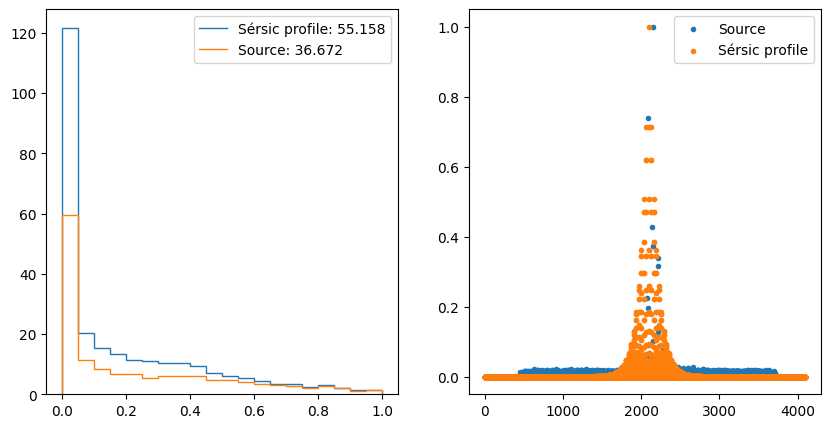

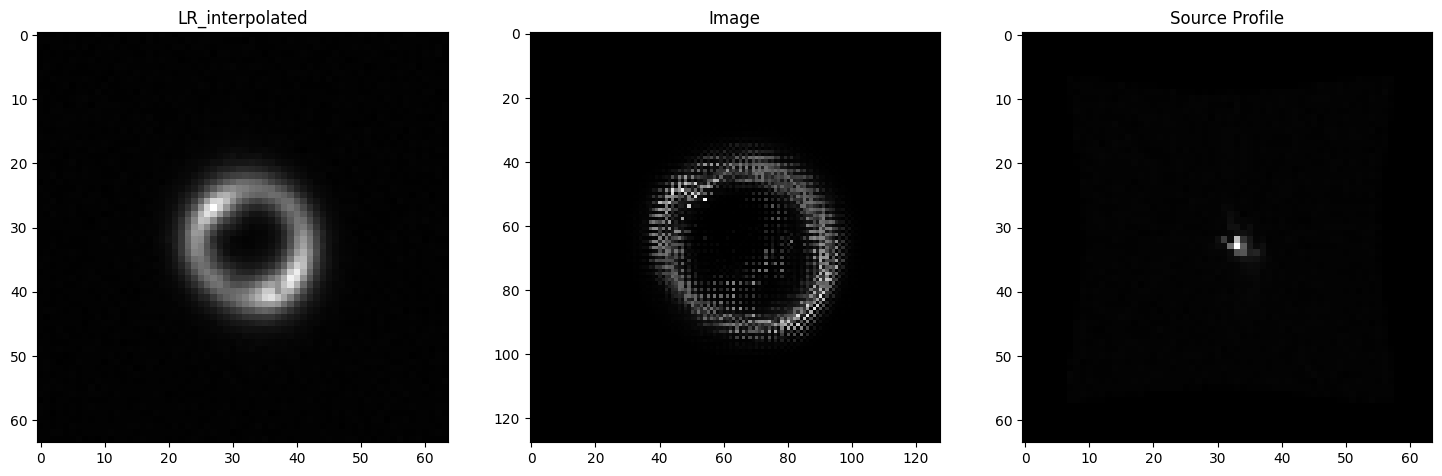

In [9]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [10]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    alpha_model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = transforms((x.float().to(device)))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = transforms((x.float().to(device)))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual = lens_loss(alpha, x)
        losses.append(float(val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 1/1000: 0.02229874317602415 at LR=1e-05


Validation epoch 1: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]


Validation at epoch 1/1000: 0.02418974361249379 at LR=1e-05


Training epoch 2: 100%|██████████| 82/82 [00:04<00:00, 19.09it/s]


Training at epoch 2/1000: 0.023350979133350103 at LR=1e-05


Validation epoch 2: 100%|██████████| 21/21 [00:00<00:00, 23.47it/s]


Validation at epoch 2/1000: 0.02422645226830529 at LR=1e-05


Training epoch 3: 100%|██████████| 82/82 [00:04<00:00, 19.16it/s]


Training at epoch 3/1000: 0.02320891686874192 at LR=1e-05


Validation epoch 3: 100%|██████████| 21/21 [00:00<00:00, 23.88it/s]


Validation at epoch 3/1000: 0.02440326722959677 at LR=1e-05


Training epoch 4: 100%|██████████| 82/82 [00:04<00:00, 19.35it/s]


Training at epoch 4/1000: 0.023394839974438274 at LR=1e-05


Validation epoch 4: 100%|██████████| 21/21 [00:00<00:00, 23.88it/s]


Validation at epoch 4/1000: 0.023063635808371355 at LR=1e-05


Training epoch 5: 100%|██████████| 82/82 [00:04<00:00, 19.21it/s]


Training at epoch 5/1000: 0.02327848021395322 at LR=1e-05


Validation epoch 5: 100%|██████████| 21/21 [00:00<00:00, 23.84it/s]


Validation at epoch 5/1000: 0.023479945602871116 at LR=1e-05


Training epoch 6: 100%|██████████| 82/82 [00:04<00:00, 18.99it/s]


Training at epoch 6/1000: 0.023330722322187768 at LR=1e-05


Validation epoch 6: 100%|██████████| 21/21 [00:00<00:00, 23.60it/s]


Validation at epoch 6/1000: 0.02345249447084608 at LR=1e-05


Training epoch 7: 100%|██████████| 82/82 [00:04<00:00, 19.14it/s]


Training at epoch 7/1000: 0.02311263805845888 at LR=1e-05


Validation epoch 7: 100%|██████████| 21/21 [00:00<00:00, 24.36it/s]


Validation at epoch 7/1000: 0.02357706516271546 at LR=1e-05


Training epoch 8: 100%|██████████| 82/82 [00:04<00:00, 19.17it/s]


Training at epoch 8/1000: 0.023089627599025643 at LR=1e-05


Validation epoch 8: 100%|██████████| 21/21 [00:00<00:00, 23.70it/s]


Validation at epoch 8/1000: 0.02326179810223125 at LR=1e-05


Training epoch 9: 100%|██████████| 82/82 [00:04<00:00, 19.07it/s]


Training at epoch 9/1000: 0.023009503555552258 at LR=1e-05


Validation epoch 9: 100%|██████████| 21/21 [00:00<00:00, 23.40it/s]


Validation at epoch 9/1000: 0.023284664821057094 at LR=1e-05


Training epoch 10: 100%|██████████| 82/82 [00:04<00:00, 19.05it/s]


Training at epoch 10/1000: 0.022884461165564814 at LR=1e-05


Validation epoch 10: 100%|██████████| 21/21 [00:00<00:00, 23.49it/s]


Validation at epoch 10/1000: 0.023440314545517878 at LR=1e-05


Training epoch 11: 100%|██████████| 82/82 [00:04<00:00, 19.03it/s]


Training at epoch 11/1000: 0.022743537931180585 at LR=1e-05


Validation epoch 11: 100%|██████████| 21/21 [00:00<00:00, 23.82it/s]


Validation at epoch 11/1000: 0.023124015845713157 at LR=1e-05


Training epoch 12: 100%|██████████| 82/82 [00:04<00:00, 19.05it/s]


Training at epoch 12/1000: 0.022842599260734342 at LR=1e-05


Validation epoch 12: 100%|██████████| 21/21 [00:00<00:00, 24.05it/s]


Validation at epoch 12/1000: 0.022588478223908512 at LR=1e-05


Training epoch 13: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 13/1000: 0.02267867035982086 at LR=1e-05


Validation epoch 13: 100%|██████████| 21/21 [00:00<00:00, 23.79it/s]


Validation at epoch 13/1000: 0.02378440763623941 at LR=1e-05


Training epoch 14: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 14/1000: 0.022557050989168444 at LR=1e-05


Validation epoch 14: 100%|██████████| 21/21 [00:00<00:00, 23.40it/s]


Validation at epoch 14/1000: 0.022857499708022394 at LR=1e-05


Training epoch 15: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 15/1000: 0.02251725568913105 at LR=1e-05


Validation epoch 15: 100%|██████████| 21/21 [00:00<00:00, 22.99it/s]


Validation at epoch 15/1000: 0.02281225756520317 at LR=1e-05


Training epoch 16: 100%|██████████| 82/82 [00:04<00:00, 18.95it/s]


Training at epoch 16/1000: 0.02263289914898029 at LR=1e-05


Validation epoch 16: 100%|██████████| 21/21 [00:00<00:00, 23.59it/s]


Validation at epoch 16/1000: 0.022537832458813988 at LR=1e-05


Training epoch 17: 100%|██████████| 82/82 [00:04<00:00, 19.10it/s]


Training at epoch 17/1000: 0.022324409790155368 at LR=1e-05


Validation epoch 17: 100%|██████████| 21/21 [00:00<00:00, 23.25it/s]


Validation at epoch 17/1000: 0.022184695871103374 at LR=1e-05


Training epoch 18: 100%|██████████| 82/82 [00:04<00:00, 18.97it/s]


Training at epoch 18/1000: 0.022451810311616915 at LR=1e-05


Validation epoch 18: 100%|██████████| 21/21 [00:00<00:00, 23.79it/s]


Validation at epoch 18/1000: 0.021946272679737637 at LR=1e-05


Training epoch 19: 100%|██████████| 82/82 [00:04<00:00, 18.96it/s]


Training at epoch 19/1000: 0.02228474905487241 at LR=1e-05


Validation epoch 19: 100%|██████████| 21/21 [00:00<00:00, 23.08it/s]


Validation at epoch 19/1000: 0.022180665107000445 at LR=1e-05


Training epoch 20: 100%|██████████| 82/82 [00:04<00:00, 19.10it/s]


Training at epoch 20/1000: 0.022003839928202512 at LR=1e-05


Validation epoch 20: 100%|██████████| 21/21 [00:00<00:00, 23.62it/s]


Validation at epoch 20/1000: 0.02231779463943981 at LR=1e-05


Training epoch 21: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 21/1000: 0.022199124256830398 at LR=1e-05


Validation epoch 21: 100%|██████████| 21/21 [00:00<00:00, 23.77it/s]


Validation at epoch 21/1000: 0.022131301019163357 at LR=1e-05


Training epoch 22: 100%|██████████| 82/82 [00:04<00:00, 18.94it/s]


Training at epoch 22/1000: 0.021681280306926586 at LR=1e-05


Validation epoch 22: 100%|██████████| 21/21 [00:00<00:00, 23.15it/s]


Validation at epoch 22/1000: 0.021606309428101496 at LR=1e-05


Training epoch 23: 100%|██████████| 82/82 [00:04<00:00, 19.08it/s]


Training at epoch 23/1000: 0.02185265167911605 at LR=1e-05


Validation epoch 23: 100%|██████████| 21/21 [00:00<00:00, 23.38it/s]


Validation at epoch 23/1000: 0.022344522532962617 at LR=1e-05


Training epoch 24: 100%|██████████| 82/82 [00:04<00:00, 19.02it/s]


Training at epoch 24/1000: 0.021770343888641852 at LR=1e-05


Validation epoch 24: 100%|██████████| 21/21 [00:00<00:00, 23.09it/s]


Validation at epoch 24/1000: 0.021819200011945906 at LR=1e-05


Training epoch 25: 100%|██████████| 82/82 [00:04<00:00, 19.02it/s]


Training at epoch 25/1000: 0.02166573208098005 at LR=1e-05


Validation epoch 25: 100%|██████████| 21/21 [00:00<00:00, 23.68it/s]


Validation at epoch 25/1000: 0.021929508829045867 at LR=1e-05


Training epoch 26: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 26/1000: 0.02149596092541043 at LR=1e-05


Validation epoch 26: 100%|██████████| 21/21 [00:00<00:00, 23.32it/s]


Validation at epoch 26/1000: 0.021775274670549807 at LR=1e-05


Training epoch 27: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 27/1000: 0.02169225846485394 at LR=1e-05


Validation epoch 27: 100%|██████████| 21/21 [00:00<00:00, 23.12it/s]


Validation at epoch 27/1000: 0.02165508846796694 at LR=1e-05


Training epoch 28: 100%|██████████| 82/82 [00:04<00:00, 19.04it/s]


Training at epoch 28/1000: 0.021515692720507705 at LR=1e-05


Validation epoch 28: 100%|██████████| 21/21 [00:00<00:00, 23.22it/s]


Validation at epoch 28/1000: 0.021633315831422806 at LR=1e-05


Training epoch 29: 100%|██████████| 82/82 [00:04<00:00, 19.27it/s]


Training at epoch 29/1000: 0.021437682620272402 at LR=1e-05


Validation epoch 29: 100%|██████████| 21/21 [00:00<00:00, 22.96it/s]


Validation at epoch 29/1000: 0.021362739659491037 at LR=1e-05


Training epoch 30: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 30/1000: 0.02145869861833933 at LR=1e-05


Validation epoch 30: 100%|██████████| 21/21 [00:00<00:00, 23.36it/s]


Validation at epoch 30/1000: 0.021814110555819104 at LR=1e-05


Training epoch 31: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 31/1000: 0.021339076139578 at LR=1e-05


Validation epoch 31: 100%|██████████| 21/21 [00:00<00:00, 23.40it/s]


Validation at epoch 31/1000: 0.021999926616748176 at LR=1e-05


Training epoch 32: 100%|██████████| 82/82 [00:04<00:00, 18.78it/s]


Training at epoch 32/1000: 0.021197804817702712 at LR=1e-05


Validation epoch 32: 100%|██████████| 21/21 [00:00<00:00, 23.71it/s]


Validation at epoch 32/1000: 0.022151095526559007 at LR=1e-05


Training epoch 33: 100%|██████████| 82/82 [00:04<00:00, 19.06it/s]


Training at epoch 33/1000: 0.021273688708500167 at LR=1e-05


Validation epoch 33: 100%|██████████| 21/21 [00:00<00:00, 23.39it/s]


Validation at epoch 33/1000: 0.021217026437322303 at LR=1e-05


Training epoch 34: 100%|██████████| 82/82 [00:04<00:00, 18.94it/s]


Training at epoch 34/1000: 0.02115964121753123 at LR=1e-05


Validation epoch 34: 100%|██████████| 21/21 [00:00<00:00, 23.75it/s]


Validation at epoch 34/1000: 0.021655860356986523 at LR=1e-05


Training epoch 35: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 35/1000: 0.021293053312636 at LR=1e-05


Validation epoch 35: 100%|██████████| 21/21 [00:00<00:00, 23.60it/s]


Validation at epoch 35/1000: 0.022131382931201232 at LR=1e-05


Training epoch 36: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 36/1000: 0.021125461906194687 at LR=1e-05


Validation epoch 36: 100%|██████████| 21/21 [00:00<00:00, 23.55it/s]


Validation at epoch 36/1000: 0.021430157036298796 at LR=1e-05


Training epoch 37: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 37/1000: 0.021228081705730137 at LR=1e-05


Validation epoch 37: 100%|██████████| 21/21 [00:00<00:00, 23.24it/s]


Validation at epoch 37/1000: 0.02084997309637921 at LR=1e-05


Training epoch 38: 100%|██████████| 82/82 [00:04<00:00, 19.01it/s]


Training at epoch 38/1000: 0.02103907992018432 at LR=1e-05


Validation epoch 38: 100%|██████████| 21/21 [00:00<00:00, 23.65it/s]


Validation at epoch 38/1000: 0.020855460448988852 at LR=1e-05


Training epoch 39: 100%|██████████| 82/82 [00:04<00:00, 19.03it/s]


Training at epoch 39/1000: 0.02086435315176481 at LR=1e-05


Validation epoch 39: 100%|██████████| 21/21 [00:00<00:00, 23.24it/s]


Validation at epoch 39/1000: 0.020657453597301527 at LR=1e-05


Training epoch 40: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 40/1000: 0.020896534072008074 at LR=1e-05


Validation epoch 40: 100%|██████████| 21/21 [00:00<00:00, 23.27it/s]


Validation at epoch 40/1000: 0.021636277570256164 at LR=1e-05


Training epoch 41: 100%|██████████| 82/82 [00:04<00:00, 18.95it/s]


Training at epoch 41/1000: 0.020676543436399325 at LR=1e-05


Validation epoch 41: 100%|██████████| 21/21 [00:00<00:00, 23.56it/s]


Validation at epoch 41/1000: 0.02083760588651612 at LR=1e-05


Training epoch 42: 100%|██████████| 82/82 [00:04<00:00, 18.66it/s]


Training at epoch 42/1000: 0.02074013580000255 at LR=1e-05


Validation epoch 42: 100%|██████████| 21/21 [00:00<00:00, 23.14it/s]


Validation at epoch 42/1000: 0.020598479724001313 at LR=1e-05


Training epoch 43: 100%|██████████| 82/82 [00:04<00:00, 18.88it/s]


Training at epoch 43/1000: 0.020534720180965055 at LR=1e-05


Validation epoch 43: 100%|██████████| 21/21 [00:00<00:00, 23.13it/s]


Validation at epoch 43/1000: 0.020386903236309685 at LR=1e-05


Training epoch 44: 100%|██████████| 82/82 [00:04<00:00, 18.80it/s]


Training at epoch 44/1000: 0.020468909157122052 at LR=1e-05


Validation epoch 44: 100%|██████████| 21/21 [00:00<00:00, 23.21it/s]


Validation at epoch 44/1000: 0.020316256698043572 at LR=1e-05


Training epoch 45: 100%|██████████| 82/82 [00:04<00:00, 18.86it/s]


Training at epoch 45/1000: 0.02039436275911767 at LR=1e-05


Validation epoch 45: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]


Validation at epoch 45/1000: 0.02064176870598679 at LR=1e-05


Training epoch 46: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 46/1000: 0.020008877056037506 at LR=1e-05


Validation epoch 46: 100%|██████████| 21/21 [00:00<00:00, 22.73it/s]


Validation at epoch 46/1000: 0.020836155639872664 at LR=1e-05


Training epoch 47: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 47/1000: 0.019895136719796713 at LR=1e-05


Validation epoch 47: 100%|██████████| 21/21 [00:00<00:00, 22.91it/s]


Validation at epoch 47/1000: 0.02091766610032036 at LR=1e-05


Training epoch 48: 100%|██████████| 82/82 [00:04<00:00, 18.87it/s]


Training at epoch 48/1000: 0.019805643116919007 at LR=1e-05


Validation epoch 48: 100%|██████████| 21/21 [00:00<00:00, 23.04it/s]


Validation at epoch 48/1000: 0.019773181882642564 at LR=1e-05


Training epoch 49: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 49/1000: 0.019582672567084073 at LR=1e-05


Validation epoch 49: 100%|██████████| 21/21 [00:00<00:00, 23.16it/s]


Validation at epoch 49/1000: 0.019651306527001516 at LR=1e-05


Training epoch 50: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 50/1000: 0.01905817565758054 at LR=1e-05


Validation epoch 50: 100%|██████████| 21/21 [00:00<00:00, 22.96it/s]


Validation at epoch 50/1000: 0.019209468958988073 at LR=1e-05


Training epoch 51: 100%|██████████| 82/82 [00:04<00:00, 18.98it/s]


Training at epoch 51/1000: 0.018690598538009133 at LR=1e-05


Validation epoch 51: 100%|██████████| 21/21 [00:00<00:00, 22.88it/s]


Validation at epoch 51/1000: 0.01817756665072271 at LR=1e-05


Training epoch 52: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 52/1000: 0.018162186825420798 at LR=1e-05


Validation epoch 52: 100%|██████████| 21/21 [00:00<00:00, 23.23it/s]


Validation at epoch 52/1000: 0.018123537257668517 at LR=1e-05


Training epoch 53: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 53/1000: 0.016916629642520734 at LR=1e-05


Validation epoch 53: 100%|██████████| 21/21 [00:00<00:00, 23.38it/s]


Validation at epoch 53/1000: 0.017448504056249346 at LR=1e-05


Training epoch 54: 100%|██████████| 82/82 [00:04<00:00, 18.78it/s]


Training at epoch 54/1000: 0.01625563992505393 at LR=1e-05


Validation epoch 54: 100%|██████████| 21/21 [00:00<00:00, 23.24it/s]


Validation at epoch 54/1000: 0.015589921690878413 at LR=1e-05


Training epoch 55: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 55/1000: 0.015455002635263088 at LR=1e-05


Validation epoch 55: 100%|██████████| 21/21 [00:00<00:00, 23.54it/s]


Validation at epoch 55/1000: 0.015148478027965345 at LR=1e-05


Training epoch 56: 100%|██████████| 82/82 [00:04<00:00, 18.78it/s]


Training at epoch 56/1000: 0.014629405071368305 at LR=1e-05


Validation epoch 56: 100%|██████████| 21/21 [00:00<00:00, 23.18it/s]


Validation at epoch 56/1000: 0.014115669897624427 at LR=1e-05


Training epoch 57: 100%|██████████| 82/82 [00:04<00:00, 18.78it/s]


Training at epoch 57/1000: 0.014272779828255498 at LR=1e-05


Validation epoch 57: 100%|██████████| 21/21 [00:00<00:00, 23.52it/s]


Validation at epoch 57/1000: 0.015092126892081326 at LR=1e-05


Training epoch 58: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 58/1000: 0.013926417078459406 at LR=1e-05


Validation epoch 58: 100%|██████████| 21/21 [00:00<00:00, 23.45it/s]


Validation at epoch 58/1000: 0.014095069707504342 at LR=1e-05


Training epoch 59: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 59/1000: 0.013821873700291646 at LR=1e-05


Validation epoch 59: 100%|██████████| 21/21 [00:00<00:00, 23.56it/s]


Validation at epoch 59/1000: 0.01354622481656926 at LR=1e-05


Training epoch 60: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 60/1000: 0.013618467705006278 at LR=1e-05


Validation epoch 60: 100%|██████████| 21/21 [00:00<00:00, 23.56it/s]


Validation at epoch 60/1000: 0.013542478394118096 at LR=1e-05


Training epoch 61: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 61/1000: 0.013150262907601712 at LR=1e-05


Validation epoch 61: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 61/1000: 0.01503985911785137 at LR=1e-05


Training epoch 62: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 62/1000: 0.013065674671585242 at LR=1e-05


Validation epoch 62: 100%|██████████| 21/21 [00:00<00:00, 23.36it/s]


Validation at epoch 62/1000: 0.013059490559888736 at LR=1e-05


Training epoch 63: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 63/1000: 0.013038130863228949 at LR=1e-05


Validation epoch 63: 100%|██████████| 21/21 [00:00<00:00, 23.16it/s]


Validation at epoch 63/1000: 0.012162962274271107 at LR=1e-05


Training epoch 64: 100%|██████████| 82/82 [00:04<00:00, 18.95it/s]


Training at epoch 64/1000: 0.012789369946936281 at LR=1e-05


Validation epoch 64: 100%|██████████| 21/21 [00:00<00:00, 23.05it/s]


Validation at epoch 64/1000: 0.013810584942499796 at LR=1e-05


Training epoch 65: 100%|██████████| 82/82 [00:04<00:00, 18.91it/s]


Training at epoch 65/1000: 0.012498275070201334 at LR=1e-05


Validation epoch 65: 100%|██████████| 21/21 [00:00<00:00, 22.74it/s]


Validation at epoch 65/1000: 0.012906452862634544 at LR=1e-05


Training epoch 66: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 66/1000: 0.012286157540340976 at LR=1e-05


Validation epoch 66: 100%|██████████| 21/21 [00:00<00:00, 23.03it/s]


Validation at epoch 66/1000: 0.012771668134345894 at LR=1e-05


Training epoch 67: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 67/1000: 0.012291436890003884 at LR=1e-05


Validation epoch 67: 100%|██████████| 21/21 [00:00<00:00, 23.10it/s]


Validation at epoch 67/1000: 0.01260411950005662 at LR=1e-05


Training epoch 68: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 68/1000: 0.012246437348061946 at LR=1e-05


Validation epoch 68: 100%|██████████| 21/21 [00:00<00:00, 22.68it/s]


Validation at epoch 68/1000: 0.013273575631458135 at LR=1e-05


Training epoch 69: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 69/1000: 0.011809825454270695 at LR=1e-05


Validation epoch 69: 100%|██████████| 21/21 [00:00<00:00, 23.34it/s]


Validation at epoch 69/1000: 0.012769972284634909 at LR=1e-05


Training epoch 70: 100%|██████████| 82/82 [00:04<00:00, 19.05it/s]


Training at epoch 70/1000: 0.01177326977116669 at LR=1e-05


Validation epoch 70: 100%|██████████| 21/21 [00:00<00:00, 22.71it/s]


Validation at epoch 70/1000: 0.013313213429812874 at LR=1e-05


Training epoch 71: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 71/1000: 0.011896987263931007 at LR=1e-05


Validation epoch 71: 100%|██████████| 21/21 [00:00<00:00, 23.09it/s]


Validation at epoch 71/1000: 0.013099935149685257 at LR=1e-05


Training epoch 72: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 72/1000: 0.011846415664455514 at LR=1e-05


Validation epoch 72: 100%|██████████| 21/21 [00:00<00:00, 22.44it/s]


Validation at epoch 72/1000: 0.010855205977956455 at LR=1e-05


Training epoch 73: 100%|██████████| 82/82 [00:04<00:00, 18.86it/s]


Training at epoch 73/1000: 0.011638607784378818 at LR=1e-05


Validation epoch 73: 100%|██████████| 21/21 [00:00<00:00, 22.71it/s]


Validation at epoch 73/1000: 0.011499324037383 at LR=1e-05


Training epoch 74: 100%|██████████| 82/82 [00:04<00:00, 18.87it/s]


Training at epoch 74/1000: 0.011430627189394907 at LR=1e-05


Validation epoch 74: 100%|██████████| 21/21 [00:00<00:00, 23.63it/s]


Validation at epoch 74/1000: 0.012127860970351668 at LR=1e-05


Training epoch 75: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 75/1000: 0.011431819634375775 at LR=1e-05


Validation epoch 75: 100%|██████████| 21/21 [00:00<00:00, 22.86it/s]


Validation at epoch 75/1000: 0.011912042940301555 at LR=1e-05


Training epoch 76: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 76/1000: 0.011408096315657222 at LR=1e-05


Validation epoch 76: 100%|██████████| 21/21 [00:00<00:00, 23.17it/s]


Validation at epoch 76/1000: 0.012418704672849603 at LR=1e-05


Training epoch 77: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 77/1000: 0.011126202457334575 at LR=1e-05


Validation epoch 77: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s]


Validation at epoch 77/1000: 0.011045061617291399 at LR=1e-05


Training epoch 78: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 78/1000: 0.011189828734708633 at LR=1e-05


Validation epoch 78: 100%|██████████| 21/21 [00:00<00:00, 23.38it/s]


Validation at epoch 78/1000: 0.011024122176292754 at LR=1e-05


Training epoch 79: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 79/1000: 0.011243737876278963 at LR=1e-05


Validation epoch 79: 100%|██████████| 21/21 [00:00<00:00, 23.63it/s]


Validation at epoch 79/1000: 0.010897677835254443 at LR=1e-05


Training epoch 80: 100%|██████████| 82/82 [00:04<00:00, 18.89it/s]


Training at epoch 80/1000: 0.010993100458574368 at LR=1e-05


Validation epoch 80: 100%|██████████| 21/21 [00:00<00:00, 23.17it/s]


Validation at epoch 80/1000: 0.011774566978038777 at LR=1e-05


Training epoch 81: 100%|██████████| 82/82 [00:04<00:00, 18.40it/s]


Training at epoch 81/1000: 0.010913580008668872 at LR=1e-05


Validation epoch 81: 100%|██████████| 21/21 [00:00<00:00, 23.21it/s]


Validation at epoch 81/1000: 0.010611479680630424 at LR=1e-05


Training epoch 82: 100%|██████████| 82/82 [00:04<00:00, 18.44it/s]


Training at epoch 82/1000: 0.010704116685679409 at LR=1e-05


Validation epoch 82: 100%|██████████| 21/21 [00:00<00:00, 23.01it/s]


Validation at epoch 82/1000: 0.012640724712539287 at LR=1e-05


Training epoch 83: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 83/1000: 0.010737340125005419 at LR=1e-05


Validation epoch 83: 100%|██████████| 21/21 [00:00<00:00, 22.83it/s]


Validation at epoch 83/1000: 0.011453929645497175 at LR=1e-05


Training epoch 84: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 84/1000: 0.01098304212933815 at LR=1e-05


Validation epoch 84: 100%|██████████| 21/21 [00:00<00:00, 23.20it/s]


Validation at epoch 84/1000: 0.011525225138203019 at LR=1e-05


Training epoch 85: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 85/1000: 0.010670233432703263 at LR=1e-05


Validation epoch 85: 100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


Validation at epoch 85/1000: 0.011853879594820595 at LR=1e-05


Training epoch 86: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 86/1000: 0.010799508025051982 at LR=1e-05


Validation epoch 86: 100%|██████████| 21/21 [00:00<00:00, 23.05it/s]


Validation at epoch 86/1000: 0.011332623749261812 at LR=1e-05


Training epoch 87: 100%|██████████| 82/82 [00:04<00:00, 18.80it/s]


Training at epoch 87/1000: 0.010430316985925524 at LR=1e-05


Validation epoch 87: 100%|██████████| 21/21 [00:00<00:00, 23.47it/s]


Validation at epoch 87/1000: 0.011204729372236344 at LR=1e-05


Training epoch 88: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 88/1000: 0.010437582278760469 at LR=1e-05


Validation epoch 88: 100%|██████████| 21/21 [00:00<00:00, 23.35it/s]


Validation at epoch 88/1000: 0.010473251536798973 at LR=1e-05


Training epoch 89: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 89/1000: 0.010511449816432306 at LR=1e-05


Validation epoch 89: 100%|██████████| 21/21 [00:00<00:00, 22.38it/s]


Validation at epoch 89/1000: 0.011070102863457231 at LR=1e-05


Training epoch 90: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 90/1000: 0.010500314781760297 at LR=1e-05


Validation epoch 90: 100%|██████████| 21/21 [00:00<00:00, 22.48it/s]


Validation at epoch 90/1000: 0.010408585758081504 at LR=1e-05


Training epoch 91: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 91/1000: 0.010261546292274099 at LR=1e-05


Validation epoch 91: 100%|██████████| 21/21 [00:00<00:00, 21.89it/s]


Validation at epoch 91/1000: 0.010129165425453156 at LR=1e-05


Training epoch 92: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 92/1000: 0.010243459797759608 at LR=1e-05


Validation epoch 92: 100%|██████████| 21/21 [00:00<00:00, 23.15it/s]


Validation at epoch 92/1000: 0.011140737915411592 at LR=1e-05


Training epoch 93: 100%|██████████| 82/82 [00:04<00:00, 18.37it/s]


Training at epoch 93/1000: 0.010490246508951957 at LR=1e-05


Validation epoch 93: 100%|██████████| 21/21 [00:00<00:00, 22.40it/s]


Validation at epoch 93/1000: 0.01042119851003268 at LR=1e-05


Training epoch 94: 100%|██████████| 82/82 [00:04<00:00, 18.78it/s]


Training at epoch 94/1000: 0.010259699439857065 at LR=1e-05


Validation epoch 94: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]


Validation at epoch 94/1000: 0.012678597992773922 at LR=1e-05


Training epoch 95: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 95/1000: 0.010255282886735188 at LR=1e-05


Validation epoch 95: 100%|██████████| 21/21 [00:00<00:00, 22.76it/s]


Validation at epoch 95/1000: 0.009822067366691216 at LR=1e-05


Training epoch 96: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 96/1000: 0.010194493395208223 at LR=1e-05


Validation epoch 96: 100%|██████████| 21/21 [00:00<00:00, 22.89it/s]


Validation at epoch 96/1000: 0.011662683771213605 at LR=1e-05


Training epoch 97: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 97/1000: 0.010242161676060497 at LR=1e-05


Validation epoch 97: 100%|██████████| 21/21 [00:00<00:00, 22.36it/s]


Validation at epoch 97/1000: 0.011881103739142418 at LR=1e-05


Training epoch 98: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 98/1000: 0.010386670502357002 at LR=1e-05


Validation epoch 98: 100%|██████████| 21/21 [00:00<00:00, 22.87it/s]


Validation at epoch 98/1000: 0.010547052109835758 at LR=1e-05


Training epoch 99: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 99/1000: 0.010224039955973263 at LR=1e-05


Validation epoch 99: 100%|██████████| 21/21 [00:00<00:00, 22.87it/s]


Validation at epoch 99/1000: 0.010335127933926526 at LR=1e-05


Training epoch 100: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 100/1000: 0.010358393067357741 at LR=1e-05


Validation epoch 100: 100%|██████████| 21/21 [00:00<00:00, 22.78it/s]


Validation at epoch 100/1000: 0.011103554858848275 at LR=1e-05


Training epoch 101: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 101/1000: 0.010070742374831219 at LR=1e-05


Validation epoch 101: 100%|██████████| 21/21 [00:00<00:00, 22.88it/s]


Validation at epoch 101/1000: 0.009763477303619896 at LR=1e-05


Training epoch 102: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 102/1000: 0.009984643874326495 at LR=1e-05


Validation epoch 102: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]


Validation at epoch 102/1000: 0.010306594982033686 at LR=1e-05


Training epoch 103: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 103/1000: 0.009902750953986513 at LR=1e-05


Validation epoch 103: 100%|██████████| 21/21 [00:00<00:00, 23.23it/s]


Validation at epoch 103/1000: 0.010345882004392999 at LR=1e-05


Training epoch 104: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 104/1000: 0.009946662353397143 at LR=1e-05


Validation epoch 104: 100%|██████████| 21/21 [00:00<00:00, 22.86it/s]


Validation at epoch 104/1000: 0.010323189886375553 at LR=1e-05


Training epoch 105: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 105/1000: 0.009927742881700397 at LR=1e-05


Validation epoch 105: 100%|██████████| 21/21 [00:00<00:00, 23.11it/s]


Validation at epoch 105/1000: 0.009875282113041197 at LR=1e-05


Training epoch 106: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 106/1000: 0.010011724202053212 at LR=1e-05


Validation epoch 106: 100%|██████████| 21/21 [00:00<00:00, 23.28it/s]


Validation at epoch 106/1000: 0.010215164550269643 at LR=1e-05


Training epoch 107: 100%|██████████| 82/82 [00:04<00:00, 18.95it/s]


Training at epoch 107/1000: 0.009998017371200568 at LR=1e-05


Validation epoch 107: 100%|██████████| 21/21 [00:00<00:00, 23.21it/s]


Validation at epoch 107/1000: 0.010273901158056799 at LR=1e-05


Training epoch 108: 100%|██████████| 82/82 [00:04<00:00, 18.66it/s]


Training at epoch 108/1000: 0.009938949469204355 at LR=1e-05


Validation epoch 108: 100%|██████████| 21/21 [00:00<00:00, 23.24it/s]


Validation at epoch 108/1000: 0.010314135867658825 at LR=1e-05


Training epoch 109: 100%|██████████| 82/82 [00:04<00:00, 18.34it/s]


Training at epoch 109/1000: 0.009800044186526862 at LR=1e-05


Validation epoch 109: 100%|██████████| 21/21 [00:00<00:00, 23.28it/s]


Validation at epoch 109/1000: 0.010439431660675576 at LR=1e-05


Training epoch 110: 100%|██████████| 82/82 [00:04<00:00, 18.89it/s]


Training at epoch 110/1000: 0.009965669352379514 at LR=1e-05


Validation epoch 110: 100%|██████████| 21/21 [00:00<00:00, 23.02it/s]


Validation at epoch 110/1000: 0.01015029623106654 at LR=1e-05


Training epoch 111: 100%|██████████| 82/82 [00:04<00:00, 18.86it/s]


Training at epoch 111/1000: 0.009934746177594475 at LR=1e-05


Validation epoch 111: 100%|██████████| 21/21 [00:00<00:00, 22.69it/s]


Validation at epoch 111/1000: 0.010264723107130044 at LR=1e-05


Training epoch 112: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 112/1000: 0.01002738234109995 at LR=1e-05


Validation epoch 112: 100%|██████████| 21/21 [00:00<00:00, 22.69it/s]


Validation at epoch 112/1000: 0.009980548982552828 at LR=1e-05


Training epoch 113: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 113/1000: 0.010005457213193906 at LR=1e-05


Validation epoch 113: 100%|██████████| 21/21 [00:00<00:00, 22.73it/s]


Validation at epoch 113/1000: 0.009987565489219767 at LR=1e-05


Training epoch 114: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 114/1000: 0.00995751427736406 at LR=1e-05


Validation epoch 114: 100%|██████████| 21/21 [00:00<00:00, 22.93it/s]


Validation at epoch 114/1000: 0.010345240445097997 at LR=1e-05


Training epoch 115: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 115/1000: 0.009702828366354836 at LR=1e-05


Validation epoch 115: 100%|██████████| 21/21 [00:00<00:00, 22.65it/s]


Validation at epoch 115/1000: 0.010096951753699353 at LR=1e-05


Training epoch 116: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 116/1000: 0.009921019368736845 at LR=1e-05


Validation epoch 116: 100%|██████████| 21/21 [00:00<00:00, 23.33it/s]


Validation at epoch 116/1000: 0.009732336232749125 at LR=1e-05


Training epoch 117: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 117/1000: 0.009931212717031197 at LR=1e-05


Validation epoch 117: 100%|██████████| 21/21 [00:00<00:00, 22.92it/s]


Validation at epoch 117/1000: 0.010040773272824783 at LR=1e-05


Training epoch 118: 100%|██████████| 82/82 [00:04<00:00, 18.35it/s]


Training at epoch 118/1000: 0.00970975728137646 at LR=1e-05


Validation epoch 118: 100%|██████████| 21/21 [00:00<00:00, 22.65it/s]


Validation at epoch 118/1000: 0.010311852131659785 at LR=1e-05


Training epoch 119: 100%|██████████| 82/82 [00:04<00:00, 18.56it/s]


Training at epoch 119/1000: 0.009692699665476274 at LR=1e-05


Validation epoch 119: 100%|██████████| 21/21 [00:00<00:00, 21.86it/s]


Validation at epoch 119/1000: 0.010313317415282307 at LR=1e-05


Training epoch 120: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 120/1000: 0.009677532131829095 at LR=1e-05


Validation epoch 120: 100%|██████████| 21/21 [00:00<00:00, 22.35it/s]


Validation at epoch 120/1000: 0.010029673398960205 at LR=1e-05


Training epoch 121: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 121/1000: 0.009714188752695918 at LR=1e-05


Validation epoch 121: 100%|██████████| 21/21 [00:00<00:00, 22.27it/s]


Validation at epoch 121/1000: 0.010581092066353274 at LR=1e-05


Training epoch 122: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 122/1000: 0.009789043526369624 at LR=1e-05


Validation epoch 122: 100%|██████████| 21/21 [00:00<00:00, 23.04it/s]


Validation at epoch 122/1000: 0.010018430996708395 at LR=1e-05


Training epoch 123: 100%|██████████| 82/82 [00:04<00:00, 18.86it/s]


Training at epoch 123/1000: 0.009753565062632466 at LR=1e-05


Validation epoch 123: 100%|██████████| 21/21 [00:00<00:00, 23.38it/s]


Validation at epoch 123/1000: 0.009936138782428487 at LR=1e-05


Training epoch 124: 100%|██████████| 82/82 [00:04<00:00, 17.63it/s]


Training at epoch 124/1000: 0.009672190108132073 at LR=1e-05


Validation epoch 124: 100%|██████████| 21/21 [00:00<00:00, 22.91it/s]


Validation at epoch 124/1000: 0.009679552888320316 at LR=1e-05


Training epoch 125: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 125/1000: 0.009915120189827752 at LR=1e-05


Validation epoch 125: 100%|██████████| 21/21 [00:00<00:00, 22.45it/s]


Validation at epoch 125/1000: 0.010305358180111007 at LR=1e-05


Training epoch 126: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 126/1000: 0.009902786037589355 at LR=1e-05


Validation epoch 126: 100%|██████████| 21/21 [00:00<00:00, 23.70it/s]


Validation at epoch 126/1000: 0.010259376511731672 at LR=1e-05


Training epoch 127: 100%|██████████| 82/82 [00:04<00:00, 18.78it/s]


Training at epoch 127/1000: 0.009656128871095616 at LR=1e-05


Validation epoch 127: 100%|██████████| 21/21 [00:00<00:00, 23.06it/s]


Validation at epoch 127/1000: 0.010429753046039315 at LR=1e-05


Training epoch 128: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 128/1000: 0.009946253664632579 at LR=1e-05


Validation epoch 128: 100%|██████████| 21/21 [00:00<00:00, 23.17it/s]


Validation at epoch 128/1000: 0.010301993594371847 at LR=1e-05


Training epoch 129: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 129/1000: 0.009717789021456931 at LR=1e-05


Validation epoch 129: 100%|██████████| 21/21 [00:00<00:00, 23.16it/s]


Validation at epoch 129/1000: 0.010156214242756721 at LR=1e-05


Training epoch 130: 100%|██████████| 82/82 [00:04<00:00, 18.83it/s]


Training at epoch 130/1000: 0.00972792091381895 at LR=1e-05


Validation epoch 130: 100%|██████████| 21/21 [00:00<00:00, 23.18it/s]


Validation at epoch 130/1000: 0.010553347079881599 at LR=1e-05


Training epoch 131: 100%|██████████| 82/82 [00:04<00:00, 18.66it/s]


Training at epoch 131/1000: 0.00978588762057082 at LR=1e-05


Validation epoch 131: 100%|██████████| 21/21 [00:00<00:00, 23.58it/s]


Validation at epoch 131/1000: 0.009591719204936885 at LR=1e-05


Training epoch 132: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 132/1000: 0.009499203873707389 at LR=1e-05


Validation epoch 132: 100%|██████████| 21/21 [00:00<00:00, 23.37it/s]


Validation at epoch 132/1000: 0.010003994213461521 at LR=1e-05


Training epoch 133: 100%|██████████| 82/82 [00:04<00:00, 18.80it/s]


Training at epoch 133/1000: 0.009618501139168695 at LR=1e-05


Validation epoch 133: 100%|██████████| 21/21 [00:00<00:00, 23.06it/s]


Validation at epoch 133/1000: 0.009328078364931224 at LR=1e-05


Training epoch 134: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 134/1000: 0.009668839678009291 at LR=1e-05


Validation epoch 134: 100%|██████████| 21/21 [00:00<00:00, 23.52it/s]


Validation at epoch 134/1000: 0.010212708907645373 at LR=1e-05


Training epoch 135: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 135/1000: 0.009578518600702832 at LR=1e-05


Validation epoch 135: 100%|██████████| 21/21 [00:00<00:00, 23.03it/s]


Validation at epoch 135/1000: 0.00988208655534046 at LR=1e-05


Training epoch 136: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 136/1000: 0.009661069029101693 at LR=1e-05


Validation epoch 136: 100%|██████████| 21/21 [00:00<00:00, 23.70it/s]


Validation at epoch 136/1000: 0.00997820288120281 at LR=1e-05


Training epoch 137: 100%|██████████| 82/82 [00:04<00:00, 18.47it/s]


Training at epoch 137/1000: 0.009542888862353455 at LR=1e-05


Validation epoch 137: 100%|██████████| 21/21 [00:00<00:00, 23.16it/s]


Validation at epoch 137/1000: 0.00980264478130266 at LR=1e-05


Training epoch 138: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 138/1000: 0.009525353512045268 at LR=1e-05


Validation epoch 138: 100%|██████████| 21/21 [00:00<00:00, 23.18it/s]


Validation at epoch 138/1000: 0.009704184211191853 at LR=1e-05


Training epoch 139: 100%|██████████| 82/82 [00:04<00:00, 18.89it/s]


Training at epoch 139/1000: 0.009746567263813097 at LR=1e-05


Validation epoch 139: 100%|██████████| 21/21 [00:00<00:00, 23.03it/s]


Validation at epoch 139/1000: 0.009890238970651158 at LR=1e-05


Training epoch 140: 100%|██████████| 82/82 [00:04<00:00, 18.87it/s]


Training at epoch 140/1000: 0.009629703930397405 at LR=1e-05


Validation epoch 140: 100%|██████████| 21/21 [00:00<00:00, 23.34it/s]


Validation at epoch 140/1000: 0.009718725247131216 at LR=1e-05


Training epoch 141: 100%|██████████| 82/82 [00:04<00:00, 18.41it/s]


Training at epoch 141/1000: 0.009789395310757 at LR=1e-05


Validation epoch 141: 100%|██████████| 21/21 [00:00<00:00, 22.69it/s]


Validation at epoch 141/1000: 0.009642274429400763 at LR=1e-05


Training epoch 142: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 142/1000: 0.009643801828710044 at LR=1e-05


Validation epoch 142: 100%|██████████| 21/21 [00:00<00:00, 23.22it/s]


Validation at epoch 142/1000: 0.009107843800891368 at LR=1e-05


Training epoch 143: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 143/1000: 0.009724165429361165 at LR=1e-05


Validation epoch 143: 100%|██████████| 21/21 [00:00<00:00, 22.81it/s]


Validation at epoch 143/1000: 0.009775324258953333 at LR=1e-05


Training epoch 144: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 144/1000: 0.009598678233465406 at LR=1e-05


Validation epoch 144: 100%|██████████| 21/21 [00:00<00:00, 22.85it/s]


Validation at epoch 144/1000: 0.009990455505127708 at LR=1e-05


Training epoch 145: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 145/1000: 0.00958402247576997 at LR=1e-05


Validation epoch 145: 100%|██████████| 21/21 [00:00<00:00, 22.89it/s]


Validation at epoch 145/1000: 0.009562444995113072 at LR=1e-05


Training epoch 146: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 146/1000: 0.009619859884856497 at LR=1e-05


Validation epoch 146: 100%|██████████| 21/21 [00:00<00:00, 22.83it/s]


Validation at epoch 146/1000: 0.00983718335850253 at LR=1e-05


Training epoch 147: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 147/1000: 0.009658532640215281 at LR=1e-05


Validation epoch 147: 100%|██████████| 21/21 [00:00<00:00, 22.37it/s]


Validation at epoch 147/1000: 0.010245352118675199 at LR=1e-05


Training epoch 148: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 148/1000: 0.009634770898761726 at LR=1e-05


Validation epoch 148: 100%|██████████| 21/21 [00:00<00:00, 22.61it/s]


Validation at epoch 148/1000: 0.009479316322886873 at LR=1e-05


Training epoch 149: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 149/1000: 0.009514938861063523 at LR=1e-05


Validation epoch 149: 100%|██████████| 21/21 [00:00<00:00, 23.26it/s]


Validation at epoch 149/1000: 0.009637684328481555 at LR=1e-05


Training epoch 150: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 150/1000: 0.009469417707494845 at LR=1e-05


Validation epoch 150: 100%|██████████| 21/21 [00:00<00:00, 23.35it/s]


Validation at epoch 150/1000: 0.009811656624411365 at LR=1e-05


Training epoch 151: 100%|██████████| 82/82 [00:04<00:00, 18.83it/s]


Training at epoch 151/1000: 0.009457638634868513 at LR=1e-05


Validation epoch 151: 100%|██████████| 21/21 [00:00<00:00, 22.71it/s]


Validation at epoch 151/1000: 0.009228830708057753 at LR=1e-05


Training epoch 152: 100%|██████████| 82/82 [00:04<00:00, 18.94it/s]


Training at epoch 152/1000: 0.009425294613919971 at LR=1e-05


Validation epoch 152: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 152/1000: 0.010028290290695924 at LR=1e-05


Training epoch 153: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 153/1000: 0.009420749135088266 at LR=1e-05


Validation epoch 153: 100%|██████████| 21/21 [00:00<00:00, 23.02it/s]


Validation at epoch 153/1000: 0.00956850414236431 at LR=1e-05


Training epoch 154: 100%|██████████| 82/82 [00:04<00:00, 18.56it/s]


Training at epoch 154/1000: 0.009530108561171445 at LR=1e-05


Validation epoch 154: 100%|██████████| 21/21 [00:00<00:00, 22.58it/s]


Validation at epoch 154/1000: 0.010165114088782241 at LR=1e-05


Training epoch 155: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 155/1000: 0.009554378131813392 at LR=1e-05


Validation epoch 155: 100%|██████████| 21/21 [00:00<00:00, 23.43it/s]


Validation at epoch 155/1000: 0.009303581234278335 at LR=1e-05


Training epoch 156: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 156/1000: 0.009484131366196202 at LR=1e-05


Validation epoch 156: 100%|██████████| 21/21 [00:00<00:00, 22.75it/s]


Validation at epoch 156/1000: 0.009707798787747465 at LR=1e-05


Training epoch 157: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 157/1000: 0.00945442220445995 at LR=1e-05


Validation epoch 157: 100%|██████████| 21/21 [00:00<00:00, 23.28it/s]


Validation at epoch 157/1000: 0.00983470255076619 at LR=1e-05


Training epoch 158: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 158/1000: 0.009301666079497919 at LR=1e-05


Validation epoch 158: 100%|██████████| 21/21 [00:00<00:00, 23.27it/s]


Validation at epoch 158/1000: 0.009558623157707707 at LR=1e-05


Training epoch 159: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 159/1000: 0.009391036029428063 at LR=1e-05


Validation epoch 159: 100%|██████████| 21/21 [00:00<00:00, 23.28it/s]


Validation at epoch 159/1000: 0.00954675578395836 at LR=1e-05


Training epoch 160: 100%|██████████| 82/82 [00:04<00:00, 18.88it/s]


Training at epoch 160/1000: 0.009530047318193971 at LR=1e-05


Validation epoch 160: 100%|██████████| 21/21 [00:00<00:00, 23.19it/s]


Validation at epoch 160/1000: 0.009424323590272772 at LR=1e-05


Training epoch 161: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 161/1000: 0.009541283435438102 at LR=1e-05


Validation epoch 161: 100%|██████████| 21/21 [00:00<00:00, 22.22it/s]


Validation at epoch 161/1000: 0.010117220509398197 at LR=1e-05


Training epoch 162: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 162/1000: 0.009524858221638857 at LR=1e-05


Validation epoch 162: 100%|██████████| 21/21 [00:00<00:00, 23.24it/s]


Validation at epoch 162/1000: 0.009904657421256636 at LR=1e-05


Training epoch 163: 100%|██████████| 82/82 [00:04<00:00, 18.52it/s]


Training at epoch 163/1000: 0.009531757152616614 at LR=1e-05


Validation epoch 163: 100%|██████████| 21/21 [00:00<00:00, 23.16it/s]


Validation at epoch 163/1000: 0.009872491161028544 at LR=1e-05


Training epoch 164: 100%|██████████| 82/82 [00:04<00:00, 18.32it/s]


Training at epoch 164/1000: 0.009393699930004048 at LR=1e-05


Validation epoch 164: 100%|██████████| 21/21 [00:00<00:00, 23.66it/s]


Validation at epoch 164/1000: 0.009537163008991186 at LR=1e-05


Training epoch 165: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 165/1000: 0.009339088031726821 at LR=1e-05


Validation epoch 165: 100%|██████████| 21/21 [00:00<00:00, 22.84it/s]


Validation at epoch 165/1000: 0.009381356736412272 at LR=1e-05


Training epoch 166: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 166/1000: 0.009434347248227313 at LR=1e-05


Validation epoch 166: 100%|██████████| 21/21 [00:00<00:00, 23.43it/s]


Validation at epoch 166/1000: 0.009468834916506672 at LR=1e-05


Training epoch 167: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 167/1000: 0.009473360044222962 at LR=1e-05


Validation epoch 167: 100%|██████████| 21/21 [00:00<00:00, 23.20it/s]


Validation at epoch 167/1000: 0.009551386802091397 at LR=1e-05


Training epoch 168: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 168/1000: 0.009410811142382644 at LR=1e-05


Validation epoch 168: 100%|██████████| 21/21 [00:00<00:00, 22.92it/s]


Validation at epoch 168/1000: 0.009385485983719782 at LR=1e-05


Training epoch 169: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 169/1000: 0.0092600813907821 at LR=1e-05


Validation epoch 169: 100%|██████████| 21/21 [00:00<00:00, 22.42it/s]


Validation at epoch 169/1000: 0.009285963513234276 at LR=1e-05


Training epoch 170: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 170/1000: 0.009311380285042815 at LR=1e-05


Validation epoch 170: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 170/1000: 0.009675658324600331 at LR=1e-05


Training epoch 171: 100%|██████████| 82/82 [00:04<00:00, 18.56it/s]


Training at epoch 171/1000: 0.009454983499514439 at LR=1e-05


Validation epoch 171: 100%|██████████| 21/21 [00:00<00:00, 22.47it/s]


Validation at epoch 171/1000: 0.009437501212925694 at LR=1e-05


Training epoch 172: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 172/1000: 0.00930716758366765 at LR=1e-05


Validation epoch 172: 100%|██████████| 21/21 [00:00<00:00, 23.11it/s]


Validation at epoch 172/1000: 0.00979098723646963 at LR=1e-05


Training epoch 173: 100%|██████████| 82/82 [00:04<00:00, 18.43it/s]


Training at epoch 173/1000: 0.009293819896922243 at LR=1e-05


Validation epoch 173: 100%|██████████| 21/21 [00:00<00:00, 22.93it/s]


Validation at epoch 173/1000: 0.009628359123044425 at LR=1e-05


Training epoch 174: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 174/1000: 0.009459597035879043 at LR=1e-05


Validation epoch 174: 100%|██████████| 21/21 [00:00<00:00, 23.01it/s]


Validation at epoch 174/1000: 0.009803617445175493 at LR=1e-05


Training epoch 175: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 175/1000: 0.009445891917183449 at LR=1e-05


Validation epoch 175: 100%|██████████| 21/21 [00:00<00:00, 22.83it/s]


Validation at epoch 175/1000: 0.009260433426659023 at LR=1e-05


Training epoch 176: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 176/1000: 0.009318867070804827 at LR=1e-05


Validation epoch 176: 100%|██████████| 21/21 [00:00<00:00, 22.12it/s]


Validation at epoch 176/1000: 0.009280558778083928 at LR=1e-05


Training epoch 177: 100%|██████████| 82/82 [00:04<00:00, 18.86it/s]


Training at epoch 177/1000: 0.009362571293533576 at LR=1e-05


Validation epoch 177: 100%|██████████| 21/21 [00:00<00:00, 22.90it/s]


Validation at epoch 177/1000: 0.009725351729208515 at LR=1e-05


Training epoch 178: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 178/1000: 0.009237022065307672 at LR=1e-05


Validation epoch 178: 100%|██████████| 21/21 [00:00<00:00, 23.54it/s]


Validation at epoch 178/1000: 0.009701156931918203 at LR=1e-05


Training epoch 179: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 179/1000: 0.009303718098302986 at LR=1e-05


Validation epoch 179: 100%|██████████| 21/21 [00:00<00:00, 23.53it/s]


Validation at epoch 179/1000: 0.009368611122703268 at LR=1e-05


Training epoch 180: 100%|██████████| 82/82 [00:04<00:00, 18.86it/s]


Training at epoch 180/1000: 0.009310639420774106 at LR=1e-05


Validation epoch 180: 100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


Validation at epoch 180/1000: 0.009297966548252762 at LR=1e-05


Training epoch 181: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 181/1000: 0.009284466749238895 at LR=1e-05


Validation epoch 181: 100%|██████████| 21/21 [00:00<00:00, 22.20it/s]


Validation at epoch 181/1000: 0.00987209437880665 at LR=1e-05


Training epoch 182: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 182/1000: 0.009274098880180135 at LR=1e-05


Validation epoch 182: 100%|██████████| 21/21 [00:00<00:00, 23.36it/s]


Validation at epoch 182/1000: 0.009929488950763784 at LR=1e-05


Training epoch 183: 100%|██████████| 82/82 [00:04<00:00, 18.88it/s]


Training at epoch 183/1000: 0.009460790764267852 at LR=1e-05


Validation epoch 183: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 183/1000: 0.010139157402417845 at LR=1e-05


Training epoch 184: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 184/1000: 0.00943876649877738 at LR=1e-05


Validation epoch 184: 100%|██████████| 21/21 [00:00<00:00, 23.41it/s]


Validation at epoch 184/1000: 0.009295355215380411 at LR=1e-05


Training epoch 185: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 185/1000: 0.009260794993989714 at LR=1e-05


Validation epoch 185: 100%|██████████| 21/21 [00:00<00:00, 22.53it/s]


Validation at epoch 185/1000: 0.00897064542126221 at LR=1e-05


Training epoch 186: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 186/1000: 0.009126850230642025 at LR=1e-05


Validation epoch 186: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s]


Validation at epoch 186/1000: 0.00912877122893752 at LR=1e-05


Training epoch 187: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 187/1000: 0.009465349557037216 at LR=1e-05


Validation epoch 187: 100%|██████████| 21/21 [00:00<00:00, 23.03it/s]


Validation at epoch 187/1000: 0.009745362417085008 at LR=1e-05


Training epoch 188: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 188/1000: 0.009240261128558436 at LR=1e-05


Validation epoch 188: 100%|██████████| 21/21 [00:00<00:00, 22.26it/s]


Validation at epoch 188/1000: 0.009225939685988817 at LR=1e-05


Training epoch 189: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 189/1000: 0.009271194794919434 at LR=1e-05


Validation epoch 189: 100%|██████████| 21/21 [00:00<00:00, 22.63it/s]


Validation at epoch 189/1000: 0.009541390772071844 at LR=1e-05


Training epoch 190: 100%|██████████| 82/82 [00:04<00:00, 18.37it/s]


Training at epoch 190/1000: 0.009192366754954181 at LR=1e-05


Validation epoch 190: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 190/1000: 0.009137171495933129 at LR=1e-05


Training epoch 191: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 191/1000: 0.009390121731884415 at LR=1e-05


Validation epoch 191: 100%|██████████| 21/21 [00:00<00:00, 23.10it/s]


Validation at epoch 191/1000: 0.009383050331269346 at LR=1e-05


Training epoch 192: 100%|██████████| 82/82 [00:04<00:00, 18.36it/s]


Training at epoch 192/1000: 0.009345930271282247 at LR=1e-05


Validation epoch 192: 100%|██████████| 21/21 [00:00<00:00, 22.62it/s]


Validation at epoch 192/1000: 0.009553700278047472 at LR=1e-05


Training epoch 193: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 193/1000: 0.009204069027540888 at LR=1e-05


Validation epoch 193: 100%|██████████| 21/21 [00:00<00:00, 23.04it/s]


Validation at epoch 193/1000: 0.009338375519118492 at LR=1e-05


Training epoch 194: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 194/1000: 0.00916555280252019 at LR=1e-05


Validation epoch 194: 100%|██████████| 21/21 [00:00<00:00, 22.17it/s]


Validation at epoch 194/1000: 0.009494774606234083 at LR=1e-05


Training epoch 195: 100%|██████████| 82/82 [00:04<00:00, 18.44it/s]


Training at epoch 195/1000: 0.009320309354423932 at LR=1e-05


Validation epoch 195: 100%|██████████| 21/21 [00:00<00:00, 23.02it/s]


Validation at epoch 195/1000: 0.009091512753262317 at LR=1e-05


Training epoch 196: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 196/1000: 0.009406651475285067 at LR=1e-05


Validation epoch 196: 100%|██████████| 21/21 [00:00<00:00, 23.05it/s]


Validation at epoch 196/1000: 0.009164413880734218 at LR=1e-05


Training epoch 197: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 197/1000: 0.009184250247483029 at LR=1e-05


Validation epoch 197: 100%|██████████| 21/21 [00:00<00:00, 22.81it/s]


Validation at epoch 197/1000: 0.009195111054439275 at LR=1e-05


Training epoch 198: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 198/1000: 0.009385129073407592 at LR=1e-05


Validation epoch 198: 100%|██████████| 21/21 [00:00<00:00, 23.28it/s]


Validation at epoch 198/1000: 0.009273838104924098 at LR=1e-05


Training epoch 199: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 199/1000: 0.009196889410704012 at LR=1e-05


Validation epoch 199: 100%|██████████| 21/21 [00:00<00:00, 23.42it/s]


Validation at epoch 199/1000: 0.00937142103655441 at LR=1e-05


Training epoch 200: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 200/1000: 0.009086945761426738 at LR=1e-05


Validation epoch 200: 100%|██████████| 21/21 [00:00<00:00, 23.18it/s]


Validation at epoch 200/1000: 0.009377269617592296 at LR=1e-05


Training epoch 201: 100%|██████████| 82/82 [00:04<00:00, 18.22it/s]


Training at epoch 201/1000: 0.009164671348294288 at LR=1e-05


Validation epoch 201: 100%|██████████| 21/21 [00:00<00:00, 22.31it/s]


Validation at epoch 201/1000: 0.00912911064958843 at LR=1e-05


Training epoch 202: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 202/1000: 0.00912341202052719 at LR=1e-05


Validation epoch 202: 100%|██████████| 21/21 [00:00<00:00, 23.54it/s]


Validation at epoch 202/1000: 0.008895457300934054 at LR=1e-05


Training epoch 203: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 203/1000: 0.009253765535881605 at LR=1e-05


Validation epoch 203: 100%|██████████| 21/21 [00:00<00:00, 23.05it/s]


Validation at epoch 203/1000: 0.009589175602221596 at LR=1e-05


Training epoch 204: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 204/1000: 0.009160553491333637 at LR=1e-05


Validation epoch 204: 100%|██████████| 21/21 [00:00<00:00, 22.84it/s]


Validation at epoch 204/1000: 0.009304790652268344 at LR=1e-05


Training epoch 205: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 205/1000: 0.009076887736006116 at LR=1e-05


Validation epoch 205: 100%|██████████| 21/21 [00:00<00:00, 22.33it/s]


Validation at epoch 205/1000: 0.009054675651159846 at LR=1e-05


Training epoch 206: 100%|██████████| 82/82 [00:04<00:00, 18.78it/s]


Training at epoch 206/1000: 0.009213505099845552 at LR=1e-05


Validation epoch 206: 100%|██████████| 21/21 [00:00<00:00, 22.28it/s]


Validation at epoch 206/1000: 0.009146737976975385 at LR=1e-05


Training epoch 207: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 207/1000: 0.009156435259572436 at LR=1e-05


Validation epoch 207: 100%|██████████| 21/21 [00:00<00:00, 22.99it/s]


Validation at epoch 207/1000: 0.009658913599282858 at LR=1e-05


Training epoch 208: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 208/1000: 0.009079441155602292 at LR=1e-05


Validation epoch 208: 100%|██████████| 21/21 [00:00<00:00, 23.05it/s]


Validation at epoch 208/1000: 0.00942465130910499 at LR=1e-05


Training epoch 209: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 209/1000: 0.009254477154349953 at LR=1e-05


Validation epoch 209: 100%|██████████| 21/21 [00:00<00:00, 21.93it/s]


Validation at epoch 209/1000: 0.0096319089726811 at LR=1e-05


Training epoch 210: 100%|██████████| 82/82 [00:04<00:00, 18.56it/s]


Training at epoch 210/1000: 0.009114325597382537 at LR=1e-05


Validation epoch 210: 100%|██████████| 21/21 [00:00<00:00, 23.34it/s]


Validation at epoch 210/1000: 0.009145308678160376 at LR=1e-05


Training epoch 211: 100%|██████████| 82/82 [00:04<00:00, 18.88it/s]


Training at epoch 211/1000: 0.008935649547067175 at LR=1e-05


Validation epoch 211: 100%|██████████| 21/21 [00:00<00:00, 23.43it/s]


Validation at epoch 211/1000: 0.009001183966618208 at LR=1e-05


Training epoch 212: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 212/1000: 0.009007691814586884 at LR=1e-05


Validation epoch 212: 100%|██████████| 21/21 [00:00<00:00, 22.92it/s]


Validation at epoch 212/1000: 0.009156360781552004 at LR=1e-05


Training epoch 213: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 213/1000: 0.009092049999730435 at LR=1e-05


Validation epoch 213: 100%|██████████| 21/21 [00:00<00:00, 23.25it/s]


Validation at epoch 213/1000: 0.00916728009109474 at LR=1e-05


Training epoch 214: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 214/1000: 0.008909583838497537 at LR=1e-05


Validation epoch 214: 100%|██████████| 21/21 [00:00<00:00, 22.90it/s]


Validation at epoch 214/1000: 0.009291681648132257 at LR=1e-05


Training epoch 215: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 215/1000: 0.009231887030892255 at LR=1e-05


Validation epoch 215: 100%|██████████| 21/21 [00:00<00:00, 22.51it/s]


Validation at epoch 215/1000: 0.009146732793721768 at LR=1e-05


Training epoch 216: 100%|██████████| 82/82 [00:04<00:00, 18.47it/s]


Training at epoch 216/1000: 0.008925687200844107 at LR=1e-05


Validation epoch 216: 100%|██████████| 21/21 [00:00<00:00, 23.30it/s]


Validation at epoch 216/1000: 0.00907714830966489 at LR=1e-05


Training epoch 217: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 217/1000: 0.009174892366523059 at LR=1e-05


Validation epoch 217: 100%|██████████| 21/21 [00:00<00:00, 23.25it/s]


Validation at epoch 217/1000: 0.008727039997687652 at LR=1e-05


Training epoch 218: 100%|██████████| 82/82 [00:04<00:00, 18.49it/s]


Training at epoch 218/1000: 0.009040428189242758 at LR=1e-05


Validation epoch 218: 100%|██████████| 21/21 [00:00<00:00, 22.95it/s]


Validation at epoch 218/1000: 0.008937089099726153 at LR=1e-05


Training epoch 219: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 219/1000: 0.008891986589310917 at LR=1e-05


Validation epoch 219: 100%|██████████| 21/21 [00:00<00:00, 23.12it/s]


Validation at epoch 219/1000: 0.009134548807716263 at LR=1e-05


Training epoch 220: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 220/1000: 0.009118653572641494 at LR=1e-05


Validation epoch 220: 100%|██████████| 21/21 [00:00<00:00, 22.05it/s]


Validation at epoch 220/1000: 0.009518658429095966 at LR=1e-05


Training epoch 221: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 221/1000: 0.009084364703129521 at LR=1e-05


Validation epoch 221: 100%|██████████| 21/21 [00:00<00:00, 22.15it/s]


Validation at epoch 221/1000: 0.009575824807619766 at LR=1e-05


Training epoch 222: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 222/1000: 0.009008896990009107 at LR=1e-05


Validation epoch 222: 100%|██████████| 21/21 [00:00<00:00, 23.00it/s]


Validation at epoch 222/1000: 0.009359942286253153 at LR=1e-05


Training epoch 223: 100%|██████████| 82/82 [00:04<00:00, 18.49it/s]


Training at epoch 223/1000: 0.00899150098742145 at LR=1e-05


Validation epoch 223: 100%|██████████| 21/21 [00:00<00:00, 23.14it/s]


Validation at epoch 223/1000: 0.00907528490643017 at LR=1e-05


Training epoch 224: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 224/1000: 0.009047832013471278 at LR=1e-05


Validation epoch 224: 100%|██████████| 21/21 [00:00<00:00, 23.05it/s]


Validation at epoch 224/1000: 0.009323117488141481 at LR=1e-05


Training epoch 225: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 225/1000: 0.008909812932493301 at LR=1e-05


Validation epoch 225: 100%|██████████| 21/21 [00:00<00:00, 22.70it/s]


Validation at epoch 225/1000: 0.0096237677748182 at LR=1e-05


Training epoch 226: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 226/1000: 0.00899545534616109 at LR=1e-05


Validation epoch 226: 100%|██████████| 21/21 [00:00<00:00, 22.81it/s]


Validation at epoch 226/1000: 0.008901068013593822 at LR=1e-05


Training epoch 227: 100%|██████████| 82/82 [00:04<00:00, 18.40it/s]


Training at epoch 227/1000: 0.008837534875677126 at LR=1e-05


Validation epoch 227: 100%|██████████| 21/21 [00:00<00:00, 22.88it/s]


Validation at epoch 227/1000: 0.009153798589804432 at LR=1e-05


Training epoch 228: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 228/1000: 0.008903346572457472 at LR=1e-05


Validation epoch 228: 100%|██████████| 21/21 [00:00<00:00, 22.50it/s]


Validation at epoch 228/1000: 0.009267711230287596 at LR=1e-05


Training epoch 229: 100%|██████████| 82/82 [00:04<00:00, 18.15it/s]


Training at epoch 229/1000: 0.00913679517561388 at LR=1e-05


Validation epoch 229: 100%|██████████| 21/21 [00:00<00:00, 22.84it/s]


Validation at epoch 229/1000: 0.008762059029236081 at LR=1e-05


Training epoch 230: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 230/1000: 0.009173120115031828 at LR=1e-05


Validation epoch 230: 100%|██████████| 21/21 [00:00<00:00, 22.56it/s]


Validation at epoch 230/1000: 0.009356131803499357 at LR=1e-05


Training epoch 231: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 231/1000: 0.008844086599377233 at LR=1e-05


Validation epoch 231: 100%|██████████| 21/21 [00:00<00:00, 22.71it/s]


Validation at epoch 231/1000: 0.009218119615633484 at LR=1e-05


Training epoch 232: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 232/1000: 0.008933858071431156 at LR=1e-05


Validation epoch 232: 100%|██████████| 21/21 [00:00<00:00, 23.05it/s]


Validation at epoch 232/1000: 0.00891423684966174 at LR=1e-05


Training epoch 233: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 233/1000: 0.008920633350498974 at LR=1e-05


Validation epoch 233: 100%|██████████| 21/21 [00:00<00:00, 23.01it/s]


Validation at epoch 233/1000: 0.008850386844382488 at LR=1e-05


Training epoch 234: 100%|██████████| 82/82 [00:04<00:00, 18.17it/s]


Training at epoch 234/1000: 0.009116912425336677 at LR=1e-05


Validation epoch 234: 100%|██████████| 21/21 [00:00<00:00, 22.99it/s]


Validation at epoch 234/1000: 0.008897155819882062 at LR=1e-05


Training epoch 235: 100%|██████████| 82/82 [00:04<00:00, 18.80it/s]


Training at epoch 235/1000: 0.008965934198008986 at LR=1e-05


Validation epoch 235: 100%|██████████| 21/21 [00:00<00:00, 22.77it/s]


Validation at epoch 235/1000: 0.009680545014340342 at LR=1e-05


Training epoch 236: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 236/1000: 0.00893329860210964 at LR=1e-05


Validation epoch 236: 100%|██████████| 21/21 [00:00<00:00, 22.72it/s]


Validation at epoch 236/1000: 0.0092137384622003 at LR=1e-05


Training epoch 237: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 237/1000: 0.00907139087425227 at LR=1e-05


Validation epoch 237: 100%|██████████| 21/21 [00:00<00:00, 22.45it/s]


Validation at epoch 237/1000: 0.008938666218281946 at LR=1e-05


Training epoch 238: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 238/1000: 0.008972352491294192 at LR=1e-05


Validation epoch 238: 100%|██████████| 21/21 [00:00<00:00, 22.65it/s]


Validation at epoch 238/1000: 0.008968199982995256 at LR=1e-05


Training epoch 239: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 239/1000: 0.008956451329584347 at LR=1e-05


Validation epoch 239: 100%|██████████| 21/21 [00:00<00:00, 22.95it/s]


Validation at epoch 239/1000: 0.009333259938839114 at LR=1e-05


Training epoch 240: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 240/1000: 0.009078324854760091 at LR=1e-05


Validation epoch 240: 100%|██████████| 21/21 [00:00<00:00, 23.28it/s]


Validation at epoch 240/1000: 0.009379243609839164 at LR=1e-05


Training epoch 241: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 241/1000: 0.009025772261183437 at LR=1e-05


Validation epoch 241: 100%|██████████| 21/21 [00:00<00:00, 22.46it/s]


Validation at epoch 241/1000: 0.009393227805655139 at LR=1e-05


Training epoch 242: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 242/1000: 0.008971419267742555 at LR=1e-05


Validation epoch 242: 100%|██████████| 21/21 [00:00<00:00, 23.18it/s]


Validation at epoch 242/1000: 0.00944426663807549 at LR=1e-05


Training epoch 243: 100%|██████████| 82/82 [00:04<00:00, 18.83it/s]


Training at epoch 243/1000: 0.009156574377301718 at LR=1e-05


Validation epoch 243: 100%|██████████| 21/21 [00:00<00:00, 22.54it/s]


Validation at epoch 243/1000: 0.008955290915244923 at LR=1e-05


Training epoch 244: 100%|██████████| 82/82 [00:04<00:00, 18.83it/s]


Training at epoch 244/1000: 0.009191122536388477 at LR=1e-05


Validation epoch 244: 100%|██████████| 21/21 [00:00<00:00, 22.31it/s]


Validation at epoch 244/1000: 0.00900388558234443 at LR=1e-05


Training epoch 245: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 245/1000: 0.009071670461264326 at LR=1e-05


Validation epoch 245: 100%|██████████| 21/21 [00:00<00:00, 23.17it/s]


Validation at epoch 245/1000: 0.009200549063583216 at LR=1e-05


Training epoch 246: 100%|██████████| 82/82 [00:04<00:00, 18.33it/s]


Training at epoch 246/1000: 0.008903602030264532 at LR=1e-05


Validation epoch 246: 100%|██████████| 21/21 [00:00<00:00, 22.98it/s]


Validation at epoch 246/1000: 0.00940221908136404 at LR=1e-05


Training epoch 247: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 247/1000: 0.009018920120646859 at LR=1e-05


Validation epoch 247: 100%|██████████| 21/21 [00:00<00:00, 22.40it/s]


Validation at epoch 247/1000: 0.009393481029768563 at LR=1e-05


Training epoch 248: 100%|██████████| 82/82 [00:04<00:00, 18.41it/s]


Training at epoch 248/1000: 0.008849795828232677 at LR=1e-05


Validation epoch 248: 100%|██████████| 21/21 [00:00<00:00, 22.33it/s]


Validation at epoch 248/1000: 0.008918357762186566 at LR=1e-05


Training epoch 249: 100%|██████████| 82/82 [00:04<00:00, 18.56it/s]


Training at epoch 249/1000: 0.009036580068002478 at LR=1e-05


Validation epoch 249: 100%|██████████| 21/21 [00:00<00:00, 22.13it/s]


Validation at epoch 249/1000: 0.008637051280294102 at LR=1e-05


Training epoch 250: 100%|██████████| 82/82 [00:04<00:00, 18.31it/s]


Training at epoch 250/1000: 0.00880439508075985 at LR=1e-05


Validation epoch 250: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s]


Validation at epoch 250/1000: 0.00909656472919908 at LR=1e-05


Training epoch 251: 100%|██████████| 82/82 [00:04<00:00, 18.20it/s]


Training at epoch 251/1000: 0.008904200277245807 at LR=1e-05


Validation epoch 251: 100%|██████████| 21/21 [00:00<00:00, 23.06it/s]


Validation at epoch 251/1000: 0.009161842260038525 at LR=1e-05


Training epoch 252: 100%|██████████| 82/82 [00:04<00:00, 18.44it/s]


Training at epoch 252/1000: 0.008923305093492494 at LR=1e-05


Validation epoch 252: 100%|██████████| 21/21 [00:00<00:00, 23.08it/s]


Validation at epoch 252/1000: 0.009595239595953552 at LR=1e-05


Training epoch 253: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 253/1000: 0.008810431279083032 at LR=1e-05


Validation epoch 253: 100%|██████████| 21/21 [00:00<00:00, 23.33it/s]


Validation at epoch 253/1000: 0.009095118375539425 at LR=1e-05


Training epoch 254: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 254/1000: 0.008553308236026545 at LR=1e-05


Validation epoch 254: 100%|██████████| 21/21 [00:00<00:00, 22.78it/s]


Validation at epoch 254/1000: 0.00921043572210086 at LR=1e-05


Training epoch 255: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 255/1000: 0.00881789811523404 at LR=1e-05


Validation epoch 255: 100%|██████████| 21/21 [00:00<00:00, 22.72it/s]


Validation at epoch 255/1000: 0.00915875790330271 at LR=1e-05


Training epoch 256: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 256/1000: 0.008787911271721852 at LR=1e-05


Validation epoch 256: 100%|██████████| 21/21 [00:00<00:00, 22.43it/s]


Validation at epoch 256/1000: 0.008996114382864021 at LR=1e-05


Training epoch 257: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 257/1000: 0.008771614083543239 at LR=1e-05


Validation epoch 257: 100%|██████████| 21/21 [00:00<00:00, 22.82it/s]


Validation at epoch 257/1000: 0.009180792963542487 at LR=1e-05


Training epoch 258: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 258/1000: 0.008840226619390816 at LR=1e-05


Validation epoch 258: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 258/1000: 0.008942514026005353 at LR=1e-05


Training epoch 259: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 259/1000: 0.00892612941154256 at LR=1e-05


Validation epoch 259: 100%|██████████| 21/21 [00:00<00:00, 22.88it/s]


Validation at epoch 259/1000: 0.009211090200031842 at LR=1e-05


Training epoch 260: 100%|██████████| 82/82 [00:04<00:00, 18.23it/s]


Training at epoch 260/1000: 0.008842396653518535 at LR=1e-05


Validation epoch 260: 100%|██████████| 21/21 [00:00<00:00, 23.03it/s]


Validation at epoch 260/1000: 0.009129061135657441 at LR=1e-05


Training epoch 261: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 261/1000: 0.008776888017054283 at LR=1e-05


Validation epoch 261: 100%|██████████| 21/21 [00:00<00:00, 22.77it/s]


Validation at epoch 261/1000: 0.008886849439780537 at LR=1e-05


Training epoch 262: 100%|██████████| 82/82 [00:04<00:00, 18.32it/s]


Training at epoch 262/1000: 0.008703921103804576 at LR=1e-05


Validation epoch 262: 100%|██████████| 21/21 [00:00<00:00, 23.48it/s]


Validation at epoch 262/1000: 0.008643924165794271 at LR=1e-05


Training epoch 263: 100%|██████████| 82/82 [00:04<00:00, 18.86it/s]


Training at epoch 263/1000: 0.008895007872147621 at LR=1e-05


Validation epoch 263: 100%|██████████| 21/21 [00:00<00:00, 22.43it/s]


Validation at epoch 263/1000: 0.008797758115438878 at LR=1e-05


Training epoch 264: 100%|██████████| 82/82 [00:04<00:00, 18.47it/s]


Training at epoch 264/1000: 0.008637888914984992 at LR=1e-05


Validation epoch 264: 100%|██████████| 21/21 [00:00<00:00, 22.52it/s]


Validation at epoch 264/1000: 0.008901081190699534 at LR=1e-05


Training epoch 265: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 265/1000: 0.008631549125378269 at LR=1e-05


Validation epoch 265: 100%|██████████| 21/21 [00:00<00:00, 23.35it/s]


Validation at epoch 265/1000: 0.00909617005908374 at LR=1e-05


Training epoch 266: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 266/1000: 0.008940316509546305 at LR=1e-05


Validation epoch 266: 100%|██████████| 21/21 [00:00<00:00, 22.45it/s]


Validation at epoch 266/1000: 0.008986725174638974 at LR=1e-05


Training epoch 267: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 267/1000: 0.00885188198512102 at LR=1e-05


Validation epoch 267: 100%|██████████| 21/21 [00:00<00:00, 22.74it/s]


Validation at epoch 267/1000: 0.008832908314486434 at LR=1e-05


Training epoch 268: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 268/1000: 0.008853447684597952 at LR=1e-05


Validation epoch 268: 100%|██████████| 21/21 [00:00<00:00, 22.53it/s]


Validation at epoch 268/1000: 0.00881451712450057 at LR=1e-05


Training epoch 269: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 269/1000: 0.0089526508151122 at LR=1e-05


Validation epoch 269: 100%|██████████| 21/21 [00:00<00:00, 23.27it/s]


Validation at epoch 269/1000: 0.009140975357565495 at LR=1e-05


Training epoch 270: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 270/1000: 0.008928659993859871 at LR=1e-05


Validation epoch 270: 100%|██████████| 21/21 [00:00<00:00, 22.06it/s]


Validation at epoch 270/1000: 0.008965233230680627 at LR=1e-05


Training epoch 271: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 271/1000: 0.008688096116047081 at LR=1e-05


Validation epoch 271: 100%|██████████| 21/21 [00:00<00:00, 22.95it/s]


Validation at epoch 271/1000: 0.009098630523935537 at LR=1e-05


Training epoch 272: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 272/1000: 0.008667329021036715 at LR=1e-05


Validation epoch 272: 100%|██████████| 21/21 [00:00<00:00, 22.68it/s]


Validation at epoch 272/1000: 0.009199988733771966 at LR=1e-05


Training epoch 273: 100%|██████████| 82/82 [00:04<00:00, 18.80it/s]


Training at epoch 273/1000: 0.008858321908940902 at LR=1e-05


Validation epoch 273: 100%|██████████| 21/21 [00:00<00:00, 23.39it/s]


Validation at epoch 273/1000: 0.009358732422004409 at LR=1e-05


Training epoch 274: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 274/1000: 0.00872607699811186 at LR=1e-05


Validation epoch 274: 100%|██████████| 21/21 [00:00<00:00, 22.26it/s]


Validation at epoch 274/1000: 0.00929460318487448 at LR=1e-05


Training epoch 275: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 275/1000: 0.008765767000490664 at LR=1e-05


Validation epoch 275: 100%|██████████| 21/21 [00:00<00:00, 23.17it/s]


Validation at epoch 275/1000: 0.009085757656499655 at LR=1e-05


Training epoch 276: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 276/1000: 0.008910743888785563 at LR=1e-05


Validation epoch 276: 100%|██████████| 21/21 [00:00<00:00, 23.07it/s]


Validation at epoch 276/1000: 0.008876510148790354 at LR=1e-05


Training epoch 277: 100%|██████████| 82/82 [00:04<00:00, 18.72it/s]


Training at epoch 277/1000: 0.00871024759225093 at LR=1e-05


Validation epoch 277: 100%|██████████| 21/21 [00:00<00:00, 22.28it/s]


Validation at epoch 277/1000: 0.009128389177411527 at LR=1e-05


Training epoch 278: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 278/1000: 0.008665067207624727 at LR=1e-05


Validation epoch 278: 100%|██████████| 21/21 [00:00<00:00, 22.63it/s]


Validation at epoch 278/1000: 0.008941129436217514 at LR=1e-05


Training epoch 279: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 279/1000: 0.008676535999345616 at LR=1e-05


Validation epoch 279: 100%|██████████| 21/21 [00:00<00:00, 23.11it/s]


Validation at epoch 279/1000: 0.009399698150532675 at LR=1e-05


Training epoch 280: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 280/1000: 0.008747776373993696 at LR=1e-05


Validation epoch 280: 100%|██████████| 21/21 [00:00<00:00, 22.21it/s]


Validation at epoch 280/1000: 0.008772900960701963 at LR=1e-05


Training epoch 281: 100%|██████████| 82/82 [00:04<00:00, 17.89it/s]


Training at epoch 281/1000: 0.008751911075683539 at LR=1e-05


Validation epoch 281: 100%|██████████| 21/21 [00:00<00:00, 22.26it/s]


Validation at epoch 281/1000: 0.008642573519388125 at LR=1e-05


Training epoch 282: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 282/1000: 0.008650269058374006 at LR=1e-05


Validation epoch 282: 100%|██████████| 21/21 [00:00<00:00, 23.36it/s]


Validation at epoch 282/1000: 0.008676381665281951 at LR=1e-05


Training epoch 283: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 283/1000: 0.008580927011590996 at LR=1e-05


Validation epoch 283: 100%|██████████| 21/21 [00:00<00:00, 22.71it/s]


Validation at epoch 283/1000: 0.008910170808944497 at LR=1e-05


Training epoch 284: 100%|██████████| 82/82 [00:04<00:00, 18.46it/s]


Training at epoch 284/1000: 0.008761126283987812 at LR=1e-05


Validation epoch 284: 100%|██████████| 21/21 [00:00<00:00, 22.78it/s]


Validation at epoch 284/1000: 0.008597431543637955 at LR=1e-05


Training epoch 285: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 285/1000: 0.008807520585123269 at LR=1e-05


Validation epoch 285: 100%|██████████| 21/21 [00:00<00:00, 22.98it/s]


Validation at epoch 285/1000: 0.009531312037281515 at LR=1e-05


Training epoch 286: 100%|██████████| 82/82 [00:04<00:00, 18.52it/s]


Training at epoch 286/1000: 0.008738366956538634 at LR=1e-05


Validation epoch 286: 100%|██████████| 21/21 [00:00<00:00, 22.97it/s]


Validation at epoch 286/1000: 0.009432401386133972 at LR=1e-05


Training epoch 287: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 287/1000: 0.008776027797267022 at LR=1e-05


Validation epoch 287: 100%|██████████| 21/21 [00:00<00:00, 22.78it/s]


Validation at epoch 287/1000: 0.008715184371491583 at LR=1e-05


Training epoch 288: 100%|██████████| 82/82 [00:04<00:00, 18.66it/s]


Training at epoch 288/1000: 0.008777441316363741 at LR=1e-05


Validation epoch 288: 100%|██████████| 21/21 [00:00<00:00, 23.08it/s]


Validation at epoch 288/1000: 0.008766746705597534 at LR=1e-05


Training epoch 289: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 289/1000: 0.008646824867067086 at LR=1e-05


Validation epoch 289: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 289/1000: 0.008878942700989899 at LR=1e-05


Training epoch 290: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 290/1000: 0.008821875954376217 at LR=1e-05


Validation epoch 290: 100%|██████████| 21/21 [00:00<00:00, 22.77it/s]


Validation at epoch 290/1000: 0.009023774878837036 at LR=1e-05


Training epoch 291: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 291/1000: 0.008688415955786209 at LR=1e-05


Validation epoch 291: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]


Validation at epoch 291/1000: 0.009089363165133233 at LR=1e-05


Training epoch 292: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 292/1000: 0.008759867198333689 at LR=1e-05


Validation epoch 292: 100%|██████████| 21/21 [00:00<00:00, 22.28it/s]


Validation at epoch 292/1000: 0.008912036155206374 at LR=1e-05


Training epoch 293: 100%|██████████| 82/82 [00:04<00:00, 18.37it/s]


Training at epoch 293/1000: 0.008719613466116532 at LR=1e-05


Validation epoch 293: 100%|██████████| 21/21 [00:00<00:00, 22.03it/s]


Validation at epoch 293/1000: 0.008714499768324285 at LR=1e-05


Training epoch 294: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 294/1000: 0.008664752745705589 at LR=1e-05


Validation epoch 294: 100%|██████████| 21/21 [00:00<00:00, 22.78it/s]


Validation at epoch 294/1000: 0.009168417055791776 at LR=1e-05


Training epoch 295: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 295/1000: 0.008614558808891693 at LR=1e-05


Validation epoch 295: 100%|██████████| 21/21 [00:00<00:00, 22.15it/s]


Validation at epoch 295/1000: 0.009045802180134203 at LR=1e-05


Training epoch 296: 100%|██████████| 82/82 [00:04<00:00, 18.72it/s]


Training at epoch 296/1000: 0.008762428275786521 at LR=1e-05


Validation epoch 296: 100%|██████████| 21/21 [00:00<00:00, 22.70it/s]


Validation at epoch 296/1000: 0.008905315087065987 at LR=1e-05


Training epoch 297: 100%|██████████| 82/82 [00:04<00:00, 18.45it/s]


Training at epoch 297/1000: 0.00870203621623038 at LR=1e-05


Validation epoch 297: 100%|██████████| 21/21 [00:00<00:00, 22.48it/s]


Validation at epoch 297/1000: 0.009101378567893767 at LR=1e-05


Training epoch 298: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 298/1000: 0.008793063927441835 at LR=1e-05


Validation epoch 298: 100%|██████████| 21/21 [00:00<00:00, 22.73it/s]


Validation at epoch 298/1000: 0.008793152118977604 at LR=1e-05


Training epoch 299: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 299/1000: 0.008874355667702307 at LR=1e-05


Validation epoch 299: 100%|██████████| 21/21 [00:00<00:00, 23.05it/s]


Validation at epoch 299/1000: 0.008967756442004992 at LR=1e-05


Training epoch 300: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 300/1000: 0.008902099460545109 at LR=1e-05


Validation epoch 300: 100%|██████████| 21/21 [00:00<00:00, 22.91it/s]


Validation at epoch 300/1000: 0.008834556902348552 at LR=1e-05


Training epoch 301: 100%|██████████| 82/82 [00:04<00:00, 18.42it/s]


Training at epoch 301/1000: 0.008801810850854963 at LR=1e-05


Validation epoch 301: 100%|██████████| 21/21 [00:00<00:00, 23.28it/s]


Validation at epoch 301/1000: 0.008907885621911624 at LR=1e-05


Training epoch 302: 100%|██████████| 82/82 [00:04<00:00, 18.44it/s]


Training at epoch 302/1000: 0.008603212879346001 at LR=1e-05


Validation epoch 302: 100%|██████████| 21/21 [00:00<00:00, 23.03it/s]


Validation at epoch 302/1000: 0.008880730869436991 at LR=1e-05


Training epoch 303: 100%|██████████| 82/82 [00:04<00:00, 18.56it/s]


Training at epoch 303/1000: 0.00864391200238748 at LR=1e-05


Validation epoch 303: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 303/1000: 0.008981586791508431 at LR=1e-05


Training epoch 304: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 304/1000: 0.00865938741196992 at LR=1e-05


Validation epoch 304: 100%|██████████| 21/21 [00:00<00:00, 22.56it/s]


Validation at epoch 304/1000: 0.008906521317493614 at LR=1e-05


Training epoch 305: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 305/1000: 0.008759080650989057 at LR=1e-05


Validation epoch 305: 100%|██████████| 21/21 [00:00<00:00, 22.78it/s]


Validation at epoch 305/1000: 0.008505340712699328 at LR=1e-05


Training epoch 306: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 306/1000: 0.008672934897221263 at LR=1e-05


Validation epoch 306: 100%|██████████| 21/21 [00:00<00:00, 22.43it/s]


Validation at epoch 306/1000: 0.008655959446471007 at LR=1e-05


Training epoch 307: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 307/1000: 0.008500723254855541 at LR=1e-05


Validation epoch 307: 100%|██████████| 21/21 [00:00<00:00, 23.39it/s]


Validation at epoch 307/1000: 0.008830425849910603 at LR=1e-05


Training epoch 308: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 308/1000: 0.008608355416870881 at LR=1e-05


Validation epoch 308: 100%|██████████| 21/21 [00:00<00:00, 22.38it/s]


Validation at epoch 308/1000: 0.008853005720690515 at LR=1e-05


Training epoch 309: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 309/1000: 0.008669900100269332 at LR=1e-05


Validation epoch 309: 100%|██████████| 21/21 [00:00<00:00, 22.14it/s]


Validation at epoch 309/1000: 0.008814043614187366 at LR=1e-05


Training epoch 310: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 310/1000: 0.008752308679437945 at LR=1e-05


Validation epoch 310: 100%|██████████| 21/21 [00:00<00:00, 22.52it/s]


Validation at epoch 310/1000: 0.00870843873625355 at LR=1e-05


Training epoch 311: 100%|██████████| 82/82 [00:04<00:00, 18.49it/s]


Training at epoch 311/1000: 0.00855419985955672 at LR=1e-05


Validation epoch 311: 100%|██████████| 21/21 [00:00<00:00, 22.12it/s]


Validation at epoch 311/1000: 0.009076852617519242 at LR=1e-05


Training epoch 312: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 312/1000: 0.00864063812811609 at LR=1e-05


Validation epoch 312: 100%|██████████| 21/21 [00:00<00:00, 22.48it/s]


Validation at epoch 312/1000: 0.0089100100615594 at LR=1e-05


Training epoch 313: 100%|██████████| 82/82 [00:04<00:00, 18.45it/s]


Training at epoch 313/1000: 0.008667213971465372 at LR=1e-05


Validation epoch 313: 100%|██████████| 21/21 [00:00<00:00, 23.04it/s]


Validation at epoch 313/1000: 0.009000111741313179 at LR=1e-05


Training epoch 314: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 314/1000: 0.008700129452513576 at LR=1e-05


Validation epoch 314: 100%|██████████| 21/21 [00:00<00:00, 22.91it/s]


Validation at epoch 314/1000: 0.008899053464466263 at LR=1e-05


Training epoch 315: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 315/1000: 0.008823275276482469 at LR=1e-05


Validation epoch 315: 100%|██████████| 21/21 [00:00<00:00, 23.24it/s]


Validation at epoch 315/1000: 0.008790076405386486 at LR=1e-05


Training epoch 316: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 316/1000: 0.008428045777070178 at LR=1e-05


Validation epoch 316: 100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


Validation at epoch 316/1000: 0.009196589461810487 at LR=1e-05


Training epoch 317: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 317/1000: 0.008637129682650017 at LR=1e-05


Validation epoch 317: 100%|██████████| 21/21 [00:00<00:00, 22.57it/s]


Validation at epoch 317/1000: 0.008531986720516301 at LR=1e-05


Training epoch 318: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 318/1000: 0.008673492543649202 at LR=1e-05


Validation epoch 318: 100%|██████████| 21/21 [00:00<00:00, 22.77it/s]


Validation at epoch 318/1000: 0.008616240707591975 at LR=1e-05


Training epoch 319: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 319/1000: 0.008576581186455923 at LR=1e-05


Validation epoch 319: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 319/1000: 0.008893032784856456 at LR=1e-05


Training epoch 320: 100%|██████████| 82/82 [00:04<00:00, 18.27it/s]


Training at epoch 320/1000: 0.008729744070811516 at LR=1e-05


Validation epoch 320: 100%|██████████| 21/21 [00:00<00:00, 23.14it/s]


Validation at epoch 320/1000: 0.00912526681869557 at LR=1e-05


Training epoch 321: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 321/1000: 0.008700214248298236 at LR=1e-05


Validation epoch 321: 100%|██████████| 21/21 [00:00<00:00, 22.62it/s]


Validation at epoch 321/1000: 0.008838391897110602 at LR=1e-05


Training epoch 322: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 322/1000: 0.008701573759203822 at LR=1e-05


Validation epoch 322: 100%|██████████| 21/21 [00:00<00:00, 23.19it/s]


Validation at epoch 322/1000: 0.009076266783744185 at LR=1e-05


Training epoch 323: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 323/1000: 0.008645330753075187 at LR=1e-05


Validation epoch 323: 100%|██████████| 21/21 [00:00<00:00, 23.49it/s]


Validation at epoch 323/1000: 0.008785739309609025 at LR=1e-05


Training epoch 324: 100%|██████████| 82/82 [00:04<00:00, 18.19it/s]


Training at epoch 324/1000: 0.008878408559234585 at LR=1e-05


Validation epoch 324: 100%|██████████| 21/21 [00:00<00:00, 22.07it/s]


Validation at epoch 324/1000: 0.008817143410505239 at LR=1e-05


Training epoch 325: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 325/1000: 0.008464363078507254 at LR=1e-05


Validation epoch 325: 100%|██████████| 21/21 [00:00<00:00, 22.81it/s]


Validation at epoch 325/1000: 0.008542224513976612 at LR=1e-05


Training epoch 326: 100%|██████████| 82/82 [00:04<00:00, 18.47it/s]


Training at epoch 326/1000: 0.008796200567924576 at LR=1e-05


Validation epoch 326: 100%|██████████| 21/21 [00:00<00:00, 22.44it/s]


Validation at epoch 326/1000: 0.008849360585112922 at LR=1e-05


Training epoch 327: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 327/1000: 0.008672358669772198 at LR=1e-05


Validation epoch 327: 100%|██████████| 21/21 [00:00<00:00, 22.39it/s]


Validation at epoch 327/1000: 0.008677311269344673 at LR=1e-05


Training epoch 328: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 328/1000: 0.008529645122485463 at LR=1e-05


Validation epoch 328: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s]


Validation at epoch 328/1000: 0.008677741153708968 at LR=1e-05


Training epoch 329: 100%|██████████| 82/82 [00:04<00:00, 18.41it/s]


Training at epoch 329/1000: 0.00874613157598438 at LR=1e-05


Validation epoch 329: 100%|██████████| 21/21 [00:00<00:00, 22.62it/s]


Validation at epoch 329/1000: 0.008673126963133526 at LR=1e-05


Training epoch 330: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 330/1000: 0.008489793649215887 at LR=1e-05


Validation epoch 330: 100%|██████████| 21/21 [00:00<00:00, 22.83it/s]


Validation at epoch 330/1000: 0.008551275865188689 at LR=1e-05


Training epoch 331: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 331/1000: 0.00867108760611722 at LR=1e-05


Validation epoch 331: 100%|██████████| 21/21 [00:00<00:00, 22.83it/s]


Validation at epoch 331/1000: 0.008855446992952022 at LR=1e-05


Training epoch 332: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 332/1000: 0.00870630078205112 at LR=1e-05


Validation epoch 332: 100%|██████████| 21/21 [00:00<00:00, 21.93it/s]


Validation at epoch 332/1000: 0.009229683903478352 at LR=1e-05


Training epoch 333: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 333/1000: 0.008476093415704714 at LR=1e-05


Validation epoch 333: 100%|██████████| 21/21 [00:00<00:00, 22.64it/s]


Validation at epoch 333/1000: 0.0088752889479067 at LR=1e-05


Training epoch 334: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 334/1000: 0.00838064447630242 at LR=1e-05


Validation epoch 334: 100%|██████████| 21/21 [00:00<00:00, 22.83it/s]


Validation at epoch 334/1000: 0.008730298626081398 at LR=1e-05


Training epoch 335: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 335/1000: 0.008696780743066039 at LR=1e-05


Validation epoch 335: 100%|██████████| 21/21 [00:00<00:00, 22.57it/s]


Validation at epoch 335/1000: 0.008605468092441913 at LR=1e-05


Training epoch 336: 100%|██████████| 82/82 [00:04<00:00, 18.47it/s]


Training at epoch 336/1000: 0.008499623669549913 at LR=1e-05


Validation epoch 336: 100%|██████████| 21/21 [00:00<00:00, 22.82it/s]


Validation at epoch 336/1000: 0.008542795220689315 at LR=1e-05


Training epoch 337: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 337/1000: 0.008482160820432644 at LR=1e-05


Validation epoch 337: 100%|██████████| 21/21 [00:00<00:00, 22.36it/s]


Validation at epoch 337/1000: 0.008841524843037837 at LR=1e-05


Training epoch 338: 100%|██████████| 82/82 [00:04<00:00, 18.33it/s]


Training at epoch 338/1000: 0.008726348782457958 at LR=1e-05


Validation epoch 338: 100%|██████████| 21/21 [00:00<00:00, 22.25it/s]


Validation at epoch 338/1000: 0.00826630245553263 at LR=1e-05


Training epoch 339: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 339/1000: 0.008549177878615788 at LR=1e-05


Validation epoch 339: 100%|██████████| 21/21 [00:00<00:00, 23.11it/s]


Validation at epoch 339/1000: 0.008568733182203556 at LR=1e-05


Training epoch 340: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 340/1000: 0.008599093841195742 at LR=1e-05


Validation epoch 340: 100%|██████████| 21/21 [00:00<00:00, 22.97it/s]


Validation at epoch 340/1000: 0.00877501811746264 at LR=1e-05


Training epoch 341: 100%|██████████| 82/82 [00:04<00:00, 18.42it/s]


Training at epoch 341/1000: 0.008420794887082061 at LR=1e-05


Validation epoch 341: 100%|██████████| 21/21 [00:00<00:00, 23.09it/s]


Validation at epoch 341/1000: 0.009270671148052707 at LR=1e-05


Training epoch 342: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 342/1000: 0.008649166742987113 at LR=1e-05


Validation epoch 342: 100%|██████████| 21/21 [00:00<00:00, 22.24it/s]


Validation at epoch 342/1000: 0.008940342795713582 at LR=1e-05


Training epoch 343: 100%|██████████| 82/82 [00:04<00:00, 18.27it/s]


Training at epoch 343/1000: 0.008454675536330154 at LR=1e-05


Validation epoch 343: 100%|██████████| 21/21 [00:00<00:00, 22.33it/s]


Validation at epoch 343/1000: 0.009135678617028697 at LR=1e-05


Training epoch 344: 100%|██████████| 82/82 [00:04<00:00, 18.49it/s]


Training at epoch 344/1000: 0.008486941519261496 at LR=1e-05


Validation epoch 344: 100%|██████████| 21/21 [00:00<00:00, 23.02it/s]


Validation at epoch 344/1000: 0.008968974679841528 at LR=1e-05


Training epoch 345: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 345/1000: 0.008727162531236324 at LR=1e-05


Validation epoch 345: 100%|██████████| 21/21 [00:00<00:00, 21.78it/s]


Validation at epoch 345/1000: 0.009147480101091787 at LR=1e-05


Training epoch 346: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 346/1000: 0.008693060353568687 at LR=1e-05


Validation epoch 346: 100%|██████████| 21/21 [00:00<00:00, 23.23it/s]


Validation at epoch 346/1000: 0.009085303933326423 at LR=1e-05


Training epoch 347: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 347/1000: 0.008592793983464107 at LR=1e-05


Validation epoch 347: 100%|██████████| 21/21 [00:00<00:00, 22.91it/s]


Validation at epoch 347/1000: 0.008586216975735235 at LR=1e-05


Training epoch 348: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 348/1000: 0.00861185585665403 at LR=1e-05


Validation epoch 348: 100%|██████████| 21/21 [00:00<00:00, 23.07it/s]


Validation at epoch 348/1000: 0.008558536497210818 at LR=1e-05


Training epoch 349: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 349/1000: 0.008476322576426332 at LR=1e-05


Validation epoch 349: 100%|██████████| 21/21 [00:00<00:00, 22.91it/s]


Validation at epoch 349/1000: 0.008555526716268755 at LR=1e-05


Training epoch 350: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 350/1000: 0.008645494548013298 at LR=1e-05


Validation epoch 350: 100%|██████████| 21/21 [00:00<00:00, 22.95it/s]


Validation at epoch 350/1000: 0.008621367336239754 at LR=1e-05


Training epoch 351: 100%|██████████| 82/82 [00:04<00:00, 18.36it/s]


Training at epoch 351/1000: 0.008674489452060674 at LR=1e-05


Validation epoch 351: 100%|██████████| 21/21 [00:00<00:00, 22.57it/s]


Validation at epoch 351/1000: 0.008727504769922234 at LR=1e-05


Training epoch 352: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 352/1000: 0.008490878490946915 at LR=1e-05


Validation epoch 352: 100%|██████████| 21/21 [00:00<00:00, 21.92it/s]


Validation at epoch 352/1000: 0.008806541180958794 at LR=1e-05


Training epoch 353: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 353/1000: 0.008621627636674064 at LR=1e-05


Validation epoch 353: 100%|██████████| 21/21 [00:00<00:00, 22.49it/s]


Validation at epoch 353/1000: 0.008724723271803842 at LR=1e-05


Training epoch 354: 100%|██████████| 82/82 [00:04<00:00, 18.83it/s]


Training at epoch 354/1000: 0.0087495753229255 at LR=1e-05


Validation epoch 354: 100%|██████████| 21/21 [00:00<00:00, 22.76it/s]


Validation at epoch 354/1000: 0.008043790233343662 at LR=1e-05


Training epoch 355: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 355/1000: 0.008404101088938371 at LR=1e-05


Validation epoch 355: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 355/1000: 0.008187038771298137 at LR=1e-05


Training epoch 356: 100%|██████████| 82/82 [00:04<00:00, 18.47it/s]


Training at epoch 356/1000: 0.008161735840187204 at LR=1e-05


Validation epoch 356: 100%|██████████| 21/21 [00:00<00:00, 21.94it/s]


Validation at epoch 356/1000: 0.009054878978834797 at LR=1e-05


Training epoch 357: 100%|██████████| 82/82 [00:04<00:00, 18.43it/s]


Training at epoch 357/1000: 0.008292899174593025 at LR=1e-05


Validation epoch 357: 100%|██████████| 21/21 [00:00<00:00, 23.01it/s]


Validation at epoch 357/1000: 0.008474449031165844 at LR=1e-05


Training epoch 358: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 358/1000: 0.008371425454686509 at LR=1e-05


Validation epoch 358: 100%|██████████| 21/21 [00:00<00:00, 22.93it/s]


Validation at epoch 358/1000: 0.008329469377280302 at LR=1e-05


Training epoch 359: 100%|██████████| 82/82 [00:04<00:00, 18.83it/s]


Training at epoch 359/1000: 0.008079976411309184 at LR=1e-05


Validation epoch 359: 100%|██████████| 21/21 [00:00<00:00, 22.54it/s]


Validation at epoch 359/1000: 0.008620240585601312 at LR=1e-05


Training epoch 360: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 360/1000: 0.008405983876777675 at LR=1e-05


Validation epoch 360: 100%|██████████| 21/21 [00:00<00:00, 22.47it/s]


Validation at epoch 360/1000: 0.008366195065069144 at LR=1e-05


Training epoch 361: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 361/1000: 0.008355749438789379 at LR=1e-05


Validation epoch 361: 100%|██████████| 21/21 [00:00<00:00, 21.99it/s]


Validation at epoch 361/1000: 0.008501837627374612 at LR=1e-05


Training epoch 362: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 362/1000: 0.008360960324885461 at LR=1e-05


Validation epoch 362: 100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


Validation at epoch 362/1000: 0.009049206589614707 at LR=1e-05


Training epoch 363: 100%|██████████| 82/82 [00:04<00:00, 18.28it/s]


Training at epoch 363/1000: 0.008145856841399174 at LR=1e-05


Validation epoch 363: 100%|██████████| 21/21 [00:00<00:00, 22.40it/s]


Validation at epoch 363/1000: 0.008259860635873684 at LR=1e-05


Training epoch 364: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 364/1000: 0.00820249989458428 at LR=1e-05


Validation epoch 364: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s]


Validation at epoch 364/1000: 0.008526878231870276 at LR=1e-05


Training epoch 365: 100%|██████████| 82/82 [00:04<00:00, 18.32it/s]


Training at epoch 365/1000: 0.008419842362721882 at LR=1e-05


Validation epoch 365: 100%|██████████| 21/21 [00:00<00:00, 22.13it/s]


Validation at epoch 365/1000: 0.008503009222858099 at LR=1e-05


Training epoch 366: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 366/1000: 0.008594072301781212 at LR=1e-05


Validation epoch 366: 100%|██████████| 21/21 [00:00<00:00, 22.45it/s]


Validation at epoch 366/1000: 0.008094856289625611 at LR=1e-05


Training epoch 367: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 367/1000: 0.008117862128107467 at LR=1e-05


Validation epoch 367: 100%|██████████| 21/21 [00:00<00:00, 22.71it/s]


Validation at epoch 367/1000: 0.008877473552101514 at LR=1e-05


Training epoch 368: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 368/1000: 0.0082920173086544 at LR=1e-05


Validation epoch 368: 100%|██████████| 21/21 [00:00<00:00, 22.70it/s]


Validation at epoch 368/1000: 0.008373738863849126 at LR=1e-05


Training epoch 369: 100%|██████████| 82/82 [00:04<00:00, 18.66it/s]


Training at epoch 369/1000: 0.00819200034843894 at LR=1e-05


Validation epoch 369: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 369/1000: 0.008933399141477864 at LR=1e-05


Training epoch 370: 100%|██████████| 82/82 [00:04<00:00, 18.46it/s]


Training at epoch 370/1000: 0.00823541448690088 at LR=1e-05


Validation epoch 370: 100%|██████████| 21/21 [00:00<00:00, 23.19it/s]


Validation at epoch 370/1000: 0.008359446420356454 at LR=1e-05


Training epoch 371: 100%|██████████| 82/82 [00:04<00:00, 18.11it/s]


Training at epoch 371/1000: 0.008197501014986234 at LR=1e-05


Validation epoch 371: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]


Validation at epoch 371/1000: 0.008437847521799128 at LR=1e-05


Training epoch 372: 100%|██████████| 82/82 [00:04<00:00, 18.37it/s]


Training at epoch 372/1000: 0.008082473752793015 at LR=1e-05


Validation epoch 372: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 372/1000: 0.008529800295253239 at LR=1e-05


Training epoch 373: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 373/1000: 0.008202424801022906 at LR=1e-05


Validation epoch 373: 100%|██████████| 21/21 [00:00<00:00, 21.91it/s]


Validation at epoch 373/1000: 0.00836078582575456 at LR=1e-05


Training epoch 374: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 374/1000: 0.008425722387051436 at LR=1e-05


Validation epoch 374: 100%|██████████| 21/21 [00:00<00:00, 22.18it/s]


Validation at epoch 374/1000: 0.00837975986567991 at LR=1e-05


Training epoch 375: 100%|██████████| 82/82 [00:04<00:00, 18.43it/s]


Training at epoch 375/1000: 0.008229337697962254 at LR=1e-05


Validation epoch 375: 100%|██████████| 21/21 [00:00<00:00, 22.67it/s]


Validation at epoch 375/1000: 0.008359074698611428 at LR=1e-05


Training epoch 376: 100%|██████████| 82/82 [00:04<00:00, 18.43it/s]


Training at epoch 376/1000: 0.008211322074824173 at LR=1e-05


Validation epoch 376: 100%|██████████| 21/21 [00:00<00:00, 22.35it/s]


Validation at epoch 376/1000: 0.008770693148974152 at LR=1e-05


Training epoch 377: 100%|██████████| 82/82 [00:04<00:00, 18.40it/s]


Training at epoch 377/1000: 0.00822194669929492 at LR=1e-05


Validation epoch 377: 100%|██████████| 21/21 [00:00<00:00, 22.30it/s]


Validation at epoch 377/1000: 0.008155164086409577 at LR=1e-05


Training epoch 378: 100%|██████████| 82/82 [00:04<00:00, 18.46it/s]


Training at epoch 378/1000: 0.008026718897404285 at LR=1e-05


Validation epoch 378: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s]


Validation at epoch 378/1000: 0.008146910089722258 at LR=1e-05


Training epoch 379: 100%|██████████| 82/82 [00:04<00:00, 18.80it/s]


Training at epoch 379/1000: 0.008037506301728326 at LR=1e-05


Validation epoch 379: 100%|██████████| 21/21 [00:00<00:00, 22.43it/s]


Validation at epoch 379/1000: 0.008607518460762333 at LR=1e-05


Training epoch 380: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 380/1000: 0.008033640921206736 at LR=1e-05


Validation epoch 380: 100%|██████████| 21/21 [00:00<00:00, 22.35it/s]


Validation at epoch 380/1000: 0.008364897066106398 at LR=1e-05


Training epoch 381: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 381/1000: 0.008236652331017866 at LR=1e-05


Validation epoch 381: 100%|██████████| 21/21 [00:00<00:00, 22.51it/s]


Validation at epoch 381/1000: 0.008612229685587365 at LR=1e-05


Training epoch 382: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 382/1000: 0.008192955201105554 at LR=1e-05


Validation epoch 382: 100%|██████████| 21/21 [00:00<00:00, 22.86it/s]


Validation at epoch 382/1000: 0.008558182088780172 at LR=1e-05


Training epoch 383: 100%|██████████| 82/82 [00:04<00:00, 18.52it/s]


Training at epoch 383/1000: 0.00813688403251013 at LR=1e-05


Validation epoch 383: 100%|██████████| 21/21 [00:00<00:00, 22.28it/s]


Validation at epoch 383/1000: 0.008969630608113394 at LR=1e-05


Training epoch 384: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 384/1000: 0.007970069408723404 at LR=1e-05


Validation epoch 384: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]


Validation at epoch 384/1000: 0.008132959634947057 at LR=1e-05


Training epoch 385: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 385/1000: 0.008193951611202666 at LR=1e-05


Validation epoch 385: 100%|██████████| 21/21 [00:00<00:00, 21.96it/s]


Validation at epoch 385/1000: 0.008467948418997583 at LR=1e-05


Training epoch 386: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 386/1000: 0.007942135472747884 at LR=1e-05


Validation epoch 386: 100%|██████████| 21/21 [00:00<00:00, 22.21it/s]


Validation at epoch 386/1000: 0.008211587612528265 at LR=1e-05


Training epoch 387: 100%|██████████| 82/82 [00:04<00:00, 18.34it/s]


Training at epoch 387/1000: 0.008071280088809477 at LR=1e-05


Validation epoch 387: 100%|██████████| 21/21 [00:00<00:00, 22.85it/s]


Validation at epoch 387/1000: 0.008223283085195968 at LR=1e-05


Training epoch 388: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 388/1000: 0.008314580217901072 at LR=1e-05


Validation epoch 388: 100%|██████████| 21/21 [00:00<00:00, 23.01it/s]


Validation at epoch 388/1000: 0.008624707009100044 at LR=1e-05


Training epoch 389: 100%|██████████| 82/82 [00:04<00:00, 18.41it/s]


Training at epoch 389/1000: 0.008075830268264726 at LR=1e-05


Validation epoch 389: 100%|██████████| 21/21 [00:00<00:00, 21.95it/s]


Validation at epoch 389/1000: 0.008206953826759544 at LR=1e-05


Training epoch 390: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 390/1000: 0.008207531873045898 at LR=1e-05


Validation epoch 390: 100%|██████████| 21/21 [00:00<00:00, 22.26it/s]


Validation at epoch 390/1000: 0.008477081510049868 at LR=1e-05


Training epoch 391: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 391/1000: 0.008264641934812704 at LR=1e-05


Validation epoch 391: 100%|██████████| 21/21 [00:00<00:00, 21.76it/s]


Validation at epoch 391/1000: 0.008322759902858664 at LR=1e-05


Training epoch 392: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 392/1000: 0.008265354701817582 at LR=1e-05


Validation epoch 392: 100%|██████████| 21/21 [00:00<00:00, 22.85it/s]


Validation at epoch 392/1000: 0.008571301111563418 at LR=1e-05


Training epoch 393: 100%|██████████| 82/82 [00:04<00:00, 18.35it/s]


Training at epoch 393/1000: 0.008086589439033825 at LR=1e-05


Validation epoch 393: 100%|██████████| 21/21 [00:00<00:00, 22.31it/s]


Validation at epoch 393/1000: 0.008573144043718155 at LR=1e-05


Training epoch 394: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 394/1000: 0.008153265194467654 at LR=1e-05


Validation epoch 394: 100%|██████████| 21/21 [00:00<00:00, 22.72it/s]


Validation at epoch 394/1000: 0.008123881402536339 at LR=1e-05


Training epoch 395: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 395/1000: 0.008059587152163702 at LR=1e-05


Validation epoch 395: 100%|██████████| 21/21 [00:00<00:00, 22.03it/s]


Validation at epoch 395/1000: 0.008341770691220603 at LR=1e-05


Training epoch 396: 100%|██████████| 82/82 [00:04<00:00, 18.66it/s]


Training at epoch 396/1000: 0.008179695887786404 at LR=1e-05


Validation epoch 396: 100%|██████████| 21/21 [00:00<00:00, 22.51it/s]


Validation at epoch 396/1000: 0.00867102811233573 at LR=1e-05


Training epoch 397: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 397/1000: 0.008016624286339232 at LR=1e-05


Validation epoch 397: 100%|██████████| 21/21 [00:00<00:00, 21.71it/s]


Validation at epoch 397/1000: 0.008425688179808537 at LR=1e-05


Training epoch 398: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 398/1000: 0.007994054769813196 at LR=1e-05


Validation epoch 398: 100%|██████████| 21/21 [00:00<00:00, 22.92it/s]


Validation at epoch 398/1000: 0.00823375309119001 at LR=1e-05


Training epoch 399: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 399/1000: 0.00831979115510632 at LR=1e-05


Validation epoch 399: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 399/1000: 0.007948738327416192 at LR=1e-05


Training epoch 400: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 400/1000: 0.00806016518830935 at LR=1e-05


Validation epoch 400: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s]


Validation at epoch 400/1000: 0.008427908748022414 at LR=1e-05


Training epoch 401: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 401/1000: 0.008105496032640519 at LR=1e-05


Validation epoch 401: 100%|██████████| 21/21 [00:00<00:00, 22.86it/s]


Validation at epoch 401/1000: 0.008057184831982124 at LR=1e-05


Training epoch 402: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 402/1000: 0.00812677214512738 at LR=1e-05


Validation epoch 402: 100%|██████████| 21/21 [00:00<00:00, 22.25it/s]


Validation at epoch 402/1000: 0.008302942827521335 at LR=1e-05


Training epoch 403: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 403/1000: 0.007953637112045615 at LR=1e-05


Validation epoch 403: 100%|██████████| 21/21 [00:00<00:00, 21.81it/s]


Validation at epoch 403/1000: 0.008781731803624314 at LR=1e-05


Training epoch 404: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 404/1000: 0.008310240443523336 at LR=1e-05


Validation epoch 404: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 404/1000: 0.008656693280846369 at LR=1e-05


Training epoch 405: 100%|██████████| 82/82 [00:04<00:00, 18.52it/s]


Training at epoch 405/1000: 0.0081078434879778 at LR=1e-05


Validation epoch 405: 100%|██████████| 21/21 [00:00<00:00, 22.57it/s]


Validation at epoch 405/1000: 0.008295628751511686 at LR=1e-05


Training epoch 406: 100%|██████████| 82/82 [00:04<00:00, 18.46it/s]


Training at epoch 406/1000: 0.008141161545986174 at LR=1e-05


Validation epoch 406: 100%|██████████| 21/21 [00:00<00:00, 22.18it/s]


Validation at epoch 406/1000: 0.008802502041882172 at LR=1e-05


Training epoch 407: 100%|██████████| 82/82 [00:04<00:00, 18.14it/s]


Training at epoch 407/1000: 0.008079561883322438 at LR=1e-05


Validation epoch 407: 100%|██████████| 21/21 [00:00<00:00, 22.32it/s]


Validation at epoch 407/1000: 0.007861501027253413 at LR=1e-05


Training epoch 408: 100%|██████████| 82/82 [00:04<00:00, 18.35it/s]


Training at epoch 408/1000: 0.007973639933369692 at LR=1e-05


Validation epoch 408: 100%|██████████| 21/21 [00:00<00:00, 21.77it/s]


Validation at epoch 408/1000: 0.007722971783507438 at LR=1e-05


Training epoch 409: 100%|██████████| 82/82 [00:04<00:00, 18.34it/s]


Training at epoch 409/1000: 0.008065812153423705 at LR=1e-05


Validation epoch 409: 100%|██████████| 21/21 [00:00<00:00, 22.57it/s]


Validation at epoch 409/1000: 0.007770635865329365 at LR=1e-05


Training epoch 410: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 410/1000: 0.00804043093571303 at LR=1e-05


Validation epoch 410: 100%|██████████| 21/21 [00:00<00:00, 22.09it/s]


Validation at epoch 410/1000: 0.007789423129343915 at LR=1e-05


Training epoch 411: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 411/1000: 0.008015166667131025 at LR=1e-05


Validation epoch 411: 100%|██████████| 21/21 [00:00<00:00, 21.93it/s]


Validation at epoch 411/1000: 0.007852463515952141 at LR=1e-05


Training epoch 412: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 412/1000: 0.007934166914953782 at LR=1e-05


Validation epoch 412: 100%|██████████| 21/21 [00:00<00:00, 22.82it/s]


Validation at epoch 412/1000: 0.008588919368256549 at LR=1e-05


Training epoch 413: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 413/1000: 0.007766495817965579 at LR=1e-05


Validation epoch 413: 100%|██████████| 21/21 [00:00<00:00, 22.47it/s]


Validation at epoch 413/1000: 0.008126655294160757 at LR=1e-05


Training epoch 414: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 414/1000: 0.007977009959598413 at LR=1e-05


Validation epoch 414: 100%|██████████| 21/21 [00:00<00:00, 22.55it/s]


Validation at epoch 414/1000: 0.008204828746827496 at LR=1e-05


Training epoch 415: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 415/1000: 0.007834663630247388 at LR=1e-05


Validation epoch 415: 100%|██████████| 21/21 [00:00<00:00, 22.16it/s]


Validation at epoch 415/1000: 0.008511331461791304 at LR=1e-05


Training epoch 416: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 416/1000: 0.008051149815423188 at LR=1e-05


Validation epoch 416: 100%|██████████| 21/21 [00:00<00:00, 22.58it/s]


Validation at epoch 416/1000: 0.007666423669434153 at LR=1e-05


Training epoch 417: 100%|██████████| 82/82 [00:04<00:00, 18.14it/s]


Training at epoch 417/1000: 0.00804976957549182 at LR=1e-05


Validation epoch 417: 100%|██████████| 21/21 [00:00<00:00, 21.41it/s]


Validation at epoch 417/1000: 0.007838171314644916 at LR=1e-05


Training epoch 418: 100%|██████████| 82/82 [00:04<00:00, 18.35it/s]


Training at epoch 418/1000: 0.008119877454790671 at LR=1e-05


Validation epoch 418: 100%|██████████| 21/21 [00:00<00:00, 22.99it/s]


Validation at epoch 418/1000: 0.008063817615038715 at LR=1e-05


Training epoch 419: 100%|██████████| 82/82 [00:04<00:00, 18.16it/s]


Training at epoch 419/1000: 0.007976928767009932 at LR=1e-05


Validation epoch 419: 100%|██████████| 21/21 [00:00<00:00, 22.14it/s]


Validation at epoch 419/1000: 0.008139107857243203 at LR=1e-05


Training epoch 420: 100%|██████████| 82/82 [00:04<00:00, 18.46it/s]


Training at epoch 420/1000: 0.007830960935878954 at LR=1e-05


Validation epoch 420: 100%|██████████| 21/21 [00:00<00:00, 22.61it/s]


Validation at epoch 420/1000: 0.00826092668631602 at LR=1e-05


Training epoch 421: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 421/1000: 0.00790467319254786 at LR=1e-05


Validation epoch 421: 100%|██████████| 21/21 [00:00<00:00, 21.86it/s]


Validation at epoch 421/1000: 0.008174526647573137 at LR=1e-05


Training epoch 422: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 422/1000: 0.00796954533391882 at LR=1e-05


Validation epoch 422: 100%|██████████| 21/21 [00:00<00:00, 22.90it/s]


Validation at epoch 422/1000: 0.008171746327120456 at LR=1e-05


Training epoch 423: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 423/1000: 0.008009056068059602 at LR=1e-05


Validation epoch 423: 100%|██████████| 21/21 [00:00<00:00, 22.95it/s]


Validation at epoch 423/1000: 0.007933468466425047 at LR=1e-05


Training epoch 424: 100%|██████████| 82/82 [00:04<00:00, 18.43it/s]


Training at epoch 424/1000: 0.007887740505904685 at LR=1e-05


Validation epoch 424: 100%|██████████| 21/21 [00:00<00:00, 21.70it/s]


Validation at epoch 424/1000: 0.008243507930144136 at LR=1e-05


Training epoch 425: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 425/1000: 0.008058719593952069 at LR=1e-05


Validation epoch 425: 100%|██████████| 21/21 [00:00<00:00, 22.85it/s]


Validation at epoch 425/1000: 0.007967876362575527 at LR=1e-05


Training epoch 426: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 426/1000: 0.007999375654191414 at LR=1e-05


Validation epoch 426: 100%|██████████| 21/21 [00:00<00:00, 21.87it/s]


Validation at epoch 426/1000: 0.008048364260633076 at LR=1e-05


Training epoch 427: 100%|██████████| 82/82 [00:04<00:00, 18.20it/s]


Training at epoch 427/1000: 0.008008646313101053 at LR=1e-05


Validation epoch 427: 100%|██████████| 21/21 [00:00<00:00, 22.44it/s]


Validation at epoch 427/1000: 0.007946485723507413 at LR=1e-05


Training epoch 428: 100%|██████████| 82/82 [00:04<00:00, 18.40it/s]


Training at epoch 428/1000: 0.007912651666939803 at LR=1e-05


Validation epoch 428: 100%|██████████| 21/21 [00:00<00:00, 22.43it/s]


Validation at epoch 428/1000: 0.007892633195123856 at LR=1e-05


Training epoch 429: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 429/1000: 0.008050142310378029 at LR=1e-05


Validation epoch 429: 100%|██████████| 21/21 [00:00<00:00, 22.75it/s]


Validation at epoch 429/1000: 0.007622285052396667 at LR=1e-05


Training epoch 430: 100%|██████████| 82/82 [00:04<00:00, 18.42it/s]


Training at epoch 430/1000: 0.008048204898198203 at LR=1e-05


Validation epoch 430: 100%|██████████| 21/21 [00:00<00:00, 22.13it/s]


Validation at epoch 430/1000: 0.007907512355207775 at LR=1e-05


Training epoch 431: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 431/1000: 0.007961680920987686 at LR=1e-05


Validation epoch 431: 100%|██████████| 21/21 [00:00<00:00, 22.22it/s]


Validation at epoch 431/1000: 0.007744524114795717 at LR=1e-05


Training epoch 432: 100%|██████████| 82/82 [00:04<00:00, 18.52it/s]


Training at epoch 432/1000: 0.007901971571987904 at LR=1e-05


Validation epoch 432: 100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


Validation at epoch 432/1000: 0.008379034895499769 at LR=1e-05


Training epoch 433: 100%|██████████| 82/82 [00:04<00:00, 18.45it/s]


Training at epoch 433/1000: 0.007918708624102447 at LR=1e-05


Validation epoch 433: 100%|██████████| 21/21 [00:00<00:00, 22.46it/s]


Validation at epoch 433/1000: 0.007726534037265949 at LR=1e-05


Training epoch 434: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 434/1000: 0.007754096077050923 at LR=1e-05


Validation epoch 434: 100%|██████████| 21/21 [00:00<00:00, 22.64it/s]


Validation at epoch 434/1000: 0.008485602991034586 at LR=1e-05


Training epoch 435: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 435/1000: 0.007994394597495201 at LR=1e-05


Validation epoch 435: 100%|██████████| 21/21 [00:01<00:00, 18.97it/s]


Validation at epoch 435/1000: 0.007907030778629373 at LR=1e-05


Training epoch 436: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 436/1000: 0.007901431260085325 at LR=1e-05


Validation epoch 436: 100%|██████████| 21/21 [00:00<00:00, 22.45it/s]


Validation at epoch 436/1000: 0.007847955428241266 at LR=1e-05


Training epoch 437: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 437/1000: 0.007841184028288031 at LR=1e-05


Validation epoch 437: 100%|██████████| 21/21 [00:00<00:00, 21.86it/s]


Validation at epoch 437/1000: 0.008205337391700596 at LR=1e-05


Training epoch 438: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 438/1000: 0.008001843167798275 at LR=1e-05


Validation epoch 438: 100%|██████████| 21/21 [00:00<00:00, 22.25it/s]


Validation at epoch 438/1000: 0.00785410099308051 at LR=1e-05


Training epoch 439: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 439/1000: 0.007857713802922063 at LR=1e-05


Validation epoch 439: 100%|██████████| 21/21 [00:00<00:00, 22.67it/s]


Validation at epoch 439/1000: 0.008428088971413672 at LR=1e-05


Training epoch 440: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 440/1000: 0.007897087263522624 at LR=1e-05


Validation epoch 440: 100%|██████████| 21/21 [00:00<00:00, 22.47it/s]


Validation at epoch 440/1000: 0.007842754081745323 at LR=1e-05


Training epoch 441: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 441/1000: 0.008044587747795824 at LR=1e-05


Validation epoch 441: 100%|██████████| 21/21 [00:00<00:00, 21.78it/s]


Validation at epoch 441/1000: 0.008083226842462042 at LR=1e-05


Training epoch 442: 100%|██████████| 82/82 [00:04<00:00, 18.37it/s]


Training at epoch 442/1000: 0.007783545528981471 at LR=1e-05


Validation epoch 442: 100%|██████████| 21/21 [00:00<00:00, 22.06it/s]


Validation at epoch 442/1000: 0.00846362192948748 at LR=1e-05


Training epoch 443: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 443/1000: 0.008048381733072058 at LR=1e-05


Validation epoch 443: 100%|██████████| 21/21 [00:00<00:00, 22.65it/s]


Validation at epoch 443/1000: 0.008290515866108416 at LR=1e-05


Training epoch 444: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 444/1000: 0.007843620020316959 at LR=1e-05


Validation epoch 444: 100%|██████████| 21/21 [00:00<00:00, 22.65it/s]


Validation at epoch 444/1000: 0.008341541125749549 at LR=1e-05


Training epoch 445: 100%|██████████| 82/82 [00:04<00:00, 18.72it/s]


Training at epoch 445/1000: 0.008020924137360075 at LR=1e-05


Validation epoch 445: 100%|██████████| 21/21 [00:00<00:00, 21.91it/s]


Validation at epoch 445/1000: 0.007968080815598591 at LR=1e-05


Training epoch 446: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 446/1000: 0.007633171650501559 at LR=1e-05


Validation epoch 446: 100%|██████████| 21/21 [00:00<00:00, 22.73it/s]


Validation at epoch 446/1000: 0.008190119952944639 at LR=1e-05


Training epoch 447: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 447/1000: 0.007898693136223479 at LR=1e-05


Validation epoch 447: 100%|██████████| 21/21 [00:00<00:00, 22.86it/s]


Validation at epoch 447/1000: 0.007940263979391949 at LR=1e-05


Training epoch 448: 100%|██████████| 82/82 [00:04<00:00, 18.45it/s]


Training at epoch 448/1000: 0.007835964623997669 at LR=1e-05


Validation epoch 448: 100%|██████████| 21/21 [00:00<00:00, 22.71it/s]


Validation at epoch 448/1000: 0.00840067961585841 at LR=1e-05


Training epoch 449: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 449/1000: 0.007695042638948596 at LR=1e-05


Validation epoch 449: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 449/1000: 0.007772220058887752 at LR=1e-05


Training epoch 450: 100%|██████████| 82/82 [00:04<00:00, 18.35it/s]


Training at epoch 450/1000: 0.007784859412179396 at LR=1e-05


Validation epoch 450: 100%|██████████| 21/21 [00:00<00:00, 22.50it/s]


Validation at epoch 450/1000: 0.007624153785097102 at LR=1e-05


Training epoch 451: 100%|██████████| 82/82 [00:04<00:00, 18.45it/s]


Training at epoch 451/1000: 0.007930520638005763 at LR=1e-05


Validation epoch 451: 100%|██████████| 21/21 [00:00<00:00, 22.00it/s]


Validation at epoch 451/1000: 0.008085900251379435 at LR=1e-05


Training epoch 452: 100%|██████████| 82/82 [00:04<00:00, 18.56it/s]


Training at epoch 452/1000: 0.00796949924338927 at LR=1e-05


Validation epoch 452: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s]


Validation at epoch 452/1000: 0.008018446973610913 at LR=1e-05


Training epoch 453: 100%|██████████| 82/82 [00:04<00:00, 18.41it/s]


Training at epoch 453/1000: 0.008073501790044603 at LR=1e-05


Validation epoch 453: 100%|██████████| 21/21 [00:00<00:00, 22.17it/s]


Validation at epoch 453/1000: 0.008400542106496036 at LR=1e-05


Training epoch 454: 100%|██████████| 82/82 [00:04<00:00, 18.42it/s]


Training at epoch 454/1000: 0.007840928732326663 at LR=1e-05


Validation epoch 454: 100%|██████████| 21/21 [00:00<00:00, 22.48it/s]


Validation at epoch 454/1000: 0.007758865891013383 at LR=1e-05


Training epoch 455: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 455/1000: 0.007760292069600304 at LR=1e-05


Validation epoch 455: 100%|██████████| 21/21 [00:00<00:00, 22.30it/s]


Validation at epoch 455/1000: 0.00783885589667729 at LR=1e-05


Training epoch 456: 100%|██████████| 82/82 [00:04<00:00, 18.21it/s]


Training at epoch 456/1000: 0.00794035577919425 at LR=1e-05


Validation epoch 456: 100%|██████████| 21/21 [00:00<00:00, 23.01it/s]


Validation at epoch 456/1000: 0.008007245312217578 at LR=1e-05


Training epoch 457: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 457/1000: 0.00788515174857954 at LR=1e-05


Validation epoch 457: 100%|██████████| 21/21 [00:00<00:00, 22.23it/s]


Validation at epoch 457/1000: 0.00769347116251343 at LR=1e-05


Training epoch 458: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 458/1000: 0.007811577370242647 at LR=1e-05


Validation epoch 458: 100%|██████████| 21/21 [00:00<00:00, 22.21it/s]


Validation at epoch 458/1000: 0.007782222739479039 at LR=1e-05


Training epoch 459: 100%|██████████| 82/82 [00:04<00:00, 18.49it/s]


Training at epoch 459/1000: 0.007986626265536449 at LR=1e-05


Validation epoch 459: 100%|██████████| 21/21 [00:00<00:00, 22.24it/s]


Validation at epoch 459/1000: 0.008279527632805097 at LR=1e-05


Training epoch 460: 100%|██████████| 82/82 [00:04<00:00, 18.26it/s]


Training at epoch 460/1000: 0.007838508290261394 at LR=1e-05


Validation epoch 460: 100%|██████████| 21/21 [00:00<00:00, 22.27it/s]


Validation at epoch 460/1000: 0.007857729864121038 at LR=1e-05


Training epoch 461: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 461/1000: 0.007822227305108 at LR=1e-05


Validation epoch 461: 100%|██████████| 21/21 [00:00<00:00, 22.61it/s]


Validation at epoch 461/1000: 0.007948272235115014 at LR=1e-05


Training epoch 462: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 462/1000: 0.007990592470244936 at LR=1e-05


Validation epoch 462: 100%|██████████| 21/21 [00:00<00:00, 22.32it/s]


Validation at epoch 462/1000: 0.007996394774333263 at LR=1e-05


Training epoch 463: 100%|██████████| 82/82 [00:04<00:00, 18.40it/s]


Training at epoch 463/1000: 0.007847819646263904 at LR=1e-05


Validation epoch 463: 100%|██████████| 21/21 [00:00<00:00, 21.98it/s]


Validation at epoch 463/1000: 0.00814234328052927 at LR=1e-05


Training epoch 464: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 464/1000: 0.007719546714059373 at LR=1e-05


Validation epoch 464: 100%|██████████| 21/21 [00:00<00:00, 23.01it/s]


Validation at epoch 464/1000: 0.007904960035895263 at LR=1e-05


Training epoch 465: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 465/1000: 0.007798477213704823 at LR=1e-05


Validation epoch 465: 100%|██████████| 21/21 [00:00<00:00, 22.64it/s]


Validation at epoch 465/1000: 0.008177662362521959 at LR=1e-05


Training epoch 466: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 466/1000: 0.007692638405587342 at LR=1e-05


Validation epoch 466: 100%|██████████| 21/21 [00:00<00:00, 21.97it/s]


Validation at epoch 466/1000: 0.008219902884905293 at LR=1e-05


Training epoch 467: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 467/1000: 0.007634300045759939 at LR=1e-05


Validation epoch 467: 100%|██████████| 21/21 [00:00<00:00, 22.20it/s]


Validation at epoch 467/1000: 0.007536596280433947 at LR=1e-05


Training epoch 468: 100%|██████████| 82/82 [00:04<00:00, 18.43it/s]


Training at epoch 468/1000: 0.007823835961838685 at LR=1e-05


Validation epoch 468: 100%|██████████| 21/21 [00:00<00:00, 22.38it/s]


Validation at epoch 468/1000: 0.008059369926784365 at LR=1e-05


Training epoch 469: 100%|██████████| 82/82 [00:04<00:00, 18.40it/s]


Training at epoch 469/1000: 0.007875817688749875 at LR=1e-05


Validation epoch 469: 100%|██████████| 21/21 [00:00<00:00, 22.12it/s]


Validation at epoch 469/1000: 0.007811959580673525 at LR=1e-05


Training epoch 470: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 470/1000: 0.00787859582966875 at LR=1e-05


Validation epoch 470: 100%|██████████| 21/21 [00:00<00:00, 22.54it/s]


Validation at epoch 470/1000: 0.00795065670155011 at LR=1e-05


Training epoch 471: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 471/1000: 0.007971072825035307 at LR=1e-05


Validation epoch 471: 100%|██████████| 21/21 [00:00<00:00, 21.95it/s]


Validation at epoch 471/1000: 0.007994188094883049 at LR=1e-05


Training epoch 472: 100%|██████████| 82/82 [00:04<00:00, 18.87it/s]


Training at epoch 472/1000: 0.007841087230367631 at LR=1e-05


Validation epoch 472: 100%|██████████| 21/21 [00:00<00:00, 22.37it/s]


Validation at epoch 472/1000: 0.008221926290259165 at LR=1e-05


Training epoch 473: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 473/1000: 0.007900724443039154 at LR=1e-05


Validation epoch 473: 100%|██████████| 21/21 [00:00<00:00, 22.97it/s]


Validation at epoch 473/1000: 0.007941729544697972 at LR=1e-05


Training epoch 474: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 474/1000: 0.007780569351403179 at LR=1e-05


Validation epoch 474: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 474/1000: 0.007784080491373538 at LR=1e-05


Training epoch 475: 100%|██████████| 82/82 [00:04<00:00, 18.36it/s]


Training at epoch 475/1000: 0.007612186620329938 at LR=1e-05


Validation epoch 475: 100%|██████████| 21/21 [00:00<00:00, 22.10it/s]


Validation at epoch 475/1000: 0.007629352001545374 at LR=1e-05


Training epoch 476: 100%|██████████| 82/82 [00:04<00:00, 18.42it/s]


Training at epoch 476/1000: 0.0077927833758067435 at LR=1e-05


Validation epoch 476: 100%|██████████| 21/21 [00:00<00:00, 22.39it/s]


Validation at epoch 476/1000: 0.008076701221095087 at LR=1e-05


Training epoch 477: 100%|██████████| 82/82 [00:04<00:00, 18.13it/s]


Training at epoch 477/1000: 0.007569566344921818 at LR=1e-05


Validation epoch 477: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 477/1000: 0.007797390572488353 at LR=1e-05


Training epoch 478: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 478/1000: 0.007490641450248204 at LR=1e-05


Validation epoch 478: 100%|██████████| 21/21 [00:00<00:00, 22.25it/s]


Validation at epoch 478/1000: 0.00825139824051543 at LR=1e-05


Training epoch 479: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 479/1000: 0.007760498640070693 at LR=1e-05


Validation epoch 479: 100%|██████████| 21/21 [00:00<00:00, 22.26it/s]


Validation at epoch 479/1000: 0.007753483384260022 at LR=1e-05


Training epoch 480: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 480/1000: 0.007699699088556283 at LR=1e-05


Validation epoch 480: 100%|██████████| 21/21 [00:00<00:00, 22.56it/s]


Validation at epoch 480/1000: 0.007578832192285474 at LR=1e-05


Training epoch 481: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 481/1000: 0.007645373228403581 at LR=1e-05


Validation epoch 481: 100%|██████████| 21/21 [00:00<00:00, 22.29it/s]


Validation at epoch 481/1000: 0.00801354503242432 at LR=1e-05


Training epoch 482: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 482/1000: 0.007919316615897981 at LR=1e-05


Validation epoch 482: 100%|██████████| 21/21 [00:00<00:00, 22.24it/s]


Validation at epoch 482/1000: 0.008032489701734102 at LR=1e-05


Training epoch 483: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 483/1000: 0.00786000778671445 at LR=1e-05


Validation epoch 483: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 483/1000: 0.00800777760533882 at LR=1e-05


Training epoch 484: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 484/1000: 0.007727052457062755 at LR=1e-05


Validation epoch 484: 100%|██████████| 21/21 [00:00<00:00, 22.56it/s]


Validation at epoch 484/1000: 0.007746479668726568 at LR=1e-05


Training epoch 485: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 485/1000: 0.007856828981170022 at LR=1e-05


Validation epoch 485: 100%|██████████| 21/21 [00:00<00:00, 22.65it/s]


Validation at epoch 485/1000: 0.00787321884785169 at LR=1e-05


Training epoch 486: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 486/1000: 0.007744728948171364 at LR=1e-05


Validation epoch 486: 100%|██████████| 21/21 [00:00<00:00, 22.28it/s]


Validation at epoch 486/1000: 0.008196730551259992 at LR=1e-05


Training epoch 487: 100%|██████████| 82/82 [00:04<00:00, 18.36it/s]


Training at epoch 487/1000: 0.0075728823530215135 at LR=1e-05


Validation epoch 487: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 487/1000: 0.007636743372478079 at LR=1e-05


Training epoch 488: 100%|██████████| 82/82 [00:04<00:00, 18.43it/s]


Training at epoch 488/1000: 0.00790850438387701 at LR=1e-05


Validation epoch 488: 100%|██████████| 21/21 [00:00<00:00, 22.87it/s]


Validation at epoch 488/1000: 0.007691619221337273 at LR=1e-05


Training epoch 489: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 489/1000: 0.0077685905441573656 at LR=1e-05


Validation epoch 489: 100%|██████████| 21/21 [00:00<00:00, 22.81it/s]


Validation at epoch 489/1000: 0.007356993303498408 at LR=1e-05


Training epoch 490: 100%|██████████| 82/82 [00:04<00:00, 18.56it/s]


Training at epoch 490/1000: 0.0077780616489557045 at LR=1e-05


Validation epoch 490: 100%|██████████| 21/21 [00:00<00:00, 22.44it/s]


Validation at epoch 490/1000: 0.007983638412995441 at LR=1e-05


Training epoch 491: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 491/1000: 0.007499295195973501 at LR=1e-05


Validation epoch 491: 100%|██████████| 21/21 [00:00<00:00, 22.24it/s]


Validation at epoch 491/1000: 0.007972793673009921 at LR=1e-05


Training epoch 492: 100%|██████████| 82/82 [00:04<00:00, 18.44it/s]


Training at epoch 492/1000: 0.007376307273771977 at LR=1e-05


Validation epoch 492: 100%|██████████| 21/21 [00:00<00:00, 22.10it/s]


Validation at epoch 492/1000: 0.008039338124945061 at LR=1e-05


Training epoch 493: 100%|██████████| 82/82 [00:04<00:00, 18.40it/s]


Training at epoch 493/1000: 0.007617950852585548 at LR=1e-05


Validation epoch 493: 100%|██████████| 21/21 [00:00<00:00, 22.16it/s]


Validation at epoch 493/1000: 0.007509139804737753 at LR=1e-05


Training epoch 494: 100%|██████████| 82/82 [00:04<00:00, 18.35it/s]


Training at epoch 494/1000: 0.007652824692053312 at LR=1e-05


Validation epoch 494: 100%|██████████| 21/21 [00:00<00:00, 22.69it/s]


Validation at epoch 494/1000: 0.007780565399332859 at LR=1e-05


Training epoch 495: 100%|██████████| 82/82 [00:04<00:00, 18.52it/s]


Training at epoch 495/1000: 0.007635363770887347 at LR=1e-05


Validation epoch 495: 100%|██████████| 21/21 [00:00<00:00, 22.32it/s]


Validation at epoch 495/1000: 0.008021063037588084 at LR=1e-05


Training epoch 496: 100%|██████████| 82/82 [00:04<00:00, 18.11it/s]


Training at epoch 496/1000: 0.00772842415182556 at LR=1e-05


Validation epoch 496: 100%|██████████| 21/21 [00:00<00:00, 22.26it/s]


Validation at epoch 496/1000: 0.00818878808613157 at LR=1e-05


Training epoch 497: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 497/1000: 0.007745243438587683 at LR=1e-05


Validation epoch 497: 100%|██████████| 21/21 [00:00<00:00, 22.99it/s]


Validation at epoch 497/1000: 0.00793194982647297 at LR=1e-05


Training epoch 498: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 498/1000: 0.0077679911330228715 at LR=1e-05


Validation epoch 498: 100%|██████████| 21/21 [00:00<00:00, 21.46it/s]


Validation at epoch 498/1000: 0.007445642698994129 at LR=1e-05


Training epoch 499: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 499/1000: 0.007732607042360141 at LR=1e-05


Validation epoch 499: 100%|██████████| 21/21 [00:00<00:00, 21.84it/s]


Validation at epoch 499/1000: 0.008509461235094239 at LR=1e-05


Training epoch 500: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 500/1000: 0.00779440991506662 at LR=1e-05


Validation epoch 500: 100%|██████████| 21/21 [00:00<00:00, 22.73it/s]


Validation at epoch 500/1000: 0.007607052512910394 at LR=1e-05


Training epoch 501: 100%|██████████| 82/82 [00:04<00:00, 18.07it/s]


Training at epoch 501/1000: 0.007397534910634888 at LR=1e-05


Validation epoch 501: 100%|██████████| 21/21 [00:00<00:00, 22.14it/s]


Validation at epoch 501/1000: 0.007325731803402525 at LR=1e-05


Training epoch 502: 100%|██████████| 82/82 [00:04<00:00, 18.34it/s]


Training at epoch 502/1000: 0.007633517581469766 at LR=1e-05


Validation epoch 502: 100%|██████████| 21/21 [00:00<00:00, 22.70it/s]


Validation at epoch 502/1000: 0.007791395444655791 at LR=1e-05


Training epoch 503: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 503/1000: 0.007487293872300809 at LR=1e-05


Validation epoch 503: 100%|██████████| 21/21 [00:00<00:00, 21.90it/s]


Validation at epoch 503/1000: 0.007567609732394062 at LR=1e-05


Training epoch 504: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 504/1000: 0.0076261130133189435 at LR=1e-05


Validation epoch 504: 100%|██████████| 21/21 [00:00<00:00, 22.40it/s]


Validation at epoch 504/1000: 0.007725150485168255 at LR=1e-05


Training epoch 505: 100%|██████████| 82/82 [00:04<00:00, 18.30it/s]


Training at epoch 505/1000: 0.0074438394271632334 at LR=1e-05


Validation epoch 505: 100%|██████████| 21/21 [00:00<00:00, 22.77it/s]


Validation at epoch 505/1000: 0.007567996283926602 at LR=1e-05


Training epoch 506: 100%|██████████| 82/82 [00:04<00:00, 18.49it/s]


Training at epoch 506/1000: 0.007473555894670782 at LR=1e-05


Validation epoch 506: 100%|██████████| 21/21 [00:00<00:00, 21.73it/s]


Validation at epoch 506/1000: 0.007546357934535038 at LR=1e-05


Training epoch 507: 100%|██████████| 82/82 [00:04<00:00, 18.36it/s]


Training at epoch 507/1000: 0.00772027070662461 at LR=1e-05


Validation epoch 507: 100%|██████████| 21/21 [00:00<00:00, 21.87it/s]


Validation at epoch 507/1000: 0.007998441906584913 at LR=1e-05


Training epoch 508: 100%|██████████| 82/82 [00:04<00:00, 17.73it/s]


Training at epoch 508/1000: 0.00753401356987746 at LR=1e-05


Validation epoch 508: 100%|██████████| 21/21 [00:00<00:00, 21.30it/s]


Validation at epoch 508/1000: 0.007593273002255175 at LR=1e-05


Training epoch 509: 100%|██████████| 82/82 [00:04<00:00, 18.30it/s]


Training at epoch 509/1000: 0.008008797594811767 at LR=1e-05


Validation epoch 509: 100%|██████████| 21/21 [00:00<00:00, 22.05it/s]


Validation at epoch 509/1000: 0.0076537309200613805 at LR=1e-05


Training epoch 510: 100%|██████████| 82/82 [00:04<00:00, 18.32it/s]


Training at epoch 510/1000: 0.007459782743996873 at LR=1e-05


Validation epoch 510: 100%|██████████| 21/21 [00:00<00:00, 22.33it/s]


Validation at epoch 510/1000: 0.007863563621261468 at LR=1e-05


Training epoch 511: 100%|██████████| 82/82 [00:04<00:00, 18.42it/s]


Training at epoch 511/1000: 0.007626815950327621 at LR=1e-05


Validation epoch 511: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 511/1000: 0.007962016398475196 at LR=1e-05


Training epoch 512: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 512/1000: 0.0074728156451317595 at LR=1e-05


Validation epoch 512: 100%|██████████| 21/21 [00:00<00:00, 21.83it/s]


Validation at epoch 512/1000: 0.00786416987899602 at LR=1e-05


Training epoch 513: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 513/1000: 0.007739336684164478 at LR=1e-05


Validation epoch 513: 100%|██████████| 21/21 [00:00<00:00, 23.08it/s]


Validation at epoch 513/1000: 0.007848593274372564 at LR=1e-05


Training epoch 514: 100%|██████████| 82/82 [00:04<00:00, 18.52it/s]


Training at epoch 514/1000: 0.00765091080428669 at LR=1e-05


Validation epoch 514: 100%|██████████| 21/21 [00:00<00:00, 22.11it/s]


Validation at epoch 514/1000: 0.0084639229060572 at LR=1e-05


Training epoch 515: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 515/1000: 0.007436214240619958 at LR=1e-05


Validation epoch 515: 100%|██████████| 21/21 [00:00<00:00, 22.73it/s]


Validation at epoch 515/1000: 0.007807149977279116 at LR=1e-05


Training epoch 516: 100%|██████████| 82/82 [00:04<00:00, 18.11it/s]


Training at epoch 516/1000: 0.007525887686713804 at LR=1e-05


Validation epoch 516: 100%|██████████| 21/21 [00:00<00:00, 22.33it/s]


Validation at epoch 516/1000: 0.007611409384047701 at LR=1e-05


Training epoch 517: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 517/1000: 0.0077448117279833775 at LR=1e-05


Validation epoch 517: 100%|██████████| 21/21 [00:00<00:00, 21.76it/s]


Validation at epoch 517/1000: 0.0073789564111003915 at LR=1e-05


Training epoch 518: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 518/1000: 0.00767315227379341 at LR=1e-05


Validation epoch 518: 100%|██████████| 21/21 [00:00<00:00, 21.90it/s]


Validation at epoch 518/1000: 0.007485369809382108 at LR=1e-05


Training epoch 519: 100%|██████████| 82/82 [00:04<00:00, 17.97it/s]


Training at epoch 519/1000: 0.007469284075607614 at LR=1e-05


Validation epoch 519: 100%|██████████| 21/21 [00:00<00:00, 22.49it/s]


Validation at epoch 519/1000: 0.007727582400548272 at LR=1e-05


Training epoch 520: 100%|██████████| 82/82 [00:04<00:00, 18.15it/s]


Training at epoch 520/1000: 0.007860308794145721 at LR=1e-05


Validation epoch 520: 100%|██████████| 21/21 [00:00<00:00, 22.67it/s]


Validation at epoch 520/1000: 0.007934341770513647 at LR=1e-05


Training epoch 521: 100%|██████████| 82/82 [00:04<00:00, 18.33it/s]


Training at epoch 521/1000: 0.00751277947054449 at LR=1e-05


Validation epoch 521: 100%|██████████| 21/21 [00:00<00:00, 22.78it/s]


Validation at epoch 521/1000: 0.007915625641804322 at LR=1e-05


Training epoch 522: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 522/1000: 0.0075001777192327855 at LR=1e-05


Validation epoch 522: 100%|██████████| 21/21 [00:00<00:00, 22.53it/s]


Validation at epoch 522/1000: 0.008061335007022578 at LR=1e-05


Training epoch 523: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 523/1000: 0.007681736995170756 at LR=1e-05


Validation epoch 523: 100%|██████████| 21/21 [00:00<00:00, 22.10it/s]


Validation at epoch 523/1000: 0.007602244506068972 at LR=1e-05


Training epoch 524: 100%|██████████| 82/82 [00:04<00:00, 18.36it/s]


Training at epoch 524/1000: 0.007472377736121416 at LR=1e-05


Validation epoch 524: 100%|██████████| 21/21 [00:00<00:00, 22.02it/s]


Validation at epoch 524/1000: 0.008079179306237382 at LR=1e-05


Training epoch 525: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 525/1000: 0.0076922211815921085 at LR=1e-05


Validation epoch 525: 100%|██████████| 21/21 [00:00<00:00, 22.28it/s]


Validation at epoch 525/1000: 0.007975013026485353 at LR=1e-05


Training epoch 526: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 526/1000: 0.007745404954908825 at LR=1e-05


Validation epoch 526: 100%|██████████| 21/21 [00:00<00:00, 22.22it/s]


Validation at epoch 526/1000: 0.007659399551422602 at LR=1e-05


Training epoch 527: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 527/1000: 0.007438043324083727 at LR=1e-05


Validation epoch 527: 100%|██████████| 21/21 [00:00<00:00, 21.97it/s]


Validation at epoch 527/1000: 0.00807469084005182 at LR=1e-05


Training epoch 528: 100%|██████████| 82/82 [00:04<00:00, 18.49it/s]


Training at epoch 528/1000: 0.007385779602350895 at LR=1e-05


Validation epoch 528: 100%|██████████| 21/21 [00:00<00:00, 22.32it/s]


Validation at epoch 528/1000: 0.00779051606063842 at LR=1e-05


Training epoch 529: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 529/1000: 0.007492738842634802 at LR=1e-05


Validation epoch 529: 100%|██████████| 21/21 [00:00<00:00, 22.97it/s]


Validation at epoch 529/1000: 0.007924098836069572 at LR=1e-05


Training epoch 530: 100%|██████████| 82/82 [00:04<00:00, 18.46it/s]


Training at epoch 530/1000: 0.007474614420860279 at LR=1e-05


Validation epoch 530: 100%|██████████| 21/21 [00:00<00:00, 22.74it/s]


Validation at epoch 530/1000: 0.00804694963014862 at LR=1e-05


Training epoch 531: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 531/1000: 0.007577273392731823 at LR=1e-05


Validation epoch 531: 100%|██████████| 21/21 [00:00<00:00, 22.55it/s]


Validation at epoch 531/1000: 0.007680401627329135 at LR=1e-05


Training epoch 532: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 532/1000: 0.007651601308990816 at LR=1e-05


Validation epoch 532: 100%|██████████| 21/21 [00:00<00:00, 22.88it/s]


Validation at epoch 532/1000: 0.0077185481648138245 at LR=1e-05


Training epoch 533: 100%|██████████| 82/82 [00:04<00:00, 18.28it/s]


Training at epoch 533/1000: 0.007626203412655741 at LR=1e-05


Validation epoch 533: 100%|██████████| 21/21 [00:00<00:00, 22.37it/s]


Validation at epoch 533/1000: 0.00777394961014146 at LR=1e-05


Training epoch 534: 100%|██████████| 82/82 [00:04<00:00, 18.42it/s]


Training at epoch 534/1000: 0.00791775779912203 at LR=1e-05


Validation epoch 534: 100%|██████████| 21/21 [00:00<00:00, 22.55it/s]


Validation at epoch 534/1000: 0.007739922963775739 at LR=1e-05


Training epoch 535: 100%|██████████| 82/82 [00:04<00:00, 18.05it/s]


Training at epoch 535/1000: 0.007357635120747656 at LR=1e-05


Validation epoch 535: 100%|██████████| 21/21 [00:00<00:00, 22.29it/s]


Validation at epoch 535/1000: 0.008020837261851523 at LR=1e-05


Training epoch 536: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 536/1000: 0.0075968708147340245 at LR=1e-05


Validation epoch 536: 100%|██████████| 21/21 [00:00<00:00, 22.24it/s]


Validation at epoch 536/1000: 0.007554585703820478 at LR=1e-05


Training epoch 537: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 537/1000: 0.007404683201812298 at LR=1e-05


Validation epoch 537: 100%|██████████| 21/21 [00:00<00:00, 22.09it/s]


Validation at epoch 537/1000: 0.007398874630563938 at LR=1e-05


Training epoch 538: 100%|██████████| 82/82 [00:04<00:00, 18.08it/s]


Training at epoch 538/1000: 0.007487370497717453 at LR=1e-05


Validation epoch 538: 100%|██████████| 21/21 [00:00<00:00, 22.57it/s]


Validation at epoch 538/1000: 0.00762459227726573 at LR=1e-05


Training epoch 539: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 539/1000: 0.007439220097006821 at LR=1e-05


Validation epoch 539: 100%|██████████| 21/21 [00:00<00:00, 22.17it/s]


Validation at epoch 539/1000: 0.007531519796993097 at LR=1e-05


Training epoch 540: 100%|██████████| 82/82 [00:04<00:00, 18.34it/s]


Training at epoch 540/1000: 0.007520873556708599 at LR=1e-05


Validation epoch 540: 100%|██████████| 21/21 [00:00<00:00, 21.84it/s]


Validation at epoch 540/1000: 0.007789879833580927 at LR=1e-05


Training epoch 541: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 541/1000: 0.007534348468364375 at LR=1e-05


Validation epoch 541: 100%|██████████| 21/21 [00:00<00:00, 21.82it/s]


Validation at epoch 541/1000: 0.007383432204646635 at LR=1e-05


Training epoch 542: 100%|██████████| 82/82 [00:04<00:00, 18.45it/s]


Training at epoch 542/1000: 0.00744574636976212 at LR=1e-05


Validation epoch 542: 100%|██████████| 21/21 [00:00<00:00, 22.15it/s]


Validation at epoch 542/1000: 0.00767855446333886 at LR=1e-05


Training epoch 543: 100%|██████████| 82/82 [00:04<00:00, 18.34it/s]


Training at epoch 543/1000: 0.007615342509092354 at LR=1e-05


Validation epoch 543: 100%|██████████| 21/21 [00:00<00:00, 21.73it/s]


Validation at epoch 543/1000: 0.008042113209653291 at LR=1e-05


Training epoch 544: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 544/1000: 0.007526518707447572 at LR=1e-05


Validation epoch 544: 100%|██████████| 21/21 [00:00<00:00, 22.18it/s]


Validation at epoch 544/1000: 0.0075444290677772925 at LR=1e-05


Training epoch 545: 100%|██████████| 82/82 [00:04<00:00, 18.43it/s]


Training at epoch 545/1000: 0.007491294897967814 at LR=1e-05


Validation epoch 545: 100%|██████████| 21/21 [00:00<00:00, 22.71it/s]


Validation at epoch 545/1000: 0.007900797621308206 at LR=1e-05


Training epoch 546: 100%|██████████| 82/82 [00:04<00:00, 18.66it/s]


Training at epoch 546/1000: 0.007697265387921617 at LR=1e-05


Validation epoch 546: 100%|██████████| 21/21 [00:00<00:00, 21.79it/s]


Validation at epoch 546/1000: 0.00702927810544636 at LR=1e-05


Training epoch 547: 100%|██████████| 82/82 [00:04<00:00, 18.41it/s]


Training at epoch 547/1000: 0.007538888269819592 at LR=1e-05


Validation epoch 547: 100%|██████████| 21/21 [00:00<00:00, 22.08it/s]


Validation at epoch 547/1000: 0.006983459002402102 at LR=1e-05


Training epoch 548: 100%|██████████| 82/82 [00:04<00:00, 18.36it/s]


Training at epoch 548/1000: 0.007507150440488192 at LR=1e-05


Validation epoch 548: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]


Validation at epoch 548/1000: 0.007751683206671649 at LR=1e-05


Training epoch 549: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 549/1000: 0.007572040464388343 at LR=1e-05


Validation epoch 549: 100%|██████████| 21/21 [00:00<00:00, 21.56it/s]


Validation at epoch 549/1000: 0.007929578887775452 at LR=1e-05


Training epoch 550: 100%|██████████| 82/82 [00:04<00:00, 18.33it/s]


Training at epoch 550/1000: 0.007395840184649498 at LR=1e-05


Validation epoch 550: 100%|██████████| 21/21 [00:00<00:00, 22.15it/s]


Validation at epoch 550/1000: 0.007887101677797978 at LR=1e-05


Training epoch 551: 100%|██████████| 82/82 [00:04<00:00, 18.45it/s]


Training at epoch 551/1000: 0.007627557143966508 at LR=1e-05


Validation epoch 551: 100%|██████████| 21/21 [00:00<00:00, 22.25it/s]


Validation at epoch 551/1000: 0.007332668098873304 at LR=1e-05


Training epoch 552: 100%|██████████| 82/82 [00:04<00:00, 18.43it/s]


Training at epoch 552/1000: 0.0075479937822376265 at LR=1e-05


Validation epoch 552: 100%|██████████| 21/21 [00:00<00:00, 21.81it/s]


Validation at epoch 552/1000: 0.008137432621359558 at LR=1e-05


Training epoch 553: 100%|██████████| 82/82 [00:04<00:00, 18.32it/s]


Training at epoch 553/1000: 0.007626587557663187 at LR=1e-05


Validation epoch 553: 100%|██████████| 21/21 [00:00<00:00, 22.50it/s]


Validation at epoch 553/1000: 0.007889495103708689 at LR=1e-05


Training epoch 554: 100%|██████████| 82/82 [00:04<00:00, 18.44it/s]


Training at epoch 554/1000: 0.0076817549543636955 at LR=1e-05


Validation epoch 554: 100%|██████████| 21/21 [00:00<00:00, 22.35it/s]


Validation at epoch 554/1000: 0.00746029491607 at LR=1e-05


Training epoch 555: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 555/1000: 0.0074237173014297725 at LR=1e-05


Validation epoch 555: 100%|██████████| 21/21 [00:00<00:00, 22.24it/s]


Validation at epoch 555/1000: 0.007215552763054368 at LR=1e-05


Training epoch 556: 100%|██████████| 82/82 [00:04<00:00, 18.12it/s]


Training at epoch 556/1000: 0.007368994507620612 at LR=1e-05


Validation epoch 556: 100%|██████████| 21/21 [00:00<00:00, 22.28it/s]


Validation at epoch 556/1000: 0.007978183227394419 at LR=1e-05


Training epoch 557: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 557/1000: 0.007446067786786886 at LR=1e-05


Validation epoch 557: 100%|██████████| 21/21 [00:00<00:00, 21.60it/s]


Validation at epoch 557/1000: 0.0075875889777394364 at LR=1e-05


Training epoch 558: 100%|██████████| 82/82 [00:04<00:00, 18.17it/s]


Training at epoch 558/1000: 0.007304692750217438 at LR=1e-05


Validation epoch 558: 100%|██████████| 21/21 [00:00<00:00, 22.68it/s]


Validation at epoch 558/1000: 0.007795119588990929 at LR=1e-05


Training epoch 559: 100%|██████████| 82/82 [00:04<00:00, 18.18it/s]


Training at epoch 559/1000: 0.00738255544735982 at LR=1e-05


Validation epoch 559: 100%|██████████| 21/21 [00:01<00:00, 20.63it/s]


Validation at epoch 559/1000: 0.007361778900043906 at LR=1e-05


Training epoch 560: 100%|██████████| 82/82 [00:04<00:00, 17.82it/s]


Training at epoch 560/1000: 0.007425670257894458 at LR=1e-05


Validation epoch 560: 100%|██████████| 21/21 [00:00<00:00, 21.30it/s]


Validation at epoch 560/1000: 0.008227391018105362 at LR=1e-05


Training epoch 561: 100%|██████████| 82/82 [00:04<00:00, 17.83it/s]


Training at epoch 561/1000: 0.0075632737986402725 at LR=1e-05


Validation epoch 561: 100%|██████████| 21/21 [00:00<00:00, 21.80it/s]


Validation at epoch 561/1000: 0.007220460985471229 at LR=1e-05


Training epoch 562: 100%|██████████| 82/82 [00:04<00:00, 18.20it/s]


Training at epoch 562/1000: 0.007587404370807655 at LR=1e-05


Validation epoch 562: 100%|██████████| 21/21 [00:00<00:00, 21.68it/s]


Validation at epoch 562/1000: 0.007414331989171583 at LR=1e-05


Training epoch 563: 100%|██████████| 82/82 [00:04<00:00, 18.44it/s]


Training at epoch 563/1000: 0.007452085932216993 at LR=1e-05


Validation epoch 563: 100%|██████████| 21/21 [00:00<00:00, 22.16it/s]


Validation at epoch 563/1000: 0.007763795783310862 at LR=1e-05


Training epoch 564: 100%|██████████| 82/82 [00:04<00:00, 18.40it/s]


Training at epoch 564/1000: 0.007673376018363165 at LR=1e-05


Validation epoch 564: 100%|██████████| 21/21 [00:00<00:00, 21.69it/s]


Validation at epoch 564/1000: 0.007677455714743008 at LR=1e-05


Training epoch 565: 100%|██████████| 82/82 [00:04<00:00, 18.25it/s]


Training at epoch 565/1000: 0.007481273851448261 at LR=1e-05


Validation epoch 565: 100%|██████████| 21/21 [00:00<00:00, 22.55it/s]


Validation at epoch 565/1000: 0.007730519658902527 at LR=1e-05


Training epoch 566: 100%|██████████| 82/82 [00:04<00:00, 18.17it/s]


Training at epoch 566/1000: 0.0076678192779626245 at LR=1e-05


Validation epoch 566: 100%|██████████| 21/21 [00:00<00:00, 22.24it/s]


Validation at epoch 566/1000: 0.007808674927565292 at LR=1e-05


Training epoch 567: 100%|██████████| 82/82 [00:04<00:00, 18.21it/s]


Training at epoch 567/1000: 0.007534010409627382 at LR=1e-05


Validation epoch 567: 100%|██████████| 21/21 [00:00<00:00, 21.20it/s]


Validation at epoch 567/1000: 0.0076295821262257445 at LR=1e-05


Training epoch 568: 100%|██████████| 82/82 [00:04<00:00, 18.21it/s]


Training at epoch 568/1000: 0.007524766321805101 at LR=1e-05


Validation epoch 568: 100%|██████████| 21/21 [00:00<00:00, 22.50it/s]


Validation at epoch 568/1000: 0.007467745912782405 at LR=1e-05


Training epoch 569: 100%|██████████| 82/82 [00:04<00:00, 18.47it/s]


Training at epoch 569/1000: 0.007592599373310804 at LR=1e-05


Validation epoch 569: 100%|██████████| 21/21 [00:00<00:00, 21.30it/s]


Validation at epoch 569/1000: 0.007112737584282599 at LR=1e-05


Training epoch 570: 100%|██████████| 82/82 [00:04<00:00, 18.30it/s]


Training at epoch 570/1000: 0.007370545753141547 at LR=1e-05


Validation epoch 570: 100%|██████████| 21/21 [00:00<00:00, 21.74it/s]


Validation at epoch 570/1000: 0.008341671509524098 at LR=1e-05


Training epoch 571: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 571/1000: 0.007686019294452286 at LR=1e-05


Validation epoch 571: 100%|██████████| 21/21 [00:00<00:00, 22.53it/s]


Validation at epoch 571/1000: 0.00806590102521503 at LR=1e-05


Training epoch 572: 100%|██████████| 82/82 [00:04<00:00, 17.85it/s]


Training at epoch 572/1000: 0.007631218624471618 at LR=1e-05


Validation epoch 572: 100%|██████████| 21/21 [00:00<00:00, 21.61it/s]


Validation at epoch 572/1000: 0.007737858387935418 at LR=1e-05


Training epoch 573: 100%|██████████| 82/82 [00:04<00:00, 18.08it/s]


Training at epoch 573/1000: 0.007411646298927869 at LR=1e-05


Validation epoch 573: 100%|██████████| 21/21 [00:00<00:00, 21.13it/s]


Validation at epoch 573/1000: 0.007564514017541938 at LR=1e-05


Training epoch 574: 100%|██████████| 82/82 [00:04<00:00, 17.60it/s]


Training at epoch 574/1000: 0.0074181967321215415 at LR=1e-05


Validation epoch 574: 100%|██████████| 21/21 [00:00<00:00, 21.52it/s]


Validation at epoch 574/1000: 0.007721350303784545 at LR=1e-05


Training epoch 575: 100%|██████████| 82/82 [00:04<00:00, 18.08it/s]


Training at epoch 575/1000: 0.00766872890185701 at LR=1e-05


Validation epoch 575: 100%|██████████| 21/21 [00:00<00:00, 22.21it/s]


Validation at epoch 575/1000: 0.007883452936810153 at LR=1e-05


Training epoch 576: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 576/1000: 0.00757322602098944 at LR=1e-05


Validation epoch 576: 100%|██████████| 21/21 [00:00<00:00, 21.19it/s]


Validation at epoch 576/1000: 0.0073107668906145385 at LR=1e-05


Training epoch 577: 100%|██████████| 82/82 [00:04<00:00, 17.74it/s]


Training at epoch 577/1000: 0.007363903915464151 at LR=1e-05


Validation epoch 577: 100%|██████████| 21/21 [00:00<00:00, 22.13it/s]


Validation at epoch 577/1000: 0.007715024606330277 at LR=1e-05


Training epoch 578: 100%|██████████| 82/82 [00:04<00:00, 18.14it/s]


Training at epoch 578/1000: 0.007539891511508514 at LR=1e-05


Validation epoch 578: 100%|██████████| 21/21 [00:00<00:00, 21.88it/s]


Validation at epoch 578/1000: 0.007411341576482214 at LR=1e-05


Training epoch 579: 100%|██████████| 82/82 [00:04<00:00, 18.04it/s]


Training at epoch 579/1000: 0.007521161528463226 at LR=1e-05


Validation epoch 579: 100%|██████████| 21/21 [00:00<00:00, 21.93it/s]


Validation at epoch 579/1000: 0.007153347367420793 at LR=1e-05


Training epoch 580: 100%|██████████| 82/82 [00:04<00:00, 18.03it/s]


Training at epoch 580/1000: 0.007514494961048136 at LR=1e-05


Validation epoch 580: 100%|██████████| 21/21 [00:00<00:00, 21.91it/s]


Validation at epoch 580/1000: 0.007243064227666418 at LR=1e-05


Training epoch 581: 100%|██████████| 82/82 [00:04<00:00, 18.00it/s]


Training at epoch 581/1000: 0.007887957778066487 at LR=1e-05


Validation epoch 581: 100%|██████████| 21/21 [00:00<00:00, 22.50it/s]


Validation at epoch 581/1000: 0.007915431116652188 at LR=1e-05


Training epoch 582: 100%|██████████| 82/82 [00:04<00:00, 18.49it/s]


Training at epoch 582/1000: 0.007442170793826624 at LR=1e-05


Validation epoch 582: 100%|██████████| 21/21 [00:00<00:00, 22.52it/s]


Validation at epoch 582/1000: 0.007141525451775773 at LR=1e-05


Training epoch 583: 100%|██████████| 82/82 [00:04<00:00, 18.88it/s]


Training at epoch 583/1000: 0.007500872752776868 at LR=1e-05


Validation epoch 583: 100%|██████████| 21/21 [00:00<00:00, 22.82it/s]


Validation at epoch 583/1000: 0.007292558636566224 at LR=1e-05


Training epoch 584: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 584/1000: 0.007245646771213903 at LR=1e-05


Validation epoch 584: 100%|██████████| 21/21 [00:00<00:00, 23.34it/s]


Validation at epoch 584/1000: 0.007870226455408903 at LR=1e-05


Training epoch 585: 100%|██████████| 82/82 [00:04<00:00, 18.94it/s]


Training at epoch 585/1000: 0.007577590234066565 at LR=1e-05


Validation epoch 585: 100%|██████████| 21/21 [00:00<00:00, 22.34it/s]


Validation at epoch 585/1000: 0.007392377670233449 at LR=1e-05


Training epoch 586: 100%|██████████| 82/82 [00:04<00:00, 19.03it/s]


Training at epoch 586/1000: 0.00743205208620965 at LR=1e-05


Validation epoch 586: 100%|██████████| 21/21 [00:00<00:00, 23.29it/s]


Validation at epoch 586/1000: 0.00805387391162748 at LR=1e-05


Training epoch 587: 100%|██████████| 82/82 [00:04<00:00, 18.40it/s]


Training at epoch 587/1000: 0.007369691875149928 at LR=1e-05


Validation epoch 587: 100%|██████████| 21/21 [00:00<00:00, 22.87it/s]


Validation at epoch 587/1000: 0.0074538597144142155 at LR=1e-05


Training epoch 588: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 588/1000: 0.007458253979410341 at LR=1e-05


Validation epoch 588: 100%|██████████| 21/21 [00:00<00:00, 22.93it/s]


Validation at epoch 588/1000: 0.00765928473022844 at LR=1e-05


Training epoch 589: 100%|██████████| 82/82 [00:04<00:00, 18.98it/s]


Training at epoch 589/1000: 0.007571652168180884 at LR=1e-05


Validation epoch 589: 100%|██████████| 21/21 [00:00<00:00, 23.29it/s]


Validation at epoch 589/1000: 0.007318171824278709 at LR=1e-05


Training epoch 590: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 590/1000: 0.007303463288003624 at LR=1e-05


Validation epoch 590: 100%|██████████| 21/21 [00:00<00:00, 22.74it/s]


Validation at epoch 590/1000: 0.007796982086022451 at LR=1e-05


Training epoch 591: 100%|██████████| 82/82 [00:04<00:00, 19.01it/s]


Training at epoch 591/1000: 0.007270913588155698 at LR=1e-05


Validation epoch 591: 100%|██████████| 21/21 [00:00<00:00, 23.17it/s]


Validation at epoch 591/1000: 0.00761049536681856 at LR=1e-05


Training epoch 592: 100%|██████████| 82/82 [00:04<00:00, 19.08it/s]


Training at epoch 592/1000: 0.007466958002357676 at LR=1e-05


Validation epoch 592: 100%|██████████| 21/21 [00:00<00:00, 22.97it/s]


Validation at epoch 592/1000: 0.007195223117291572 at LR=1e-05


Training epoch 593: 100%|██████████| 82/82 [00:04<00:00, 18.86it/s]


Training at epoch 593/1000: 0.007346762746015973 at LR=1e-05


Validation epoch 593: 100%|██████████| 21/21 [00:00<00:00, 23.18it/s]


Validation at epoch 593/1000: 0.0077412306120441775 at LR=1e-05


Training epoch 594: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 594/1000: 0.007491182007758719 at LR=1e-05


Validation epoch 594: 100%|██████████| 21/21 [00:00<00:00, 22.74it/s]


Validation at epoch 594/1000: 0.007541162948265473 at LR=1e-05


Training epoch 595: 100%|██████████| 82/82 [00:04<00:00, 19.03it/s]


Training at epoch 595/1000: 0.0074537861126861196 at LR=1e-05


Validation epoch 595: 100%|██████████| 21/21 [00:00<00:00, 23.53it/s]


Validation at epoch 595/1000: 0.007429644667787389 at LR=1e-05


Training epoch 596: 100%|██████████| 82/82 [00:04<00:00, 18.72it/s]


Training at epoch 596/1000: 0.007401656729975579 at LR=1e-05


Validation epoch 596: 100%|██████████| 21/21 [00:00<00:00, 23.40it/s]


Validation at epoch 596/1000: 0.00759488409884008 at LR=1e-05


Training epoch 597: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 597/1000: 0.007170375781531286 at LR=1e-05


Validation epoch 597: 100%|██████████| 21/21 [00:00<00:00, 23.30it/s]


Validation at epoch 597/1000: 0.007212544988197763 at LR=1e-05


Training epoch 598: 100%|██████████| 82/82 [00:04<00:00, 18.87it/s]


Training at epoch 598/1000: 0.00710793036439388 at LR=1e-05


Validation epoch 598: 100%|██████████| 21/21 [00:00<00:00, 22.67it/s]


Validation at epoch 598/1000: 0.0071722321195660955 at LR=1e-05


Training epoch 599: 100%|██████████| 82/82 [00:04<00:00, 19.05it/s]


Training at epoch 599/1000: 0.007085899182129651 at LR=1e-05


Validation epoch 599: 100%|██████████| 21/21 [00:00<00:00, 22.74it/s]


Validation at epoch 599/1000: 0.007439387924802889 at LR=1e-05


Training epoch 600: 100%|██████████| 82/82 [00:04<00:00, 18.88it/s]


Training at epoch 600/1000: 0.007088429879442585 at LR=1e-05


Validation epoch 600: 100%|██████████| 21/21 [00:00<00:00, 23.81it/s]


Validation at epoch 600/1000: 0.007382246659420032 at LR=1e-05


Training epoch 601: 100%|██████████| 82/82 [00:04<00:00, 18.97it/s]


Training at epoch 601/1000: 0.007125730416169616 at LR=1e-05


Validation epoch 601: 100%|██████████| 21/21 [00:00<00:00, 22.63it/s]


Validation at epoch 601/1000: 0.00749509410317322 at LR=1e-05


Training epoch 602: 100%|██████████| 82/82 [00:04<00:00, 17.77it/s]


Training at epoch 602/1000: 0.00738735853200324 at LR=1e-05


Validation epoch 602: 100%|██████████| 21/21 [00:00<00:00, 23.30it/s]


Validation at epoch 602/1000: 0.007829631581747284 at LR=1e-05


Training epoch 603: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 603/1000: 0.007322832124262322 at LR=1e-05


Validation epoch 603: 100%|██████████| 21/21 [00:00<00:00, 22.08it/s]


Validation at epoch 603/1000: 0.007424620918408479 at LR=1e-05


Training epoch 604: 100%|██████████| 82/82 [00:04<00:00, 18.46it/s]


Training at epoch 604/1000: 0.0074212648266949125 at LR=1e-05


Validation epoch 604: 100%|██████████| 21/21 [00:00<00:00, 22.49it/s]


Validation at epoch 604/1000: 0.007424445609406879 at LR=1e-05


Training epoch 605: 100%|██████████| 82/82 [00:04<00:00, 18.80it/s]


Training at epoch 605/1000: 0.007067187940531478 at LR=1e-05


Validation epoch 605: 100%|██████████| 21/21 [00:00<00:00, 22.41it/s]


Validation at epoch 605/1000: 0.007270692499462583 at LR=1e-05


Training epoch 606: 100%|██████████| 82/82 [00:04<00:00, 18.83it/s]


Training at epoch 606/1000: 0.0073459914717936845 at LR=1e-05


Validation epoch 606: 100%|██████████| 21/21 [00:00<00:00, 22.38it/s]


Validation at epoch 606/1000: 0.007199150470634257 at LR=1e-05


Training epoch 607: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 607/1000: 0.007063543608571154 at LR=1e-05


Validation epoch 607: 100%|██████████| 21/21 [00:00<00:00, 22.81it/s]


Validation at epoch 607/1000: 0.007363551389148813 at LR=1e-05


Training epoch 608: 100%|██████████| 82/82 [00:04<00:00, 18.96it/s]


Training at epoch 608/1000: 0.007064240814254778 at LR=1e-05


Validation epoch 608: 100%|██████████| 21/21 [00:00<00:00, 22.76it/s]


Validation at epoch 608/1000: 0.007359033386733028 at LR=1e-05


Training epoch 609: 100%|██████████| 82/82 [00:04<00:00, 19.03it/s]


Training at epoch 609/1000: 0.007029662672543853 at LR=1e-05


Validation epoch 609: 100%|██████████| 21/21 [00:00<00:00, 23.09it/s]


Validation at epoch 609/1000: 0.007171351452208391 at LR=1e-05


Training epoch 610: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 610/1000: 0.007359869017197591 at LR=1e-05


Validation epoch 610: 100%|██████████| 21/21 [00:00<00:00, 22.73it/s]


Validation at epoch 610/1000: 0.0075525312990759545 at LR=1e-05


Training epoch 611: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 611/1000: 0.0071143706658537064 at LR=1e-05


Validation epoch 611: 100%|██████████| 21/21 [00:00<00:00, 23.46it/s]


Validation at epoch 611/1000: 0.007343246695762943 at LR=1e-05


Training epoch 612: 100%|██████████| 82/82 [00:04<00:00, 18.89it/s]


Training at epoch 612/1000: 0.007080920645399245 at LR=1e-05


Validation epoch 612: 100%|██████████| 21/21 [00:00<00:00, 23.47it/s]


Validation at epoch 612/1000: 0.007646853316275935 at LR=1e-05


Training epoch 613: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 613/1000: 0.007617608918070158 at LR=1e-05


Validation epoch 613: 100%|██████████| 21/21 [00:00<00:00, 23.40it/s]


Validation at epoch 613/1000: 0.007271049285745471 at LR=1e-05


Training epoch 614: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 614/1000: 0.0074311060541332125 at LR=1e-05


Validation epoch 614: 100%|██████████| 21/21 [00:00<00:00, 23.53it/s]


Validation at epoch 614/1000: 0.006909167112012039 at LR=1e-05


Training epoch 615: 100%|██████████| 82/82 [00:04<00:00, 18.92it/s]


Training at epoch 615/1000: 0.007318119795300157 at LR=1e-05


Validation epoch 615: 100%|██████████| 21/21 [00:00<00:00, 23.15it/s]


Validation at epoch 615/1000: 0.007457555128937765 at LR=1e-05


Training epoch 616: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 616/1000: 0.007256992575826078 at LR=1e-05


Validation epoch 616: 100%|██████████| 21/21 [00:00<00:00, 22.68it/s]


Validation at epoch 616/1000: 0.007375934762724986 at LR=1e-05


Training epoch 617: 100%|██████████| 82/82 [00:04<00:00, 18.96it/s]


Training at epoch 617/1000: 0.007100043433616166 at LR=1e-05


Validation epoch 617: 100%|██████████| 21/21 [00:00<00:00, 23.21it/s]


Validation at epoch 617/1000: 0.007501571619373169 at LR=1e-05


Training epoch 618: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 618/1000: 0.007384958615946787 at LR=1e-05


Validation epoch 618: 100%|██████████| 21/21 [00:00<00:00, 23.09it/s]


Validation at epoch 618/1000: 0.00756511296882915 at LR=1e-05


Training epoch 619: 100%|██████████| 82/82 [00:04<00:00, 18.95it/s]


Training at epoch 619/1000: 0.0072387901799208145 at LR=1e-05


Validation epoch 619: 100%|██████████| 21/21 [00:00<00:00, 23.22it/s]


Validation at epoch 619/1000: 0.007411947496404451 at LR=1e-05


Training epoch 620: 100%|██████████| 82/82 [00:04<00:00, 18.42it/s]


Training at epoch 620/1000: 0.007223068011027374 at LR=1e-05


Validation epoch 620: 100%|██████████| 21/21 [00:00<00:00, 22.99it/s]


Validation at epoch 620/1000: 0.007837102503842851 at LR=1e-05


Training epoch 621: 100%|██████████| 82/82 [00:04<00:00, 18.97it/s]


Training at epoch 621/1000: 0.007309706127782148 at LR=1e-05


Validation epoch 621: 100%|██████████| 21/21 [00:00<00:00, 23.13it/s]


Validation at epoch 621/1000: 0.007482368234334336 at LR=1e-05


Training epoch 622: 100%|██████████| 82/82 [00:04<00:00, 18.66it/s]


Training at epoch 622/1000: 0.007366275725738577 at LR=1e-05


Validation epoch 622: 100%|██████████| 21/21 [00:00<00:00, 22.75it/s]


Validation at epoch 622/1000: 0.007660108750098429 at LR=1e-05


Training epoch 623: 100%|██████████| 82/82 [00:04<00:00, 19.06it/s]


Training at epoch 623/1000: 0.007070905959131423 at LR=1e-05


Validation epoch 623: 100%|██████████| 21/21 [00:00<00:00, 22.69it/s]


Validation at epoch 623/1000: 0.007166616515383966 at LR=1e-05


Training epoch 624: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 624/1000: 0.007224325935367677 at LR=1e-05


Validation epoch 624: 100%|██████████| 21/21 [00:00<00:00, 22.97it/s]


Validation at epoch 624/1000: 0.007085019723966806 at LR=1e-05


Training epoch 625: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 625/1000: 0.007224354008496625 at LR=1e-05


Validation epoch 625: 100%|██████████| 21/21 [00:00<00:00, 23.17it/s]


Validation at epoch 625/1000: 0.007130032617645892 at LR=1e-05


Training epoch 626: 100%|██████████| 82/82 [00:04<00:00, 19.06it/s]


Training at epoch 626/1000: 0.007118801161839921 at LR=1e-05


Validation epoch 626: 100%|██████████| 21/21 [00:00<00:00, 23.85it/s]


Validation at epoch 626/1000: 0.007861890209910814 at LR=1e-05


Training epoch 627: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 627/1000: 0.0071556147758667235 at LR=1e-05


Validation epoch 627: 100%|██████████| 21/21 [00:00<00:00, 23.63it/s]


Validation at epoch 627/1000: 0.007430824995805908 at LR=1e-05


Training epoch 628: 100%|██████████| 82/82 [00:04<00:00, 18.94it/s]


Training at epoch 628/1000: 0.007355756620399473 at LR=1e-05


Validation epoch 628: 100%|██████████| 21/21 [00:00<00:00, 23.39it/s]


Validation at epoch 628/1000: 0.007497197903354564 at LR=1e-05


Training epoch 629: 100%|██████████| 82/82 [00:04<00:00, 19.00it/s]


Training at epoch 629/1000: 0.007128156197723001 at LR=1e-05


Validation epoch 629: 100%|██████████| 21/21 [00:00<00:00, 23.25it/s]


Validation at epoch 629/1000: 0.0071639503481232426 at LR=1e-05


Training epoch 630: 100%|██████████| 82/82 [00:04<00:00, 18.80it/s]


Training at epoch 630/1000: 0.007408075517316054 at LR=1e-05


Validation epoch 630: 100%|██████████| 21/21 [00:00<00:00, 22.50it/s]


Validation at epoch 630/1000: 0.007387874878726767 at LR=1e-05


Training epoch 631: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 631/1000: 0.007196485815944558 at LR=1e-05


Validation epoch 631: 100%|██████████| 21/21 [00:00<00:00, 22.47it/s]


Validation at epoch 631/1000: 0.007163498785562946 at LR=1e-05


Training epoch 632: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 632/1000: 0.007074840249005342 at LR=1e-05


Validation epoch 632: 100%|██████████| 21/21 [00:00<00:00, 23.01it/s]


Validation at epoch 632/1000: 0.006999093556909688 at LR=1e-05


Training epoch 633: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 633/1000: 0.0071483098989829595 at LR=1e-05


Validation epoch 633: 100%|██████████| 21/21 [00:00<00:00, 23.05it/s]


Validation at epoch 633/1000: 0.007786508297223399 at LR=1e-05


Training epoch 634: 100%|██████████| 82/82 [00:04<00:00, 18.80it/s]


Training at epoch 634/1000: 0.007265021455212974 at LR=1e-05


Validation epoch 634: 100%|██████████| 21/21 [00:00<00:00, 23.50it/s]


Validation at epoch 634/1000: 0.006954440995330168 at LR=1e-05


Training epoch 635: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 635/1000: 0.006933765278606698 at LR=1e-05


Validation epoch 635: 100%|██████████| 21/21 [00:00<00:00, 23.08it/s]


Validation at epoch 635/1000: 0.007892916326194868 at LR=1e-05


Training epoch 636: 100%|██████████| 82/82 [00:04<00:00, 19.02it/s]


Training at epoch 636/1000: 0.007050475645128911 at LR=1e-05


Validation epoch 636: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 636/1000: 0.007256289181116569 at LR=1e-05


Training epoch 637: 100%|██████████| 82/82 [00:04<00:00, 19.08it/s]


Training at epoch 637/1000: 0.007096943013915202 at LR=1e-05


Validation epoch 637: 100%|██████████| 21/21 [00:00<00:00, 22.81it/s]


Validation at epoch 637/1000: 0.007578357682394286 at LR=1e-05


Training epoch 638: 100%|██████████| 82/82 [00:04<00:00, 19.07it/s]


Training at epoch 638/1000: 0.007276579615569151 at LR=1e-05


Validation epoch 638: 100%|██████████| 21/21 [00:00<00:00, 22.74it/s]


Validation at epoch 638/1000: 0.0070026804543366385 at LR=1e-05


Training epoch 639: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 639/1000: 0.007160369295445158 at LR=1e-05


Validation epoch 639: 100%|██████████| 21/21 [00:00<00:00, 23.08it/s]


Validation at epoch 639/1000: 0.007607715295827283 at LR=1e-05


Training epoch 640: 100%|██████████| 82/82 [00:04<00:00, 19.04it/s]


Training at epoch 640/1000: 0.007079376731204187 at LR=1e-05


Validation epoch 640: 100%|██████████| 21/21 [00:00<00:00, 23.12it/s]


Validation at epoch 640/1000: 0.007292943656682924 at LR=1e-05


Training epoch 641: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 641/1000: 0.00720506826580343 at LR=1e-05


Validation epoch 641: 100%|██████████| 21/21 [00:00<00:00, 23.28it/s]


Validation at epoch 641/1000: 0.0072251163014914795 at LR=1e-05


Training epoch 642: 100%|██████████| 82/82 [00:04<00:00, 19.04it/s]


Training at epoch 642/1000: 0.007171068556334186 at LR=1e-05


Validation epoch 642: 100%|██████████| 21/21 [00:00<00:00, 23.47it/s]


Validation at epoch 642/1000: 0.00712627265325171 at LR=1e-05


Training epoch 643: 100%|██████████| 82/82 [00:04<00:00, 18.94it/s]


Training at epoch 643/1000: 0.007410820264073951 at LR=1e-05


Validation epoch 643: 100%|██████████| 21/21 [00:00<00:00, 23.30it/s]


Validation at epoch 643/1000: 0.007410713717468926 at LR=1e-05


Training epoch 644: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 644/1000: 0.007230293201623347 at LR=1e-05


Validation epoch 644: 100%|██████████| 21/21 [00:00<00:00, 22.50it/s]


Validation at epoch 644/1000: 0.007105476642859036 at LR=1e-05


Training epoch 645: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 645/1000: 0.0069694006446430964 at LR=1e-05


Validation epoch 645: 100%|██████████| 21/21 [00:00<00:00, 23.13it/s]


Validation at epoch 645/1000: 0.007863379118914184 at LR=1e-05


Training epoch 646: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 646/1000: 0.007134654367535671 at LR=1e-05


Validation epoch 646: 100%|██████████| 21/21 [00:00<00:00, 23.33it/s]


Validation at epoch 646/1000: 0.007564006353190745 at LR=1e-05


Training epoch 647: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 647/1000: 0.007180444475990243 at LR=1e-05


Validation epoch 647: 100%|██████████| 21/21 [00:00<00:00, 22.77it/s]


Validation at epoch 647/1000: 0.007521293448960586 at LR=1e-05


Training epoch 648: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 648/1000: 0.007080684080947099 at LR=1e-05


Validation epoch 648: 100%|██████████| 21/21 [00:00<00:00, 22.09it/s]


Validation at epoch 648/1000: 0.007801913839232708 at LR=1e-05


Training epoch 649: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 649/1000: 0.007027627744075911 at LR=1e-05


Validation epoch 649: 100%|██████████| 21/21 [00:00<00:00, 22.44it/s]


Validation at epoch 649/1000: 0.007430628317663268 at LR=1e-05


Training epoch 650: 100%|██████████| 82/82 [00:04<00:00, 18.89it/s]


Training at epoch 650/1000: 0.007309773948225307 at LR=1e-05


Validation epoch 650: 100%|██████████| 21/21 [00:00<00:00, 23.45it/s]


Validation at epoch 650/1000: 0.0074506792007014155 at LR=1e-05


Training epoch 651: 100%|██████████| 82/82 [00:04<00:00, 19.00it/s]


Training at epoch 651/1000: 0.007007419874198826 at LR=1e-05


Validation epoch 651: 100%|██████████| 21/21 [00:00<00:00, 23.74it/s]


Validation at epoch 651/1000: 0.007238869341866424 at LR=1e-05


Training epoch 652: 100%|██████████| 82/82 [00:04<00:00, 18.91it/s]


Training at epoch 652/1000: 0.007200928332522602 at LR=1e-05


Validation epoch 652: 100%|██████████| 21/21 [00:00<00:00, 21.29it/s]


Validation at epoch 652/1000: 0.0071040776047517455 at LR=1e-05


Training epoch 653: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 653/1000: 0.007045585361150344 at LR=1e-05


Validation epoch 653: 100%|██████████| 21/21 [00:00<00:00, 23.08it/s]


Validation at epoch 653/1000: 0.007040775188389012 at LR=1e-05


Training epoch 654: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 654/1000: 0.00711885851342231 at LR=1e-05


Validation epoch 654: 100%|██████████| 21/21 [00:00<00:00, 21.32it/s]


Validation at epoch 654/1000: 0.007553754004350465 at LR=1e-05


Training epoch 655: 100%|██████████| 82/82 [00:04<00:00, 18.41it/s]


Training at epoch 655/1000: 0.007030108889633018 at LR=1e-05


Validation epoch 655: 100%|██████████| 21/21 [00:00<00:00, 22.65it/s]


Validation at epoch 655/1000: 0.006967338331811506 at LR=1e-05


Training epoch 656: 100%|██████████| 82/82 [00:04<00:00, 18.37it/s]


Training at epoch 656/1000: 0.007039936570303015 at LR=1e-05


Validation epoch 656: 100%|██████████| 21/21 [00:00<00:00, 23.29it/s]


Validation at epoch 656/1000: 0.007042401588391624 at LR=1e-05


Training epoch 657: 100%|██████████| 82/82 [00:04<00:00, 18.80it/s]


Training at epoch 657/1000: 0.0071679977685917265 at LR=1e-05


Validation epoch 657: 100%|██████████| 21/21 [00:00<00:00, 22.99it/s]


Validation at epoch 657/1000: 0.007580056643096863 at LR=1e-05


Training epoch 658: 100%|██████████| 82/82 [00:04<00:00, 18.47it/s]


Training at epoch 658/1000: 0.007374567558943499 at LR=1e-05


Validation epoch 658: 100%|██████████| 21/21 [00:00<00:00, 22.98it/s]


Validation at epoch 658/1000: 0.007528427165761103 at LR=1e-05


Training epoch 659: 100%|██████████| 82/82 [00:04<00:00, 19.01it/s]


Training at epoch 659/1000: 0.0071922858932805134 at LR=1e-05


Validation epoch 659: 100%|██████████| 21/21 [00:00<00:00, 23.11it/s]


Validation at epoch 659/1000: 0.007704140464955431 at LR=1e-05


Training epoch 660: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 660/1000: 0.007344295794609935 at LR=1e-05


Validation epoch 660: 100%|██████████| 21/21 [00:00<00:00, 23.47it/s]


Validation at epoch 660/1000: 0.007451702038192057 at LR=1e-05


Training epoch 661: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 661/1000: 0.007123437328207329 at LR=1e-05


Validation epoch 661: 100%|██████████| 21/21 [00:00<00:00, 23.04it/s]


Validation at epoch 661/1000: 0.0071624822487051255 at LR=1e-05


Training epoch 662: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 662/1000: 0.007335749101291252 at LR=1e-05


Validation epoch 662: 100%|██████████| 21/21 [00:00<00:00, 23.60it/s]


Validation at epoch 662/1000: 0.006999699169162861 at LR=1e-05


Training epoch 663: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 663/1000: 0.0073657190148923085 at LR=1e-05


Validation epoch 663: 100%|██████████| 21/21 [00:00<00:00, 23.72it/s]


Validation at epoch 663/1000: 0.007418418982914382 at LR=1e-05


Training epoch 664: 100%|██████████| 82/82 [00:04<00:00, 18.66it/s]


Training at epoch 664/1000: 0.007190546733554362 at LR=1e-05


Validation epoch 664: 100%|██████████| 21/21 [00:00<00:00, 22.62it/s]


Validation at epoch 664/1000: 0.00690254272748938 at LR=1e-05


Training epoch 665: 100%|██████████| 82/82 [00:04<00:00, 18.94it/s]


Training at epoch 665/1000: 0.007313363794975619 at LR=1e-05


Validation epoch 665: 100%|██████████| 21/21 [00:00<00:00, 23.42it/s]


Validation at epoch 665/1000: 0.007183817664294371 at LR=1e-05


Training epoch 666: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 666/1000: 0.007014142217330361 at LR=1e-05


Validation epoch 666: 100%|██████████| 21/21 [00:00<00:00, 23.40it/s]


Validation at epoch 666/1000: 0.00716058633614531 at LR=1e-05


Training epoch 667: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 667/1000: 0.007000174783681316 at LR=1e-05


Validation epoch 667: 100%|██████████| 21/21 [00:00<00:00, 23.22it/s]


Validation at epoch 667/1000: 0.0074132649467736934 at LR=1e-05


Training epoch 668: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 668/1000: 0.007181646921331199 at LR=1e-05


Validation epoch 668: 100%|██████████| 21/21 [00:00<00:00, 23.12it/s]


Validation at epoch 668/1000: 0.006955683953752408 at LR=1e-05


Training epoch 669: 100%|██████████| 82/82 [00:04<00:00, 18.94it/s]


Training at epoch 669/1000: 0.006837243810523211 at LR=1e-05


Validation epoch 669: 100%|██████████| 21/21 [00:00<00:00, 23.24it/s]


Validation at epoch 669/1000: 0.00734379207798546 at LR=1e-05


Training epoch 670: 100%|██████████| 82/82 [00:04<00:00, 18.91it/s]


Training at epoch 670/1000: 0.006976218483831007 at LR=1e-05


Validation epoch 670: 100%|██████████| 21/21 [00:00<00:00, 22.38it/s]


Validation at epoch 670/1000: 0.0070956896968363305 at LR=1e-05


Training epoch 671: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 671/1000: 0.007147782378568792 at LR=1e-05


Validation epoch 671: 100%|██████████| 21/21 [00:00<00:00, 22.43it/s]


Validation at epoch 671/1000: 0.006816619001689278 at LR=1e-05


Training epoch 672: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 672/1000: 0.006968213480942677 at LR=1e-05


Validation epoch 672: 100%|██████████| 21/21 [00:00<00:00, 23.28it/s]


Validation at epoch 672/1000: 0.007539988321825929 at LR=1e-05


Training epoch 673: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 673/1000: 0.00702960672788322 at LR=1e-05


Validation epoch 673: 100%|██████████| 21/21 [00:00<00:00, 23.25it/s]


Validation at epoch 673/1000: 0.007353626795347303 at LR=1e-05


Training epoch 674: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 674/1000: 0.007232086717366899 at LR=1e-05


Validation epoch 674: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s]


Validation at epoch 674/1000: 0.0074948872615572155 at LR=1e-05


Training epoch 675: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 675/1000: 0.006986518115055089 at LR=1e-05


Validation epoch 675: 100%|██████████| 21/21 [00:00<00:00, 23.79it/s]


Validation at epoch 675/1000: 0.007411645050437766 at LR=1e-05


Training epoch 676: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 676/1000: 0.007056048459362058 at LR=1e-05


Validation epoch 676: 100%|██████████| 21/21 [00:00<00:00, 22.83it/s]


Validation at epoch 676/1000: 0.007893225556472316 at LR=1e-05


Training epoch 677: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 677/1000: 0.00723416453778244 at LR=1e-05


Validation epoch 677: 100%|██████████| 21/21 [00:00<00:00, 22.39it/s]


Validation at epoch 677/1000: 0.00714455145255973 at LR=1e-05


Training epoch 678: 100%|██████████| 82/82 [00:04<00:00, 18.46it/s]


Training at epoch 678/1000: 0.006996188847995476 at LR=1e-05


Validation epoch 678: 100%|██████████| 21/21 [00:00<00:00, 22.68it/s]


Validation at epoch 678/1000: 0.006930153416414257 at LR=1e-05


Training epoch 679: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 679/1000: 0.0070019812186861916 at LR=1e-05


Validation epoch 679: 100%|██████████| 21/21 [00:00<00:00, 22.95it/s]


Validation at epoch 679/1000: 0.007215788196065529 at LR=1e-05


Training epoch 680: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 680/1000: 0.007103264049297516 at LR=1e-05


Validation epoch 680: 100%|██████████| 21/21 [00:00<00:00, 22.48it/s]


Validation at epoch 680/1000: 0.007015006586568363 at LR=1e-05


Training epoch 681: 100%|██████████| 82/82 [00:04<00:00, 18.66it/s]


Training at epoch 681/1000: 0.006981771564247404 at LR=1e-05


Validation epoch 681: 100%|██████████| 21/21 [00:00<00:00, 22.31it/s]


Validation at epoch 681/1000: 0.007242456507810857 at LR=1e-05


Training epoch 682: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 682/1000: 0.007002180307342603 at LR=1e-05


Validation epoch 682: 100%|██████████| 21/21 [00:00<00:00, 23.04it/s]


Validation at epoch 682/1000: 0.007190278695599687 at LR=1e-05


Training epoch 683: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 683/1000: 0.006976702142643129 at LR=1e-05


Validation epoch 683: 100%|██████████| 21/21 [00:00<00:00, 22.99it/s]


Validation at epoch 683/1000: 0.007610452393973469 at LR=1e-05


Training epoch 684: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 684/1000: 0.0070405428400036035 at LR=1e-05


Validation epoch 684: 100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


Validation at epoch 684/1000: 0.007161968963503438 at LR=1e-05


Training epoch 685: 100%|██████████| 82/82 [00:04<00:00, 18.52it/s]


Training at epoch 685/1000: 0.0071486612901137 at LR=1e-05


Validation epoch 685: 100%|██████████| 21/21 [00:00<00:00, 23.04it/s]


Validation at epoch 685/1000: 0.006792878204751537 at LR=1e-05


Training epoch 686: 100%|██████████| 82/82 [00:04<00:00, 18.92it/s]


Training at epoch 686/1000: 0.00715863663510124 at LR=1e-05


Validation epoch 686: 100%|██████████| 21/21 [00:00<00:00, 23.42it/s]


Validation at epoch 686/1000: 0.007346479221485511 at LR=1e-05


Training epoch 687: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 687/1000: 0.007203451239946866 at LR=1e-05


Validation epoch 687: 100%|██████████| 21/21 [00:00<00:00, 23.27it/s]


Validation at epoch 687/1000: 0.006985810953622042 at LR=1e-05


Training epoch 688: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 688/1000: 0.007260349583414543 at LR=1e-05


Validation epoch 688: 100%|██████████| 21/21 [00:00<00:00, 23.21it/s]


Validation at epoch 688/1000: 0.007083890831078558 at LR=1e-05


Training epoch 689: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 689/1000: 0.007063795562560965 at LR=1e-05


Validation epoch 689: 100%|██████████| 21/21 [00:00<00:00, 23.42it/s]


Validation at epoch 689/1000: 0.0072778512705034305 at LR=1e-05


Training epoch 690: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 690/1000: 0.007125702377113445 at LR=1e-05


Validation epoch 690: 100%|██████████| 21/21 [00:00<00:00, 23.27it/s]


Validation at epoch 690/1000: 0.00714234279543494 at LR=1e-05


Training epoch 691: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 691/1000: 0.007071859429011167 at LR=1e-05


Validation epoch 691: 100%|██████████| 21/21 [00:00<00:00, 23.21it/s]


Validation at epoch 691/1000: 0.007398988338883057 at LR=1e-05


Training epoch 692: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 692/1000: 0.007126850205212377 at LR=1e-05


Validation epoch 692: 100%|██████████| 21/21 [00:00<00:00, 23.07it/s]


Validation at epoch 692/1000: 0.007551206304231614 at LR=1e-05


Training epoch 693: 100%|██████████| 82/82 [00:04<00:00, 18.87it/s]


Training at epoch 693/1000: 0.007053769510182575 at LR=1e-05


Validation epoch 693: 100%|██████████| 21/21 [00:00<00:00, 23.08it/s]


Validation at epoch 693/1000: 0.007159092311450791 at LR=1e-05


Training epoch 694: 100%|██████████| 82/82 [00:04<00:00, 19.18it/s]


Training at epoch 694/1000: 0.007039013372666042 at LR=1e-05


Validation epoch 694: 100%|██████████| 21/21 [00:00<00:00, 23.11it/s]


Validation at epoch 694/1000: 0.007250062122433779 at LR=1e-05


Training epoch 695: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 695/1000: 0.007176916871685534 at LR=1e-05


Validation epoch 695: 100%|██████████| 21/21 [00:00<00:00, 23.60it/s]


Validation at epoch 695/1000: 0.0072620652361019035 at LR=1e-05


Training epoch 696: 100%|██████████| 82/82 [00:04<00:00, 19.07it/s]


Training at epoch 696/1000: 0.006845501555334322 at LR=1e-05


Validation epoch 696: 100%|██████████| 21/21 [00:00<00:00, 23.60it/s]


Validation at epoch 696/1000: 0.007328255330711337 at LR=1e-05


Training epoch 697: 100%|██████████| 82/82 [00:04<00:00, 19.08it/s]


Training at epoch 697/1000: 0.007108516762566912 at LR=1e-05


Validation epoch 697: 100%|██████████| 21/21 [00:00<00:00, 22.03it/s]


Validation at epoch 697/1000: 0.007438959991088181 at LR=1e-05


Training epoch 698: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 698/1000: 0.007329114582162442 at LR=1e-05


Validation epoch 698: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 698/1000: 0.006838622068504004 at LR=1e-05


Training epoch 699: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 699/1000: 0.006822258745115705 at LR=1e-05


Validation epoch 699: 100%|██████████| 21/21 [00:00<00:00, 21.78it/s]


Validation at epoch 699/1000: 0.007739537816156545 at LR=1e-05


Training epoch 700: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 700/1000: 0.0070998743261642214 at LR=1e-05


Validation epoch 700: 100%|██████████| 21/21 [00:00<00:00, 21.29it/s]


Validation at epoch 700/1000: 0.0073245816373465845 at LR=1e-05


Training epoch 701: 100%|██████████| 82/82 [00:04<00:00, 18.17it/s]


Training at epoch 701/1000: 0.007155744756412943 at LR=1e-05


Validation epoch 701: 100%|██████████| 21/21 [00:00<00:00, 22.13it/s]


Validation at epoch 701/1000: 0.006927261451935573 at LR=1e-05


Training epoch 702: 100%|██████████| 82/82 [00:04<00:00, 18.10it/s]


Training at epoch 702/1000: 0.007132400099824114 at LR=1e-05


Validation epoch 702: 100%|██████████| 21/21 [00:00<00:00, 21.94it/s]


Validation at epoch 702/1000: 0.0068888435108376495 at LR=1e-05


Training epoch 703: 100%|██████████| 82/82 [00:04<00:00, 18.46it/s]


Training at epoch 703/1000: 0.006903980489502229 at LR=1e-05


Validation epoch 703: 100%|██████████| 21/21 [00:00<00:00, 21.47it/s]


Validation at epoch 703/1000: 0.007712563195603989 at LR=1e-05


Training epoch 704: 100%|██████████| 82/82 [00:04<00:00, 18.39it/s]


Training at epoch 704/1000: 0.0071401495015157804 at LR=1e-05


Validation epoch 704: 100%|██████████| 21/21 [00:00<00:00, 22.76it/s]


Validation at epoch 704/1000: 0.007523428448448179 at LR=1e-05


Training epoch 705: 100%|██████████| 82/82 [00:04<00:00, 18.45it/s]


Training at epoch 705/1000: 0.006994089331739104 at LR=1e-05


Validation epoch 705: 100%|██████████| 21/21 [00:00<00:00, 22.04it/s]


Validation at epoch 705/1000: 0.0070558452169366525 at LR=1e-05


Training epoch 706: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 706/1000: 0.006904091802425683 at LR=1e-05


Validation epoch 706: 100%|██████████| 21/21 [00:00<00:00, 22.75it/s]


Validation at epoch 706/1000: 0.0075322492172875035 at LR=1e-05


Training epoch 707: 100%|██████████| 82/82 [00:04<00:00, 18.83it/s]


Training at epoch 707/1000: 0.00697839962000527 at LR=1e-05


Validation epoch 707: 100%|██████████| 21/21 [00:00<00:00, 21.54it/s]


Validation at epoch 707/1000: 0.00715720557907064 at LR=1e-05


Training epoch 708: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 708/1000: 0.0069438653824873625 at LR=1e-05


Validation epoch 708: 100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


Validation at epoch 708/1000: 0.00766132999879552 at LR=1e-05


Training epoch 709: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 709/1000: 0.007002848515673201 at LR=1e-05


Validation epoch 709: 100%|██████████| 21/21 [00:00<00:00, 23.41it/s]


Validation at epoch 709/1000: 0.00737859250338737 at LR=1e-05


Training epoch 710: 100%|██████████| 82/82 [00:04<00:00, 18.26it/s]


Training at epoch 710/1000: 0.007025135652639155 at LR=1e-05


Validation epoch 710: 100%|██████████| 21/21 [00:00<00:00, 22.18it/s]


Validation at epoch 710/1000: 0.006968962909706448 at LR=1e-05


Training epoch 711: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 711/1000: 0.007138295168704466 at LR=1e-05


Validation epoch 711: 100%|██████████| 21/21 [00:00<00:00, 22.32it/s]


Validation at epoch 711/1000: 0.007104220247821927 at LR=1e-05


Training epoch 712: 100%|██████████| 82/82 [00:04<00:00, 17.66it/s]


Training at epoch 712/1000: 0.006944673956462704 at LR=1e-05


Validation epoch 712: 100%|██████████| 21/21 [00:00<00:00, 22.63it/s]


Validation at epoch 712/1000: 0.006834099948589157 at LR=1e-05


Training epoch 713: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 713/1000: 0.007205278658103652 at LR=1e-05


Validation epoch 713: 100%|██████████| 21/21 [00:00<00:00, 23.09it/s]


Validation at epoch 713/1000: 0.007144411865045272 at LR=1e-05


Training epoch 714: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 714/1000: 0.007163047539240612 at LR=1e-05


Validation epoch 714: 100%|██████████| 21/21 [00:01<00:00, 20.53it/s]


Validation at epoch 714/1000: 0.007572965477482372 at LR=1e-05


Training epoch 715: 100%|██████████| 82/82 [00:04<00:00, 18.27it/s]


Training at epoch 715/1000: 0.006970425224408688 at LR=1e-05


Validation epoch 715: 100%|██████████| 21/21 [00:00<00:00, 22.35it/s]


Validation at epoch 715/1000: 0.00707126326354531 at LR=1e-05


Training epoch 716: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 716/1000: 0.007132906133093213 at LR=1e-05


Validation epoch 716: 100%|██████████| 21/21 [00:00<00:00, 22.46it/s]


Validation at epoch 716/1000: 0.006844506538029582 at LR=1e-05


Training epoch 717: 100%|██████████| 82/82 [00:04<00:00, 18.96it/s]


Training at epoch 717/1000: 0.006940645293514358 at LR=1e-05


Validation epoch 717: 100%|██████████| 21/21 [00:00<00:00, 22.62it/s]


Validation at epoch 717/1000: 0.007055443594470576 at LR=1e-05


Training epoch 718: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 718/1000: 0.007352545861688603 at LR=1e-05


Validation epoch 718: 100%|██████████| 21/21 [00:00<00:00, 21.97it/s]


Validation at epoch 718/1000: 0.00694673063324964 at LR=1e-05


Training epoch 719: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 719/1000: 0.007229062538344141 at LR=1e-05


Validation epoch 719: 100%|██████████| 21/21 [00:00<00:00, 23.48it/s]


Validation at epoch 719/1000: 0.007320058220232439 at LR=1e-05


Training epoch 720: 100%|██████████| 82/82 [00:04<00:00, 19.09it/s]


Training at epoch 720/1000: 0.007137871432549707 at LR=1e-05


Validation epoch 720: 100%|██████████| 21/21 [00:00<00:00, 22.61it/s]


Validation at epoch 720/1000: 0.007134133830688716 at LR=1e-05


Training epoch 721: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 721/1000: 0.0072064439101689835 at LR=1e-05


Validation epoch 721: 100%|██████████| 21/21 [00:00<00:00, 22.67it/s]


Validation at epoch 721/1000: 0.007299766484980605 at LR=1e-05


Training epoch 722: 100%|██████████| 82/82 [00:04<00:00, 19.05it/s]


Training at epoch 722/1000: 0.007065629034314486 at LR=1e-05


Validation epoch 722: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s]


Validation at epoch 722/1000: 0.006929240645106239 at LR=1e-05


Training epoch 723: 100%|██████████| 82/82 [00:04<00:00, 18.89it/s]


Training at epoch 723/1000: 0.007184738027806416 at LR=1e-05


Validation epoch 723: 100%|██████████| 21/21 [00:00<00:00, 22.65it/s]


Validation at epoch 723/1000: 0.007036366488873249 at LR=1e-05


Training epoch 724: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 724/1000: 0.007161135386346227 at LR=1e-05


Validation epoch 724: 100%|██████████| 21/21 [00:00<00:00, 22.72it/s]


Validation at epoch 724/1000: 0.006967619287717665 at LR=1e-05


Training epoch 725: 100%|██████████| 82/82 [00:04<00:00, 19.04it/s]


Training at epoch 725/1000: 0.006925427239876604 at LR=1e-05


Validation epoch 725: 100%|██████████| 21/21 [00:00<00:00, 22.01it/s]


Validation at epoch 725/1000: 0.007280112366840642 at LR=1e-05


Training epoch 726: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 726/1000: 0.007002865800509092 at LR=1e-05


Validation epoch 726: 100%|██████████| 21/21 [00:00<00:00, 22.22it/s]


Validation at epoch 726/1000: 0.007221060215323675 at LR=1e-05


Training epoch 727: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 727/1000: 0.006986919625821274 at LR=1e-05


Validation epoch 727: 100%|██████████| 21/21 [00:00<00:00, 23.01it/s]


Validation at epoch 727/1000: 0.007167298596219293 at LR=1e-05


Training epoch 728: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 728/1000: 0.007151772554895681 at LR=1e-05


Validation epoch 728: 100%|██████████| 21/21 [00:00<00:00, 21.81it/s]


Validation at epoch 728/1000: 0.007656824877942979 at LR=1e-05


Training epoch 729: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 729/1000: 0.007095723378858189 at LR=1e-05


Validation epoch 729: 100%|██████████| 21/21 [00:00<00:00, 22.53it/s]


Validation at epoch 729/1000: 0.006708798709691368 at LR=1e-05


Training epoch 730: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 730/1000: 0.007270750914779832 at LR=1e-05


Validation epoch 730: 100%|██████████| 21/21 [00:00<00:00, 21.98it/s]


Validation at epoch 730/1000: 0.007100955067255112 at LR=1e-05


Training epoch 731: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 731/1000: 0.007003676900129038 at LR=1e-05


Validation epoch 731: 100%|██████████| 21/21 [00:00<00:00, 22.28it/s]


Validation at epoch 731/1000: 0.00756761944856927 at LR=1e-05


Training epoch 732: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 732/1000: 0.007276388796659686 at LR=1e-05


Validation epoch 732: 100%|██████████| 21/21 [00:00<00:00, 23.03it/s]


Validation at epoch 732/1000: 0.007540261336544063 at LR=1e-05


Training epoch 733: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 733/1000: 0.0069200102901426945 at LR=1e-05


Validation epoch 733: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 733/1000: 0.007162450425745365 at LR=1e-05


Training epoch 734: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 734/1000: 0.006962927690105196 at LR=1e-05


Validation epoch 734: 100%|██████████| 21/21 [00:00<00:00, 22.20it/s]


Validation at epoch 734/1000: 0.006802328422227652 at LR=1e-05


Training epoch 735: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 735/1000: 0.007165887713909331 at LR=1e-05


Validation epoch 735: 100%|██████████| 21/21 [00:00<00:00, 22.50it/s]


Validation at epoch 735/1000: 0.006705924253592024 at LR=1e-05


Training epoch 736: 100%|██████████| 82/82 [00:04<00:00, 18.38it/s]


Training at epoch 736/1000: 0.007163805820377225 at LR=1e-05


Validation epoch 736: 100%|██████████| 21/21 [00:00<00:00, 22.09it/s]


Validation at epoch 736/1000: 0.00708930820110254 at LR=1e-05


Training epoch 737: 100%|██████████| 82/82 [00:04<00:00, 18.76it/s]


Training at epoch 737/1000: 0.006977499723888752 at LR=1e-05


Validation epoch 737: 100%|██████████| 21/21 [00:00<00:00, 23.52it/s]


Validation at epoch 737/1000: 0.0070686746995696536 at LR=1e-05


Training epoch 738: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 738/1000: 0.007258647903743223 at LR=1e-05


Validation epoch 738: 100%|██████████| 21/21 [00:00<00:00, 22.54it/s]


Validation at epoch 738/1000: 0.0072333445994965054 at LR=1e-05


Training epoch 739: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 739/1000: 0.006735292995893738 at LR=1e-05


Validation epoch 739: 100%|██████████| 21/21 [00:00<00:00, 22.83it/s]


Validation at epoch 739/1000: 0.006909843401358341 at LR=1e-05


Training epoch 740: 100%|██████████| 82/82 [00:04<00:00, 18.88it/s]


Training at epoch 740/1000: 0.006882949126032521 at LR=1e-05


Validation epoch 740: 100%|██████████| 21/21 [00:00<00:00, 23.26it/s]


Validation at epoch 740/1000: 0.007050025685679256 at LR=1e-05


Training epoch 741: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 741/1000: 0.007060009299027848 at LR=1e-05


Validation epoch 741: 100%|██████████| 21/21 [00:00<00:00, 23.03it/s]


Validation at epoch 741/1000: 0.006777648580152475 at LR=1e-05


Training epoch 742: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 742/1000: 0.00730513128815446 at LR=1e-05


Validation epoch 742: 100%|██████████| 21/21 [00:00<00:00, 22.49it/s]


Validation at epoch 742/1000: 0.006975413887717185 at LR=1e-05


Training epoch 743: 100%|██████████| 82/82 [00:04<00:00, 18.95it/s]


Training at epoch 743/1000: 0.007286466844095962 at LR=1e-05


Validation epoch 743: 100%|██████████| 21/21 [00:00<00:00, 23.06it/s]


Validation at epoch 743/1000: 0.00719541409662703 at LR=1e-05


Training epoch 744: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 744/1000: 0.007259038768186256 at LR=1e-05


Validation epoch 744: 100%|██████████| 21/21 [00:00<00:00, 22.48it/s]


Validation at epoch 744/1000: 0.006990917484342519 at LR=1e-05


Training epoch 745: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 745/1000: 0.006950866394085674 at LR=1e-05


Validation epoch 745: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 745/1000: 0.006840569166732686 at LR=1e-05


Training epoch 746: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 746/1000: 0.0072185267657382274 at LR=1e-05


Validation epoch 746: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 746/1000: 0.007073712856730535 at LR=1e-05


Training epoch 747: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 747/1000: 0.007247724338923013 at LR=1e-05


Validation epoch 747: 100%|██████████| 21/21 [00:00<00:00, 22.77it/s]


Validation at epoch 747/1000: 0.006821889528683164 at LR=1e-05


Training epoch 748: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 748/1000: 0.007099367097508525 at LR=1e-05


Validation epoch 748: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 748/1000: 0.006752281625744045 at LR=1e-05


Training epoch 749: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 749/1000: 0.006983188229397212 at LR=1e-05


Validation epoch 749: 100%|██████████| 21/21 [00:00<00:00, 22.45it/s]


Validation at epoch 749/1000: 0.007212812791944348 at LR=1e-05


Training epoch 750: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 750/1000: 0.006781480162938285 at LR=1e-05


Validation epoch 750: 100%|██████████| 21/21 [00:00<00:00, 22.34it/s]


Validation at epoch 750/1000: 0.007184880908295912 at LR=1e-05


Training epoch 751: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 751/1000: 0.007159117570930593 at LR=1e-05


Validation epoch 751: 100%|██████████| 21/21 [00:00<00:00, 22.83it/s]


Validation at epoch 751/1000: 0.007394431698014072 at LR=1e-05


Training epoch 752: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 752/1000: 0.0073658555473496284 at LR=1e-05


Validation epoch 752: 100%|██████████| 21/21 [00:00<00:00, 21.42it/s]


Validation at epoch 752/1000: 0.007618645134720108 at LR=1e-05


Training epoch 753: 100%|██████████| 82/82 [00:04<00:00, 18.21it/s]


Training at epoch 753/1000: 0.006858410242740519 at LR=1e-05


Validation epoch 753: 100%|██████████| 21/21 [00:00<00:00, 22.97it/s]


Validation at epoch 753/1000: 0.006871862328677838 at LR=1e-05


Training epoch 754: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 754/1000: 0.006947399980229575 at LR=1e-05


Validation epoch 754: 100%|██████████| 21/21 [00:00<00:00, 22.52it/s]


Validation at epoch 754/1000: 0.007448032940460724 at LR=1e-05


Training epoch 755: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 755/1000: 0.006952292045930447 at LR=1e-05


Validation epoch 755: 100%|██████████| 21/21 [00:00<00:00, 21.73it/s]


Validation at epoch 755/1000: 0.0073842689356145765 at LR=1e-05


Training epoch 756: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 756/1000: 0.00707400825141543 at LR=1e-05


Validation epoch 756: 100%|██████████| 21/21 [00:01<00:00, 19.78it/s]


Validation at epoch 756/1000: 0.006791519430061315 at LR=1e-05


Training epoch 757: 100%|██████████| 82/82 [00:04<00:00, 18.22it/s]


Training at epoch 757/1000: 0.007328173996051546 at LR=1e-05


Validation epoch 757: 100%|██████████| 21/21 [00:01<00:00, 20.96it/s]


Validation at epoch 757/1000: 0.007805341090023007 at LR=1e-05


Training epoch 758: 100%|██████████| 82/82 [00:04<00:00, 17.85it/s]


Training at epoch 758/1000: 0.007100145397821396 at LR=1e-05


Validation epoch 758: 100%|██████████| 21/21 [00:01<00:00, 20.45it/s]


Validation at epoch 758/1000: 0.007204113602970861 at LR=1e-05


Training epoch 759: 100%|██████████| 82/82 [00:04<00:00, 17.94it/s]


Training at epoch 759/1000: 0.007276839731408783 at LR=1e-05


Validation epoch 759: 100%|██████████| 21/21 [00:00<00:00, 21.75it/s]


Validation at epoch 759/1000: 0.007425153115209902 at LR=1e-05


Training epoch 760: 100%|██████████| 82/82 [00:04<00:00, 17.79it/s]


Training at epoch 760/1000: 0.007114998228200597 at LR=1e-05


Validation epoch 760: 100%|██████████| 21/21 [00:00<00:00, 21.33it/s]


Validation at epoch 760/1000: 0.007093495873656745 at LR=1e-05


Training epoch 761: 100%|██████████| 82/82 [00:04<00:00, 17.60it/s]


Training at epoch 761/1000: 0.007004224797483624 at LR=1e-05


Validation epoch 761: 100%|██████████| 21/21 [00:01<00:00, 20.21it/s]


Validation at epoch 761/1000: 0.007480337305293818 at LR=1e-05


Training epoch 762: 100%|██████████| 82/82 [00:04<00:00, 17.61it/s]


Training at epoch 762/1000: 0.007012253448298973 at LR=1e-05


Validation epoch 762: 100%|██████████| 21/21 [00:00<00:00, 22.33it/s]


Validation at epoch 762/1000: 0.0074743335530261645 at LR=1e-05


Training epoch 763: 100%|██████████| 82/82 [00:04<00:00, 17.91it/s]


Training at epoch 763/1000: 0.007199534602610894 at LR=1e-05


Validation epoch 763: 100%|██████████| 21/21 [00:01<00:00, 20.75it/s]


Validation at epoch 763/1000: 0.007120391545565022 at LR=1e-05


Training epoch 764: 100%|██████████| 82/82 [00:04<00:00, 17.42it/s]


Training at epoch 764/1000: 0.007345659294869841 at LR=1e-05


Validation epoch 764: 100%|██████████| 21/21 [00:00<00:00, 21.12it/s]


Validation at epoch 764/1000: 0.007062171726526383 at LR=1e-05


Training epoch 765: 100%|██████████| 82/82 [00:04<00:00, 18.09it/s]


Training at epoch 765/1000: 0.007103779818862677 at LR=1e-05


Validation epoch 765: 100%|██████████| 21/21 [00:00<00:00, 21.06it/s]


Validation at epoch 765/1000: 0.007472678524209186 at LR=1e-05


Training epoch 766: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 766/1000: 0.007161582266434846 at LR=1e-05


Validation epoch 766: 100%|██████████| 21/21 [00:00<00:00, 22.54it/s]


Validation at epoch 766/1000: 0.007319284934921945 at LR=1e-05


Training epoch 767: 100%|██████████| 82/82 [00:04<00:00, 18.88it/s]


Training at epoch 767/1000: 0.006928987248812052 at LR=1e-05


Validation epoch 767: 100%|██████████| 21/21 [00:00<00:00, 22.24it/s]


Validation at epoch 767/1000: 0.007584945828143862 at LR=1e-05


Training epoch 768: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 768/1000: 0.007095961527694471 at LR=1e-05


Validation epoch 768: 100%|██████████| 21/21 [00:00<00:00, 23.13it/s]


Validation at epoch 768/1000: 0.007225169002291902 at LR=1e-05


Training epoch 769: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 769/1000: 0.007086366906239675 at LR=1e-05


Validation epoch 769: 100%|██████████| 21/21 [00:00<00:00, 22.49it/s]


Validation at epoch 769/1000: 0.007382404435442627 at LR=1e-05


Training epoch 770: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 770/1000: 0.007048980933443711 at LR=1e-05


Validation epoch 770: 100%|██████████| 21/21 [00:00<00:00, 23.09it/s]


Validation at epoch 770/1000: 0.00720033788855376 at LR=1e-05


Training epoch 771: 100%|██████████| 82/82 [00:04<00:00, 19.05it/s]


Training at epoch 771/1000: 0.006863741434133816 at LR=1e-05


Validation epoch 771: 100%|██████████| 21/21 [00:00<00:00, 22.46it/s]


Validation at epoch 771/1000: 0.007318675486853214 at LR=1e-05


Training epoch 772: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 772/1000: 0.0070663418935997995 at LR=1e-05


Validation epoch 772: 100%|██████████| 21/21 [00:00<00:00, 22.36it/s]


Validation at epoch 772/1000: 0.0072949317410737945 at LR=1e-05


Training epoch 773: 100%|██████████| 82/82 [00:04<00:00, 18.33it/s]


Training at epoch 773/1000: 0.007164496762348657 at LR=1e-05


Validation epoch 773: 100%|██████████| 21/21 [00:00<00:00, 22.69it/s]


Validation at epoch 773/1000: 0.007540027915161946 at LR=1e-05


Training epoch 774: 100%|██████████| 82/82 [00:04<00:00, 17.85it/s]


Training at epoch 774/1000: 0.006900853423469858 at LR=1e-05


Validation epoch 774: 100%|██████████| 21/21 [00:00<00:00, 21.96it/s]


Validation at epoch 774/1000: 0.006761818932101873 at LR=1e-05


Training epoch 775: 100%|██████████| 82/82 [00:04<00:00, 19.01it/s]


Training at epoch 775/1000: 0.007033519534871164 at LR=1e-05


Validation epoch 775: 100%|██████████| 21/21 [00:00<00:00, 23.28it/s]


Validation at epoch 775/1000: 0.007359498567460659 at LR=1e-05


Training epoch 776: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 776/1000: 0.007228689982340013 at LR=1e-05


Validation epoch 776: 100%|██████████| 21/21 [00:00<00:00, 22.93it/s]


Validation at epoch 776/1000: 0.007050260812060774 at LR=1e-05


Training epoch 777: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 777/1000: 0.007107650961942699 at LR=1e-05


Validation epoch 777: 100%|██████████| 21/21 [00:00<00:00, 23.00it/s]


Validation at epoch 777/1000: 0.007231026309974758 at LR=1e-05


Training epoch 778: 100%|██████████| 82/82 [00:04<00:00, 19.01it/s]


Training at epoch 778/1000: 0.006809989342511426 at LR=1e-05


Validation epoch 778: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 778/1000: 0.0063795369115680275 at LR=1e-05


Training epoch 779: 100%|██████████| 82/82 [00:04<00:00, 18.80it/s]


Training at epoch 779/1000: 0.007030502902968536 at LR=1e-05


Validation epoch 779: 100%|██████████| 21/21 [00:00<00:00, 23.22it/s]


Validation at epoch 779/1000: 0.007236665220088547 at LR=1e-05


Training epoch 780: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 780/1000: 0.0070807134176082 at LR=1e-05


Validation epoch 780: 100%|██████████| 21/21 [00:00<00:00, 23.41it/s]


Validation at epoch 780/1000: 0.007338025933547345 at LR=1e-05


Training epoch 781: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 781/1000: 0.007149471600380975 at LR=1e-05


Validation epoch 781: 100%|██████████| 21/21 [00:00<00:00, 23.33it/s]


Validation at epoch 781/1000: 0.007019692456067007 at LR=1e-05


Training epoch 782: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 782/1000: 0.007050901207016644 at LR=1e-05


Validation epoch 782: 100%|██████████| 21/21 [00:00<00:00, 23.05it/s]


Validation at epoch 782/1000: 0.007003101877108704 at LR=1e-05


Training epoch 783: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 783/1000: 0.007191645938380644 at LR=1e-05


Validation epoch 783: 100%|██████████| 21/21 [00:00<00:00, 23.14it/s]


Validation at epoch 783/1000: 0.0073413186193127845 at LR=1e-05


Training epoch 784: 100%|██████████| 82/82 [00:04<00:00, 18.78it/s]


Training at epoch 784/1000: 0.006853107107439782 at LR=1e-05


Validation epoch 784: 100%|██████████| 21/21 [00:00<00:00, 22.78it/s]


Validation at epoch 784/1000: 0.006859265448708487 at LR=1e-05


Training epoch 785: 100%|██████████| 82/82 [00:04<00:00, 18.97it/s]


Training at epoch 785/1000: 0.0072245992231750635 at LR=1e-05


Validation epoch 785: 100%|██████████| 21/21 [00:00<00:00, 22.77it/s]


Validation at epoch 785/1000: 0.007225939243133845 at LR=1e-05


Training epoch 786: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 786/1000: 0.007022170774445574 at LR=1e-05


Validation epoch 786: 100%|██████████| 21/21 [00:00<00:00, 22.52it/s]


Validation at epoch 786/1000: 0.00665038493891535 at LR=1e-05


Training epoch 787: 100%|██████████| 82/82 [00:04<00:00, 19.01it/s]


Training at epoch 787/1000: 0.006970158651777793 at LR=1e-05


Validation epoch 787: 100%|██████████| 21/21 [00:00<00:00, 22.40it/s]


Validation at epoch 787/1000: 0.007024812556448436 at LR=1e-05


Training epoch 788: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 788/1000: 0.006959768504801592 at LR=1e-05


Validation epoch 788: 100%|██████████| 21/21 [00:00<00:00, 22.18it/s]


Validation at epoch 788/1000: 0.007477929661122505 at LR=1e-05


Training epoch 789: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 789/1000: 0.007142978841041373 at LR=1e-05


Validation epoch 789: 100%|██████████| 21/21 [00:00<00:00, 23.04it/s]


Validation at epoch 789/1000: 0.006852179005536961 at LR=1e-05


Training epoch 790: 100%|██████████| 82/82 [00:04<00:00, 19.03it/s]


Training at epoch 790/1000: 0.007257105383692628 at LR=1e-05


Validation epoch 790: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]


Validation at epoch 790/1000: 0.006683182503495899 at LR=1e-05


Training epoch 791: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 791/1000: 0.007079619397522836 at LR=1e-05


Validation epoch 791: 100%|██████████| 21/21 [00:00<00:00, 22.11it/s]


Validation at epoch 791/1000: 0.007081141375238076 at LR=1e-05


Training epoch 792: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 792/1000: 0.0069237975077135715 at LR=1e-05


Validation epoch 792: 100%|██████████| 21/21 [00:00<00:00, 22.50it/s]


Validation at epoch 792/1000: 0.006633134684567006 at LR=1e-05


Training epoch 793: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 793/1000: 0.007005408004482799 at LR=1e-05


Validation epoch 793: 100%|██████████| 21/21 [00:00<00:00, 22.24it/s]


Validation at epoch 793/1000: 0.006921170937684587 at LR=1e-05


Training epoch 794: 100%|██████████| 82/82 [00:04<00:00, 18.96it/s]


Training at epoch 794/1000: 0.007041043212932604 at LR=1e-05


Validation epoch 794: 100%|██████████| 21/21 [00:00<00:00, 22.57it/s]


Validation at epoch 794/1000: 0.007339698937790845 at LR=1e-05


Training epoch 795: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 795/1000: 0.006983924114781363 at LR=1e-05


Validation epoch 795: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 795/1000: 0.00779772611401443 at LR=1e-05


Training epoch 796: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 796/1000: 0.007169780308641948 at LR=1e-05


Validation epoch 796: 100%|██████████| 21/21 [00:00<00:00, 22.67it/s]


Validation at epoch 796/1000: 0.006983951341854187 at LR=1e-05


Training epoch 797: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 797/1000: 0.006939421291463077 at LR=1e-05


Validation epoch 797: 100%|██████████| 21/21 [00:00<00:00, 23.29it/s]


Validation at epoch 797/1000: 0.007230393050815024 at LR=1e-05


Training epoch 798: 100%|██████████| 82/82 [00:04<00:00, 18.37it/s]


Training at epoch 798/1000: 0.0072390513349801485 at LR=1e-05


Validation epoch 798: 100%|██████████| 21/21 [00:00<00:00, 23.42it/s]


Validation at epoch 798/1000: 0.007008754166669124 at LR=1e-05


Training epoch 799: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 799/1000: 0.006911579384638859 at LR=1e-05


Validation epoch 799: 100%|██████████| 21/21 [00:00<00:00, 23.57it/s]


Validation at epoch 799/1000: 0.007335886449991015 at LR=1e-05


Training epoch 800: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 800/1000: 0.006847969280476341 at LR=1e-05


Validation epoch 800: 100%|██████████| 21/21 [00:00<00:00, 22.74it/s]


Validation at epoch 800/1000: 0.007607066255461956 at LR=1e-05


Training epoch 801: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 801/1000: 0.00721158785035652 at LR=1e-05


Validation epoch 801: 100%|██████████| 21/21 [00:00<00:00, 22.13it/s]


Validation at epoch 801/1000: 0.007174340516073806 at LR=1e-05


Training epoch 802: 100%|██████████| 82/82 [00:04<00:00, 18.87it/s]


Training at epoch 802/1000: 0.0070571124244186035 at LR=1e-05


Validation epoch 802: 100%|██████████| 21/21 [00:00<00:00, 22.88it/s]


Validation at epoch 802/1000: 0.00709696038670483 at LR=1e-05


Training epoch 803: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 803/1000: 0.006962060457004643 at LR=1e-05


Validation epoch 803: 100%|██████████| 21/21 [00:00<00:00, 23.29it/s]


Validation at epoch 803/1000: 0.007130071323661555 at LR=1e-05


Training epoch 804: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 804/1000: 0.0070035149848724654 at LR=1e-05


Validation epoch 804: 100%|██████████| 21/21 [00:00<00:00, 23.27it/s]


Validation at epoch 804/1000: 0.007614078652945214 at LR=1e-05


Training epoch 805: 100%|██████████| 82/82 [00:04<00:00, 18.99it/s]


Training at epoch 805/1000: 0.007071332480735714 at LR=1e-05


Validation epoch 805: 100%|██████████| 21/21 [00:00<00:00, 23.45it/s]


Validation at epoch 805/1000: 0.0072397432910899315 at LR=1e-05


Training epoch 806: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 806/1000: 0.006910169431826146 at LR=1e-05


Validation epoch 806: 100%|██████████| 21/21 [00:00<00:00, 22.78it/s]


Validation at epoch 806/1000: 0.007123548272786486 at LR=1e-05


Training epoch 807: 100%|██████████| 82/82 [00:04<00:00, 19.05it/s]


Training at epoch 807/1000: 0.0070689897643538505 at LR=1e-05


Validation epoch 807: 100%|██████████| 21/21 [00:00<00:00, 22.93it/s]


Validation at epoch 807/1000: 0.007144823157951967 at LR=1e-05


Training epoch 808: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 808/1000: 0.007077484349038724 at LR=1e-05


Validation epoch 808: 100%|██████████| 21/21 [00:00<00:00, 23.18it/s]


Validation at epoch 808/1000: 0.006839639080377917 at LR=1e-05


Training epoch 809: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 809/1000: 0.006935738660281569 at LR=1e-05


Validation epoch 809: 100%|██████████| 21/21 [00:00<00:00, 22.75it/s]


Validation at epoch 809/1000: 0.007525767528152626 at LR=1e-05


Training epoch 810: 100%|██████████| 82/82 [00:04<00:00, 18.98it/s]


Training at epoch 810/1000: 0.007124488159627995 at LR=1e-05


Validation epoch 810: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 810/1000: 0.00715932217627553 at LR=1e-05


Training epoch 811: 100%|██████████| 82/82 [00:04<00:00, 18.99it/s]


Training at epoch 811/1000: 0.007103469505304153 at LR=1e-05


Validation epoch 811: 100%|██████████| 21/21 [00:00<00:00, 23.53it/s]


Validation at epoch 811/1000: 0.0072749545399260354 at LR=1e-05


Training epoch 812: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 812/1000: 0.007082988314966603 at LR=1e-05


Validation epoch 812: 100%|██████████| 21/21 [00:00<00:00, 23.11it/s]


Validation at epoch 812/1000: 0.007280626208133374 at LR=1e-05


Training epoch 813: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 813/1000: 0.006880893306693108 at LR=1e-05


Validation epoch 813: 100%|██████████| 21/21 [00:00<00:00, 21.37it/s]


Validation at epoch 813/1000: 0.006649898789917296 at LR=1e-05


Training epoch 814: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 814/1000: 0.006866240357162386 at LR=1e-05


Validation epoch 814: 100%|██████████| 21/21 [00:00<00:00, 22.67it/s]


Validation at epoch 814/1000: 0.007402625885636856 at LR=1e-05


Training epoch 815: 100%|██████████| 82/82 [00:04<00:00, 19.04it/s]


Training at epoch 815/1000: 0.0070277239159090305 at LR=1e-05


Validation epoch 815: 100%|██████████| 21/21 [00:00<00:00, 22.54it/s]


Validation at epoch 815/1000: 0.007138061488928673 at LR=1e-05


Training epoch 816: 100%|██████████| 82/82 [00:04<00:00, 18.87it/s]


Training at epoch 816/1000: 0.007150924764573574 at LR=1e-05


Validation epoch 816: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]


Validation at epoch 816/1000: 0.007202403097402393 at LR=1e-05


Training epoch 817: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 817/1000: 0.006941925833660472 at LR=1e-05


Validation epoch 817: 100%|██████████| 21/21 [00:00<00:00, 21.99it/s]


Validation at epoch 817/1000: 0.007530875037662641 at LR=1e-05


Training epoch 818: 100%|██████████| 82/82 [00:04<00:00, 18.92it/s]


Training at epoch 818/1000: 0.006781943064330645 at LR=1e-05


Validation epoch 818: 100%|██████████| 21/21 [00:00<00:00, 23.10it/s]


Validation at epoch 818/1000: 0.007517714026367425 at LR=1e-05


Training epoch 819: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 819/1000: 0.006628407308797738 at LR=1e-05


Validation epoch 819: 100%|██████████| 21/21 [00:00<00:00, 22.27it/s]


Validation at epoch 819/1000: 0.007440981848395451 at LR=1e-05


Training epoch 820: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 820/1000: 0.007200113362803055 at LR=1e-05


Validation epoch 820: 100%|██████████| 21/21 [00:00<00:00, 22.83it/s]


Validation at epoch 820/1000: 0.007160172740571267 at LR=1e-05


Training epoch 821: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 821/1000: 0.006996943029041243 at LR=1e-05


Validation epoch 821: 100%|██████████| 21/21 [00:00<00:00, 23.36it/s]


Validation at epoch 821/1000: 0.007332333247870251 at LR=1e-05


Training epoch 822: 100%|██████████| 82/82 [00:04<00:00, 19.00it/s]


Training at epoch 822/1000: 0.00702349778985968 at LR=1e-05


Validation epoch 822: 100%|██████████| 21/21 [00:00<00:00, 22.34it/s]


Validation at epoch 822/1000: 0.006723455431970901 at LR=1e-05


Training epoch 823: 100%|██████████| 82/82 [00:04<00:00, 18.91it/s]


Training at epoch 823/1000: 0.006996296916906609 at LR=1e-05


Validation epoch 823: 100%|██████████| 21/21 [00:00<00:00, 23.36it/s]


Validation at epoch 823/1000: 0.00731181774019552 at LR=1e-05


Training epoch 824: 100%|██████████| 82/82 [00:04<00:00, 19.00it/s]


Training at epoch 824/1000: 0.007007930256006103 at LR=1e-05


Validation epoch 824: 100%|██████████| 21/21 [00:00<00:00, 23.54it/s]


Validation at epoch 824/1000: 0.007337723695811638 at LR=1e-05


Training epoch 825: 100%|██████████| 82/82 [00:04<00:00, 19.03it/s]


Training at epoch 825/1000: 0.006899085069052512 at LR=1e-05


Validation epoch 825: 100%|██████████| 21/21 [00:00<00:00, 22.86it/s]


Validation at epoch 825/1000: 0.0067714660555273955 at LR=1e-05


Training epoch 826: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 826/1000: 0.007024963687333029 at LR=1e-05


Validation epoch 826: 100%|██████████| 21/21 [00:00<00:00, 22.82it/s]


Validation at epoch 826/1000: 0.00707511576599375 at LR=1e-05


Training epoch 827: 100%|██████████| 82/82 [00:04<00:00, 19.06it/s]


Training at epoch 827/1000: 0.007034860051623204 at LR=1e-05


Validation epoch 827: 100%|██████████| 21/21 [00:00<00:00, 22.89it/s]


Validation at epoch 827/1000: 0.007128743203273708 at LR=1e-05


Training epoch 828: 100%|██████████| 82/82 [00:04<00:00, 18.28it/s]


Training at epoch 828/1000: 0.007133279601963828 at LR=1e-05


Validation epoch 828: 100%|██████████| 21/21 [00:00<00:00, 22.18it/s]


Validation at epoch 828/1000: 0.006692883839908367 at LR=1e-05


Training epoch 829: 100%|██████████| 82/82 [00:04<00:00, 18.94it/s]


Training at epoch 829/1000: 0.007126534540808145 at LR=1e-05


Validation epoch 829: 100%|██████████| 21/21 [00:00<00:00, 23.13it/s]


Validation at epoch 829/1000: 0.006550724422032502 at LR=1e-05


Training epoch 830: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 830/1000: 0.006965508323912396 at LR=1e-05


Validation epoch 830: 100%|██████████| 21/21 [00:00<00:00, 23.06it/s]


Validation at epoch 830/1000: 0.006533860412587057 at LR=1e-05


Training epoch 831: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 831/1000: 0.006926896166987718 at LR=1e-05


Validation epoch 831: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 831/1000: 0.006992017884927225 at LR=1e-05


Training epoch 832: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 832/1000: 0.007114706622016412 at LR=1e-05


Validation epoch 832: 100%|██████████| 21/21 [00:00<00:00, 23.10it/s]


Validation at epoch 832/1000: 0.007382379911307778 at LR=1e-05


Training epoch 833: 100%|██████████| 82/82 [00:04<00:00, 19.05it/s]


Training at epoch 833/1000: 0.007033958243172069 at LR=1e-05


Validation epoch 833: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 833/1000: 0.0069259379748213435 at LR=1e-05


Training epoch 834: 100%|██████████| 82/82 [00:04<00:00, 18.97it/s]


Training at epoch 834/1000: 0.006685893030030789 at LR=1e-05


Validation epoch 834: 100%|██████████| 21/21 [00:00<00:00, 23.18it/s]


Validation at epoch 834/1000: 0.0069218615892515075 at LR=1e-05


Training epoch 835: 100%|██████████| 82/82 [00:04<00:00, 18.88it/s]


Training at epoch 835/1000: 0.007121557178168852 at LR=1e-05


Validation epoch 835: 100%|██████████| 21/21 [00:00<00:00, 23.10it/s]


Validation at epoch 835/1000: 0.006653995875240071 at LR=1e-05


Training epoch 836: 100%|██████████| 82/82 [00:04<00:00, 19.00it/s]


Training at epoch 836/1000: 0.007026240867051501 at LR=1e-05


Validation epoch 836: 100%|██████████| 21/21 [00:00<00:00, 22.36it/s]


Validation at epoch 836/1000: 0.007044889812754089 at LR=1e-05


Training epoch 837: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 837/1000: 0.006857244329095432 at LR=1e-05


Validation epoch 837: 100%|██████████| 21/21 [00:00<00:00, 22.69it/s]


Validation at epoch 837/1000: 0.00686860427473827 at LR=1e-05


Training epoch 838: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 838/1000: 0.007173105916746597 at LR=1e-05


Validation epoch 838: 100%|██████████| 21/21 [00:00<00:00, 23.60it/s]


Validation at epoch 838/1000: 0.007412690912176566 at LR=1e-05


Training epoch 839: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 839/1000: 0.0071586602745100664 at LR=1e-05


Validation epoch 839: 100%|██████████| 21/21 [00:00<00:00, 22.76it/s]


Validation at epoch 839/1000: 0.007242947189210792 at LR=1e-05


Training epoch 840: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 840/1000: 0.007153925886264117 at LR=1e-05


Validation epoch 840: 100%|██████████| 21/21 [00:00<00:00, 22.63it/s]


Validation at epoch 840/1000: 0.006948763237839255 at LR=1e-05


Training epoch 841: 100%|██████████| 82/82 [00:04<00:00, 18.31it/s]


Training at epoch 841/1000: 0.00671801944802765 at LR=1e-05


Validation epoch 841: 100%|██████████| 21/21 [00:00<00:00, 22.68it/s]


Validation at epoch 841/1000: 0.0071860908470366015 at LR=1e-05


Training epoch 842: 100%|██████████| 82/82 [00:04<00:00, 18.99it/s]


Training at epoch 842/1000: 0.007254813177363447 at LR=1e-05


Validation epoch 842: 100%|██████████| 21/21 [00:00<00:00, 22.90it/s]


Validation at epoch 842/1000: 0.007159451132230018 at LR=1e-05


Training epoch 843: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 843/1000: 0.007192916723774609 at LR=1e-05


Validation epoch 843: 100%|██████████| 21/21 [00:00<00:00, 22.82it/s]


Validation at epoch 843/1000: 0.00710124565548973 at LR=1e-05


Training epoch 844: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 844/1000: 0.007063643176324392 at LR=1e-05


Validation epoch 844: 100%|██████████| 21/21 [00:00<00:00, 22.94it/s]


Validation at epoch 844/1000: 0.00716190431765946 at LR=1e-05


Training epoch 845: 100%|██████████| 82/82 [00:04<00:00, 19.01it/s]


Training at epoch 845/1000: 0.007033326921462105 at LR=1e-05


Validation epoch 845: 100%|██████████| 21/21 [00:00<00:00, 22.90it/s]


Validation at epoch 845/1000: 0.007075935115565135 at LR=1e-05


Training epoch 846: 100%|██████████| 82/82 [00:04<00:00, 18.99it/s]


Training at epoch 846/1000: 0.006963777087526622 at LR=1e-05


Validation epoch 846: 100%|██████████| 21/21 [00:00<00:00, 22.75it/s]


Validation at epoch 846/1000: 0.0073273314157545205 at LR=1e-05


Training epoch 847: 100%|██████████| 82/82 [00:04<00:00, 18.96it/s]


Training at epoch 847/1000: 0.0072207680460429045 at LR=1e-05


Validation epoch 847: 100%|██████████| 21/21 [00:00<00:00, 22.92it/s]


Validation at epoch 847/1000: 0.006933766489445199 at LR=1e-05


Training epoch 848: 100%|██████████| 82/82 [00:04<00:00, 18.36it/s]


Training at epoch 848/1000: 0.007105799988139329 at LR=1e-05


Validation epoch 848: 100%|██████████| 21/21 [00:00<00:00, 22.75it/s]


Validation at epoch 848/1000: 0.007109643852995109 at LR=1e-05


Training epoch 849: 100%|██████████| 82/82 [00:04<00:00, 18.92it/s]


Training at epoch 849/1000: 0.00702561430133334 at LR=1e-05


Validation epoch 849: 100%|██████████| 21/21 [00:00<00:00, 22.43it/s]


Validation at epoch 849/1000: 0.007158975514314426 at LR=1e-05


Training epoch 850: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 850/1000: 0.007173860045263499 at LR=1e-05


Validation epoch 850: 100%|██████████| 21/21 [00:00<00:00, 23.04it/s]


Validation at epoch 850/1000: 0.006867573418622625 at LR=1e-05


Training epoch 851: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 851/1000: 0.00692109771004719 at LR=1e-05


Validation epoch 851: 100%|██████████| 21/21 [00:00<00:00, 22.99it/s]


Validation at epoch 851/1000: 0.007453347718442922 at LR=1e-05


Training epoch 852: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 852/1000: 0.007108291399540244 at LR=1e-05


Validation epoch 852: 100%|██████████| 21/21 [00:00<00:00, 22.36it/s]


Validation at epoch 852/1000: 0.006945051605552656 at LR=1e-05


Training epoch 853: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 853/1000: 0.00721614092883722 at LR=1e-05


Validation epoch 853: 100%|██████████| 21/21 [00:00<00:00, 22.89it/s]


Validation at epoch 853/1000: 0.007336968228108682 at LR=1e-05


Training epoch 854: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 854/1000: 0.007140161229649604 at LR=1e-05


Validation epoch 854: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 854/1000: 0.00693361531323587 at LR=1e-05


Training epoch 855: 100%|██████████| 82/82 [00:04<00:00, 18.61it/s]


Training at epoch 855/1000: 0.007073540673534409 at LR=1e-05


Validation epoch 855: 100%|██████████| 21/21 [00:00<00:00, 22.86it/s]


Validation at epoch 855/1000: 0.007372306371377948 at LR=1e-05


Training epoch 856: 100%|██████████| 82/82 [00:04<00:00, 18.99it/s]


Training at epoch 856/1000: 0.007014317438006401 at LR=1e-05


Validation epoch 856: 100%|██████████| 21/21 [00:00<00:00, 22.84it/s]


Validation at epoch 856/1000: 0.007216663311174628 at LR=1e-05


Training epoch 857: 100%|██████████| 82/82 [00:04<00:00, 19.03it/s]


Training at epoch 857/1000: 0.0070860695658910375 at LR=1e-05


Validation epoch 857: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 857/1000: 0.007069655486182974 at LR=1e-05


Training epoch 858: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 858/1000: 0.006966748604232944 at LR=1e-05


Validation epoch 858: 100%|██████████| 21/21 [00:00<00:00, 22.12it/s]


Validation at epoch 858/1000: 0.007169681546310174 at LR=1e-05


Training epoch 859: 100%|██████████| 82/82 [00:04<00:00, 18.92it/s]


Training at epoch 859/1000: 0.006896717026659355 at LR=1e-05


Validation epoch 859: 100%|██████████| 21/21 [00:00<00:00, 22.50it/s]


Validation at epoch 859/1000: 0.006990976962870696 at LR=1e-05


Training epoch 860: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 860/1000: 0.007094281223011998 at LR=1e-05


Validation epoch 860: 100%|██████████| 21/21 [00:00<00:00, 22.15it/s]


Validation at epoch 860/1000: 0.006889092514895657 at LR=1e-05


Training epoch 861: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 861/1000: 0.007001498654462033 at LR=1e-05


Validation epoch 861: 100%|██████████| 21/21 [00:00<00:00, 22.57it/s]


Validation at epoch 861/1000: 0.007468248642994912 at LR=1e-05


Training epoch 862: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 862/1000: 0.006874958785795948 at LR=1e-05


Validation epoch 862: 100%|██████████| 21/21 [00:00<00:00, 22.86it/s]


Validation at epoch 862/1000: 0.007405260518204332 at LR=1e-05


Training epoch 863: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 863/1000: 0.007044486384895607 at LR=1e-05


Validation epoch 863: 100%|██████████| 21/21 [00:00<00:00, 22.01it/s]


Validation at epoch 863/1000: 0.007167823236765496 at LR=1e-05


Training epoch 864: 100%|██████████| 82/82 [00:04<00:00, 18.72it/s]


Training at epoch 864/1000: 0.006970965615814414 at LR=1e-05


Validation epoch 864: 100%|██████████| 21/21 [00:00<00:00, 23.12it/s]


Validation at epoch 864/1000: 0.007439225204940331 at LR=1e-05


Training epoch 865: 100%|██████████| 82/82 [00:04<00:00, 18.98it/s]


Training at epoch 865/1000: 0.0072682169592575875 at LR=1e-05


Validation epoch 865: 100%|██████████| 21/21 [00:00<00:00, 23.00it/s]


Validation at epoch 865/1000: 0.006717240914613717 at LR=1e-05


Training epoch 866: 100%|██████████| 82/82 [00:04<00:00, 18.87it/s]


Training at epoch 866/1000: 0.007183680545095716 at LR=1e-05


Validation epoch 866: 100%|██████████| 21/21 [00:00<00:00, 22.99it/s]


Validation at epoch 866/1000: 0.007532415818007263 at LR=1e-05


Training epoch 867: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 867/1000: 0.007127366289950725 at LR=1e-05


Validation epoch 867: 100%|██████████| 21/21 [00:00<00:00, 23.39it/s]


Validation at epoch 867/1000: 0.006683648818926443 at LR=1e-05


Training epoch 868: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 868/1000: 0.007250607053453966 at LR=1e-05


Validation epoch 868: 100%|██████████| 21/21 [00:00<00:00, 23.11it/s]


Validation at epoch 868/1000: 0.00740988662974338 at LR=1e-05


Training epoch 869: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 869/1000: 0.006875559422130719 at LR=1e-05


Validation epoch 869: 100%|██████████| 21/21 [00:00<00:00, 22.43it/s]


Validation at epoch 869/1000: 0.007221917240669774 at LR=1e-05


Training epoch 870: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 870/1000: 0.007046852814510647 at LR=1e-05


Validation epoch 870: 100%|██████████| 21/21 [00:00<00:00, 23.14it/s]


Validation at epoch 870/1000: 0.006714460786454202 at LR=1e-05


Training epoch 871: 100%|██████████| 82/82 [00:04<00:00, 18.86it/s]


Training at epoch 871/1000: 0.007000096507154678 at LR=1e-05


Validation epoch 871: 100%|██████████| 21/21 [00:00<00:00, 23.19it/s]


Validation at epoch 871/1000: 0.006791180352419837 at LR=1e-05


Training epoch 872: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 872/1000: 0.0070448603747957726 at LR=1e-05


Validation epoch 872: 100%|██████████| 21/21 [00:00<00:00, 22.89it/s]


Validation at epoch 872/1000: 0.007112822960196007 at LR=1e-05


Training epoch 873: 100%|██████████| 82/82 [00:04<00:00, 18.95it/s]


Training at epoch 873/1000: 0.007285519298620339 at LR=1e-05


Validation epoch 873: 100%|██████████| 21/21 [00:00<00:00, 22.63it/s]


Validation at epoch 873/1000: 0.007332884094683409 at LR=1e-05


Training epoch 874: 100%|██████████| 82/82 [00:04<00:00, 18.47it/s]


Training at epoch 874/1000: 0.007130736892577261 at LR=1e-05


Validation epoch 874: 100%|██████████| 21/21 [00:00<00:00, 23.41it/s]


Validation at epoch 874/1000: 0.00729843322014425 at LR=1e-05


Training epoch 875: 100%|██████████| 82/82 [00:04<00:00, 18.75it/s]


Training at epoch 875/1000: 0.006931936290262767 at LR=1e-05


Validation epoch 875: 100%|██████████| 21/21 [00:00<00:00, 22.01it/s]


Validation at epoch 875/1000: 0.007138208695756649 at LR=1e-05


Training epoch 876: 100%|██████████| 82/82 [00:04<00:00, 19.02it/s]


Training at epoch 876/1000: 0.007160434568948226 at LR=1e-05


Validation epoch 876: 100%|██████████| 21/21 [00:00<00:00, 23.08it/s]


Validation at epoch 876/1000: 0.007598391596859853 at LR=1e-05


Training epoch 877: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 877/1000: 0.007081536216967988 at LR=1e-05


Validation epoch 877: 100%|██████████| 21/21 [00:00<00:00, 23.37it/s]


Validation at epoch 877/1000: 0.007132704298350117 at LR=1e-05


Training epoch 878: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 878/1000: 0.0071411499435581815 at LR=1e-05


Validation epoch 878: 100%|██████████| 21/21 [00:00<00:00, 22.69it/s]


Validation at epoch 878/1000: 0.0068016122105681075 at LR=1e-05


Training epoch 879: 100%|██████████| 82/82 [00:04<00:00, 18.96it/s]


Training at epoch 879/1000: 0.006938345003418806 at LR=1e-05


Validation epoch 879: 100%|██████████| 21/21 [00:00<00:00, 21.81it/s]


Validation at epoch 879/1000: 0.007082487755161267 at LR=1e-05


Training epoch 880: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 880/1000: 0.007039779608376416 at LR=1e-05


Validation epoch 880: 100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


Validation at epoch 880/1000: 0.006583996441068371 at LR=1e-05


Training epoch 881: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 881/1000: 0.007326630466594928 at LR=1e-05


Validation epoch 881: 100%|██████████| 21/21 [00:00<00:00, 23.34it/s]


Validation at epoch 881/1000: 0.007286430169187952 at LR=1e-05


Training epoch 882: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 882/1000: 0.006726716744440903 at LR=1e-05


Validation epoch 882: 100%|██████████| 21/21 [00:00<00:00, 22.14it/s]


Validation at epoch 882/1000: 0.007526499493299828 at LR=1e-05


Training epoch 883: 100%|██████████| 82/82 [00:04<00:00, 18.94it/s]


Training at epoch 883/1000: 0.007106553783026956 at LR=1e-05


Validation epoch 883: 100%|██████████| 21/21 [00:00<00:00, 22.01it/s]


Validation at epoch 883/1000: 0.0068711969042418615 at LR=1e-05


Training epoch 884: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 884/1000: 0.007124544249097931 at LR=1e-05


Validation epoch 884: 100%|██████████| 21/21 [00:00<00:00, 22.84it/s]


Validation at epoch 884/1000: 0.007160136216996416 at LR=1e-05


Training epoch 885: 100%|██████████| 82/82 [00:04<00:00, 18.82it/s]


Training at epoch 885/1000: 0.006807382898575558 at LR=1e-05


Validation epoch 885: 100%|██████████| 21/21 [00:00<00:00, 23.23it/s]


Validation at epoch 885/1000: 0.007314647576311559 at LR=1e-05


Training epoch 886: 100%|██████████| 82/82 [00:04<00:00, 18.95it/s]


Training at epoch 886/1000: 0.00710525614828462 at LR=1e-05


Validation epoch 886: 100%|██████████| 21/21 [00:00<00:00, 21.74it/s]


Validation at epoch 886/1000: 0.00726761919386696 at LR=1e-05


Training epoch 887: 100%|██████████| 82/82 [00:04<00:00, 18.99it/s]


Training at epoch 887/1000: 0.006971750771853982 at LR=1e-05


Validation epoch 887: 100%|██████████| 21/21 [00:00<00:00, 22.68it/s]


Validation at epoch 887/1000: 0.007180587379566748 at LR=1e-05


Training epoch 888: 100%|██████████| 82/82 [00:04<00:00, 18.72it/s]


Training at epoch 888/1000: 0.007005139692720571 at LR=1e-05


Validation epoch 888: 100%|██████████| 21/21 [00:00<00:00, 22.92it/s]


Validation at epoch 888/1000: 0.00717658948131083 at LR=1e-05


Training epoch 889: 100%|██████████| 82/82 [00:04<00:00, 18.68it/s]


Training at epoch 889/1000: 0.007102710527095308 at LR=1e-05


Validation epoch 889: 100%|██████████| 21/21 [00:00<00:00, 22.36it/s]


Validation at epoch 889/1000: 0.0071704187652184845 at LR=1e-05


Training epoch 890: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 890/1000: 0.007233330196269401 at LR=1e-05


Validation epoch 890: 100%|██████████| 21/21 [00:00<00:00, 23.19it/s]


Validation at epoch 890/1000: 0.00733784784062577 at LR=1e-05


Training epoch 891: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 891/1000: 0.007066194954748469 at LR=1e-05


Validation epoch 891: 100%|██████████| 21/21 [00:00<00:00, 23.08it/s]


Validation at epoch 891/1000: 0.006722242157203644 at LR=1e-05


Training epoch 892: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 892/1000: 0.007097969503176013 at LR=1e-05


Validation epoch 892: 100%|██████████| 21/21 [00:00<00:00, 23.10it/s]


Validation at epoch 892/1000: 0.006793031658855312 at LR=1e-05


Training epoch 893: 100%|██████████| 82/82 [00:04<00:00, 18.91it/s]


Training at epoch 893/1000: 0.007153779672878998 at LR=1e-05


Validation epoch 893: 100%|██████████| 21/21 [00:00<00:00, 23.02it/s]


Validation at epoch 893/1000: 0.0073346857605515875 at LR=1e-05


Training epoch 894: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 894/1000: 0.006994609665636701 at LR=1e-05


Validation epoch 894: 100%|██████████| 21/21 [00:00<00:00, 22.58it/s]


Validation at epoch 894/1000: 0.00730077707772753 at LR=1e-05


Training epoch 895: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 895/1000: 0.007039003038676684 at LR=1e-05


Validation epoch 895: 100%|██████████| 21/21 [00:00<00:00, 22.87it/s]


Validation at epoch 895/1000: 0.007087067088356153 at LR=1e-05


Training epoch 896: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 896/1000: 0.006966283783407473 at LR=1e-05


Validation epoch 896: 100%|██████████| 21/21 [00:00<00:00, 22.21it/s]


Validation at epoch 896/1000: 0.007553487890358416 at LR=1e-05


Training epoch 897: 100%|██████████| 82/82 [00:04<00:00, 19.04it/s]


Training at epoch 897/1000: 0.0069423447612945634 at LR=1e-05


Validation epoch 897: 100%|██████████| 21/21 [00:00<00:00, 22.51it/s]


Validation at epoch 897/1000: 0.007010053335501912 at LR=1e-05


Training epoch 898: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 898/1000: 0.006884706543088414 at LR=1e-05


Validation epoch 898: 100%|██████████| 21/21 [00:00<00:00, 22.62it/s]


Validation at epoch 898/1000: 0.00692755952920942 at LR=1e-05


Training epoch 899: 100%|██████████| 82/82 [00:04<00:00, 18.42it/s]


Training at epoch 899/1000: 0.007084458363639963 at LR=1e-05


Validation epoch 899: 100%|██████████| 21/21 [00:00<00:00, 22.68it/s]


Validation at epoch 899/1000: 0.006952501066345056 at LR=1e-05


Training epoch 900: 100%|██████████| 82/82 [00:04<00:00, 18.71it/s]


Training at epoch 900/1000: 0.0071002813169687255 at LR=1e-05


Validation epoch 900: 100%|██████████| 21/21 [00:00<00:00, 22.48it/s]


Validation at epoch 900/1000: 0.007115767638121421 at LR=1e-05


Training epoch 901: 100%|██████████| 82/82 [00:04<00:00, 18.14it/s]


Training at epoch 901/1000: 0.00708736917401505 at LR=1e-05


Validation epoch 901: 100%|██████████| 21/21 [00:00<00:00, 23.49it/s]


Validation at epoch 901/1000: 0.0071705098796103674 at LR=1e-05


Training epoch 902: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 902/1000: 0.007111809687779807 at LR=1e-05


Validation epoch 902: 100%|██████████| 21/21 [00:00<00:00, 22.96it/s]


Validation at epoch 902/1000: 0.007849501958151536 at LR=1e-05


Training epoch 903: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 903/1000: 0.007058217976719322 at LR=1e-05


Validation epoch 903: 100%|██████████| 21/21 [00:00<00:00, 22.63it/s]


Validation at epoch 903/1000: 0.007226477947759641 at LR=1e-05


Training epoch 904: 100%|██████████| 82/82 [00:04<00:00, 18.92it/s]


Training at epoch 904/1000: 0.007104898795837582 at LR=1e-05


Validation epoch 904: 100%|██████████| 21/21 [00:00<00:00, 23.07it/s]


Validation at epoch 904/1000: 0.006888393498229561 at LR=1e-05


Training epoch 905: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 905/1000: 0.007242672503130829 at LR=1e-05


Validation epoch 905: 100%|██████████| 21/21 [00:00<00:00, 22.67it/s]


Validation at epoch 905/1000: 0.007209758025835202 at LR=1e-05


Training epoch 906: 100%|██████████| 82/82 [00:04<00:00, 18.40it/s]


Training at epoch 906/1000: 0.0070968294820021385 at LR=1e-05


Validation epoch 906: 100%|██████████| 21/21 [00:00<00:00, 22.78it/s]


Validation at epoch 906/1000: 0.007102329339908292 at LR=1e-05


Training epoch 907: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 907/1000: 0.007464244237692073 at LR=1e-05


Validation epoch 907: 100%|██████████| 21/21 [00:00<00:00, 23.23it/s]


Validation at epoch 907/1000: 0.00714761520205121 at LR=1e-05


Training epoch 908: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 908/1000: 0.007070824995114491 at LR=1e-05


Validation epoch 908: 100%|██████████| 21/21 [00:00<00:00, 23.34it/s]


Validation at epoch 908/1000: 0.006922736840524954 at LR=1e-05


Training epoch 909: 100%|██████████| 82/82 [00:04<00:00, 18.96it/s]


Training at epoch 909/1000: 0.0070763561596367056 at LR=1e-05


Validation epoch 909: 100%|██████████| 21/21 [00:00<00:00, 22.64it/s]


Validation at epoch 909/1000: 0.006662496042692856 at LR=1e-05


Training epoch 910: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 910/1000: 0.006944334759127076 at LR=1e-05


Validation epoch 910: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 910/1000: 0.007192900278563944 at LR=1e-05


Training epoch 911: 100%|██████████| 82/82 [00:04<00:00, 18.54it/s]


Training at epoch 911/1000: 0.006986832030390093 at LR=1e-05


Validation epoch 911: 100%|██████████| 21/21 [00:00<00:00, 22.88it/s]


Validation at epoch 911/1000: 0.007299219817338911 at LR=1e-05


Training epoch 912: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 912/1000: 0.007188835892565095 at LR=1e-05


Validation epoch 912: 100%|██████████| 21/21 [00:00<00:00, 23.10it/s]


Validation at epoch 912/1000: 0.006992995852799919 at LR=1e-05


Training epoch 913: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 913/1000: 0.006915682603082643 at LR=1e-05


Validation epoch 913: 100%|██████████| 21/21 [00:00<00:00, 22.36it/s]


Validation at epoch 913/1000: 0.007561790919724098 at LR=1e-05


Training epoch 914: 100%|██████████| 82/82 [00:04<00:00, 18.97it/s]


Training at epoch 914/1000: 0.007139209538652765 at LR=1e-05


Validation epoch 914: 100%|██████████| 21/21 [00:00<00:00, 22.55it/s]


Validation at epoch 914/1000: 0.007244246104251249 at LR=1e-05


Training epoch 915: 100%|██████████| 82/82 [00:04<00:00, 18.57it/s]


Training at epoch 915/1000: 0.007018507664125958 at LR=1e-05


Validation epoch 915: 100%|██████████| 21/21 [00:00<00:00, 22.18it/s]


Validation at epoch 915/1000: 0.007590582133118352 at LR=1e-05


Training epoch 916: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 916/1000: 0.007161318296112301 at LR=1e-05


Validation epoch 916: 100%|██████████| 21/21 [00:00<00:00, 22.45it/s]


Validation at epoch 916/1000: 0.006752353966952623 at LR=1e-05


Training epoch 917: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 917/1000: 0.006839454744760765 at LR=1e-05


Validation epoch 917: 100%|██████████| 21/21 [00:00<00:00, 22.95it/s]


Validation at epoch 917/1000: 0.007076424417304917 at LR=1e-05


Training epoch 918: 100%|██████████| 82/82 [00:04<00:00, 18.88it/s]


Training at epoch 918/1000: 0.007077179820753816 at LR=1e-05


Validation epoch 918: 100%|██████████| 21/21 [00:00<00:00, 22.93it/s]


Validation at epoch 918/1000: 0.007525059865050328 at LR=1e-05


Training epoch 919: 100%|██████████| 82/82 [00:04<00:00, 18.63it/s]


Training at epoch 919/1000: 0.007091803853854354 at LR=1e-05


Validation epoch 919: 100%|██████████| 21/21 [00:00<00:00, 23.08it/s]


Validation at epoch 919/1000: 0.006874016253970609 at LR=1e-05


Training epoch 920: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 920/1000: 0.007014857793919651 at LR=1e-05


Validation epoch 920: 100%|██████████| 21/21 [00:00<00:00, 23.20it/s]


Validation at epoch 920/1000: 0.00700685315019828 at LR=1e-05


Training epoch 921: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 921/1000: 0.0072635316869198545 at LR=1e-05


Validation epoch 921: 100%|██████████| 21/21 [00:00<00:00, 23.23it/s]


Validation at epoch 921/1000: 0.0069290852774256135 at LR=1e-05


Training epoch 922: 100%|██████████| 82/82 [00:04<00:00, 18.90it/s]


Training at epoch 922/1000: 0.006993356583889847 at LR=1e-05


Validation epoch 922: 100%|██████████| 21/21 [00:00<00:00, 22.47it/s]


Validation at epoch 922/1000: 0.007057544806489855 at LR=1e-05


Training epoch 923: 100%|██████████| 82/82 [00:04<00:00, 18.95it/s]


Training at epoch 923/1000: 0.007219452868079448 at LR=1e-05


Validation epoch 923: 100%|██████████| 21/21 [00:00<00:00, 23.19it/s]


Validation at epoch 923/1000: 0.007608782104355106 at LR=1e-05


Training epoch 924: 100%|██████████| 82/82 [00:04<00:00, 18.87it/s]


Training at epoch 924/1000: 0.006957009703023131 at LR=1e-05


Validation epoch 924: 100%|██████████| 21/21 [00:00<00:00, 22.85it/s]


Validation at epoch 924/1000: 0.007349292995232169 at LR=1e-05


Training epoch 925: 100%|██████████| 82/82 [00:04<00:00, 18.92it/s]


Training at epoch 925/1000: 0.007147329389515174 at LR=1e-05


Validation epoch 925: 100%|██████████| 21/21 [00:00<00:00, 23.32it/s]


Validation at epoch 925/1000: 0.007619716666730321 at LR=1e-05


Training epoch 926: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 926/1000: 0.006834545331757244 at LR=1e-05


Validation epoch 926: 100%|██████████| 21/21 [00:00<00:00, 22.31it/s]


Validation at epoch 926/1000: 0.00780838120824358 at LR=1e-05


Training epoch 927: 100%|██████████| 82/82 [00:04<00:00, 18.46it/s]


Training at epoch 927/1000: 0.007055072436143259 at LR=1e-05


Validation epoch 927: 100%|██████████| 21/21 [00:00<00:00, 22.35it/s]


Validation at epoch 927/1000: 0.007080227995867885 at LR=1e-05


Training epoch 928: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 928/1000: 0.007099895349067705 at LR=1e-05


Validation epoch 928: 100%|██████████| 21/21 [00:00<00:00, 23.35it/s]


Validation at epoch 928/1000: 0.006898117766554823 at LR=1e-05


Training epoch 929: 100%|██████████| 82/82 [00:04<00:00, 18.55it/s]


Training at epoch 929/1000: 0.007137544883312884 at LR=1e-05


Validation epoch 929: 100%|██████████| 21/21 [00:00<00:00, 22.75it/s]


Validation at epoch 929/1000: 0.007074678037800671 at LR=1e-05


Training epoch 930: 100%|██████████| 82/82 [00:04<00:00, 18.69it/s]


Training at epoch 930/1000: 0.0069560628560394406 at LR=1e-05


Validation epoch 930: 100%|██████████| 21/21 [00:00<00:00, 22.72it/s]


Validation at epoch 930/1000: 0.007685195297069316 at LR=1e-05


Training epoch 931: 100%|██████████| 82/82 [00:04<00:00, 18.51it/s]


Training at epoch 931/1000: 0.007292004669846103 at LR=1e-05


Validation epoch 931: 100%|██████████| 21/21 [00:00<00:00, 22.84it/s]


Validation at epoch 931/1000: 0.007284180001339077 at LR=1e-05


Training epoch 932: 100%|██████████| 82/82 [00:04<00:00, 18.92it/s]


Training at epoch 932/1000: 0.007152327401677101 at LR=1e-05


Validation epoch 932: 100%|██████████| 21/21 [00:00<00:00, 22.32it/s]


Validation at epoch 932/1000: 0.006581984514230585 at LR=1e-05


Training epoch 933: 100%|██████████| 82/82 [00:04<00:00, 18.95it/s]


Training at epoch 933/1000: 0.006905870081959066 at LR=1e-05


Validation epoch 933: 100%|██████████| 21/21 [00:00<00:00, 22.50it/s]


Validation at epoch 933/1000: 0.007157080593363691 at LR=1e-05


Training epoch 934: 100%|██████████| 82/82 [00:04<00:00, 18.78it/s]


Training at epoch 934/1000: 0.006767193396382669 at LR=1e-05


Validation epoch 934: 100%|██████████| 21/21 [00:00<00:00, 23.00it/s]


Validation at epoch 934/1000: 0.007146508102388387 at LR=1e-05


Training epoch 935: 100%|██████████| 82/82 [00:04<00:00, 18.56it/s]


Training at epoch 935/1000: 0.006795169362548466 at LR=1e-05


Validation epoch 935: 100%|██████████| 21/21 [00:00<00:00, 22.51it/s]


Validation at epoch 935/1000: 0.007095440679092593 at LR=1e-05


Training epoch 936: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 936/1000: 0.007038058542714613 at LR=1e-05


Validation epoch 936: 100%|██████████| 21/21 [00:00<00:00, 22.33it/s]


Validation at epoch 936/1000: 0.0069582038157109515 at LR=1e-05


Training epoch 937: 100%|██████████| 82/82 [00:04<00:00, 18.97it/s]


Training at epoch 937/1000: 0.00696855886816615 at LR=1e-05


Validation epoch 937: 100%|██████████| 21/21 [00:00<00:00, 23.18it/s]


Validation at epoch 937/1000: 0.007399341960470858 at LR=1e-05


Training epoch 938: 100%|██████████| 82/82 [00:04<00:00, 18.99it/s]


Training at epoch 938/1000: 0.007133720408579925 at LR=1e-05


Validation epoch 938: 100%|██████████| 21/21 [00:00<00:00, 23.36it/s]


Validation at epoch 938/1000: 0.007199438308037185 at LR=1e-05


Training epoch 939: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 939/1000: 0.007083702673454109 at LR=1e-05


Validation epoch 939: 100%|██████████| 21/21 [00:00<00:00, 22.36it/s]


Validation at epoch 939/1000: 0.007500345364470766 at LR=1e-05


Training epoch 940: 100%|██████████| 82/82 [00:04<00:00, 18.06it/s]


Training at epoch 940/1000: 0.007063501540049003 at LR=1e-05


Validation epoch 940: 100%|██████████| 21/21 [00:00<00:00, 22.77it/s]


Validation at epoch 940/1000: 0.007171268393341008 at LR=1e-05


Training epoch 941: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 941/1000: 0.007263452568511684 at LR=1e-05


Validation epoch 941: 100%|██████████| 21/21 [00:00<00:00, 23.62it/s]


Validation at epoch 941/1000: 0.006687655211343165 at LR=1e-05


Training epoch 942: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 942/1000: 0.0068455589409894884 at LR=1e-05


Validation epoch 942: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 942/1000: 0.007544509612281607 at LR=1e-05


Training epoch 943: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 943/1000: 0.007171918856684209 at LR=1e-05


Validation epoch 943: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 943/1000: 0.007358656444661651 at LR=1e-05


Training epoch 944: 100%|██████████| 82/82 [00:04<00:00, 18.98it/s]


Training at epoch 944/1000: 0.006770446277564256 at LR=1e-05


Validation epoch 944: 100%|██████████| 21/21 [00:00<00:00, 22.07it/s]


Validation at epoch 944/1000: 0.006688311363437346 at LR=1e-05


Training epoch 945: 100%|██████████| 82/82 [00:04<00:00, 18.99it/s]


Training at epoch 945/1000: 0.007257866304049768 at LR=1e-05


Validation epoch 945: 100%|██████████| 21/21 [00:00<00:00, 22.49it/s]


Validation at epoch 945/1000: 0.007152080585780953 at LR=1e-05


Training epoch 946: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 946/1000: 0.006940925144590437 at LR=1e-05


Validation epoch 946: 100%|██████████| 21/21 [00:00<00:00, 23.10it/s]


Validation at epoch 946/1000: 0.007357392230741902 at LR=1e-05


Training epoch 947: 100%|██████████| 82/82 [00:04<00:00, 18.87it/s]


Training at epoch 947/1000: 0.00698865651402895 at LR=1e-05


Validation epoch 947: 100%|██████████| 21/21 [00:00<00:00, 22.90it/s]


Validation at epoch 947/1000: 0.0069213384174093215 at LR=1e-05


Training epoch 948: 100%|██████████| 82/82 [00:04<00:00, 18.77it/s]


Training at epoch 948/1000: 0.00710188080102387 at LR=1e-05


Validation epoch 948: 100%|██████████| 21/21 [00:00<00:00, 21.76it/s]


Validation at epoch 948/1000: 0.007266114893441444 at LR=1e-05


Training epoch 949: 100%|██████████| 82/82 [00:04<00:00, 18.44it/s]


Training at epoch 949/1000: 0.007233197829209087 at LR=1e-05


Validation epoch 949: 100%|██████████| 21/21 [00:00<00:00, 22.70it/s]


Validation at epoch 949/1000: 0.006789243087128159 at LR=1e-05


Training epoch 950: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 950/1000: 0.007162381741558996 at LR=1e-05


Validation epoch 950: 100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


Validation at epoch 950/1000: 0.007506027467094273 at LR=1e-05


Training epoch 951: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 951/1000: 0.007104445399330339 at LR=1e-05


Validation epoch 951: 100%|██████████| 21/21 [00:00<00:00, 22.26it/s]


Validation at epoch 951/1000: 0.007303884567331156 at LR=1e-05


Training epoch 952: 100%|██████████| 82/82 [00:04<00:00, 19.09it/s]


Training at epoch 952/1000: 0.00728826547217578 at LR=1e-05


Validation epoch 952: 100%|██████████| 21/21 [00:00<00:00, 22.60it/s]


Validation at epoch 952/1000: 0.007291892644952029 at LR=1e-05


Training epoch 953: 100%|██████████| 82/82 [00:04<00:00, 18.58it/s]


Training at epoch 953/1000: 0.007105793052909487 at LR=1e-05


Validation epoch 953: 100%|██████████| 21/21 [00:00<00:00, 22.13it/s]


Validation at epoch 953/1000: 0.006699293447863533 at LR=1e-05


Training epoch 954: 100%|██████████| 82/82 [00:04<00:00, 18.52it/s]


Training at epoch 954/1000: 0.007093388348726965 at LR=1e-05


Validation epoch 954: 100%|██████████| 21/21 [00:00<00:00, 23.22it/s]


Validation at epoch 954/1000: 0.006880568013349104 at LR=1e-05


Training epoch 955: 100%|██████████| 82/82 [00:04<00:00, 18.83it/s]


Training at epoch 955/1000: 0.007027714317323777 at LR=1e-05


Validation epoch 955: 100%|██████████| 21/21 [00:00<00:00, 22.83it/s]


Validation at epoch 955/1000: 0.006800358483035649 at LR=1e-05


Training epoch 956: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 956/1000: 0.007063879189933309 at LR=1e-05


Validation epoch 956: 100%|██████████| 21/21 [00:00<00:00, 23.32it/s]


Validation at epoch 956/1000: 0.006901284597309616 at LR=1e-05


Training epoch 957: 100%|██████████| 82/82 [00:04<00:00, 18.59it/s]


Training at epoch 957/1000: 0.007096675312623563 at LR=1e-05


Validation epoch 957: 100%|██████████| 21/21 [00:00<00:00, 22.71it/s]


Validation at epoch 957/1000: 0.007021353423451295 at LR=1e-05


Training epoch 958: 100%|██████████| 82/82 [00:04<00:00, 18.96it/s]


Training at epoch 958/1000: 0.007093727760437148 at LR=1e-05


Validation epoch 958: 100%|██████████| 21/21 [00:00<00:00, 22.56it/s]


Validation at epoch 958/1000: 0.007069634416395622 at LR=1e-05


Training epoch 959: 100%|██████████| 82/82 [00:04<00:00, 18.95it/s]


Training at epoch 959/1000: 0.007052926350918758 at LR=1e-05


Validation epoch 959: 100%|██████████| 21/21 [00:00<00:00, 22.61it/s]


Validation at epoch 959/1000: 0.006772851195169745 at LR=1e-05


Training epoch 960: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 960/1000: 0.007015877098083587 at LR=1e-05


Validation epoch 960: 100%|██████████| 21/21 [00:00<00:00, 22.66it/s]


Validation at epoch 960/1000: 0.007257778045424771 at LR=1e-05


Training epoch 961: 100%|██████████| 82/82 [00:04<00:00, 18.86it/s]


Training at epoch 961/1000: 0.006785925751745064 at LR=1e-05


Validation epoch 961: 100%|██████████| 21/21 [00:00<00:00, 22.35it/s]


Validation at epoch 961/1000: 0.007148383547852671 at LR=1e-05


Training epoch 962: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 962/1000: 0.007177236768212623 at LR=1e-05


Validation epoch 962: 100%|██████████| 21/21 [00:00<00:00, 22.47it/s]


Validation at epoch 962/1000: 0.007179575941422843 at LR=1e-05


Training epoch 963: 100%|██████████| 82/82 [00:04<00:00, 18.35it/s]


Training at epoch 963/1000: 0.0070083226792786914 at LR=1e-05


Validation epoch 963: 100%|██████████| 21/21 [00:00<00:00, 22.80it/s]


Validation at epoch 963/1000: 0.0073858013115352065 at LR=1e-05


Training epoch 964: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 964/1000: 0.007058691961702142 at LR=1e-05


Validation epoch 964: 100%|██████████| 21/21 [00:00<00:00, 22.22it/s]


Validation at epoch 964/1000: 0.007270764578909924 at LR=1e-05


Training epoch 965: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 965/1000: 0.007305201796087913 at LR=1e-05


Validation epoch 965: 100%|██████████| 21/21 [00:00<00:00, 22.19it/s]


Validation at epoch 965/1000: 0.007065203825602242 at LR=1e-05


Training epoch 966: 100%|██████████| 82/82 [00:04<00:00, 18.81it/s]


Training at epoch 966/1000: 0.006956615520743427 at LR=1e-05


Validation epoch 966: 100%|██████████| 21/21 [00:00<00:00, 23.31it/s]


Validation at epoch 966/1000: 0.0075639543986956905 at LR=1e-05


Training epoch 967: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 967/1000: 0.007268860792775253 at LR=1e-05


Validation epoch 967: 100%|██████████| 21/21 [00:00<00:00, 22.85it/s]


Validation at epoch 967/1000: 0.007007859708946419 at LR=1e-05


Training epoch 968: 100%|██████████| 82/82 [00:04<00:00, 18.64it/s]


Training at epoch 968/1000: 0.007058500652996505 at LR=1e-05


Validation epoch 968: 100%|██████████| 21/21 [00:00<00:00, 22.14it/s]


Validation at epoch 968/1000: 0.007093028997977464 at LR=1e-05


Training epoch 969: 100%|██████████| 82/82 [00:04<00:00, 18.65it/s]


Training at epoch 969/1000: 0.006796325184972729 at LR=1e-05


Validation epoch 969: 100%|██████████| 21/21 [00:00<00:00, 22.46it/s]


Validation at epoch 969/1000: 0.0070057059710961775 at LR=1e-05


Training epoch 970: 100%|██████████| 82/82 [00:04<00:00, 18.92it/s]


Training at epoch 970/1000: 0.006963820791542077 at LR=1e-05


Validation epoch 970: 100%|██████████| 21/21 [00:00<00:00, 22.74it/s]


Validation at epoch 970/1000: 0.0072638355611291325 at LR=1e-05


Training epoch 971: 100%|██████████| 82/82 [00:04<00:00, 18.94it/s]


Training at epoch 971/1000: 0.006820479024587789 at LR=1e-05


Validation epoch 971: 100%|██████████| 21/21 [00:00<00:00, 23.32it/s]


Validation at epoch 971/1000: 0.007026897263824054 at LR=1e-05


Training epoch 972: 100%|██████████| 82/82 [00:04<00:00, 18.92it/s]


Training at epoch 972/1000: 0.006861356126780554 at LR=1e-05


Validation epoch 972: 100%|██████████| 21/21 [00:00<00:00, 22.84it/s]


Validation at epoch 972/1000: 0.007024939524334124 at LR=1e-05


Training epoch 973: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 973/1000: 0.007409232985171513 at LR=1e-05


Validation epoch 973: 100%|██████████| 21/21 [00:00<00:00, 22.18it/s]


Validation at epoch 973/1000: 0.007675261426595083 at LR=1e-05


Training epoch 974: 100%|██████████| 82/82 [00:04<00:00, 18.72it/s]


Training at epoch 974/1000: 0.007177360343076742 at LR=1e-05


Validation epoch 974: 100%|██████████| 21/21 [00:00<00:00, 22.82it/s]


Validation at epoch 974/1000: 0.006970713788870767 at LR=1e-05


Training epoch 975: 100%|██████████| 82/82 [00:04<00:00, 18.72it/s]


Training at epoch 975/1000: 0.00712822041496998 at LR=1e-05


Validation epoch 975: 100%|██████████| 21/21 [00:00<00:00, 22.08it/s]


Validation at epoch 975/1000: 0.007062987841934609 at LR=1e-05


Training epoch 976: 100%|██████████| 82/82 [00:04<00:00, 19.07it/s]


Training at epoch 976/1000: 0.007065707583423341 at LR=1e-05


Validation epoch 976: 100%|██████████| 21/21 [00:00<00:00, 22.30it/s]


Validation at epoch 976/1000: 0.006817111664401767 at LR=1e-05


Training epoch 977: 100%|██████████| 82/82 [00:04<00:00, 19.00it/s]


Training at epoch 977/1000: 0.007223911210042765 at LR=1e-05


Validation epoch 977: 100%|██████████| 21/21 [00:00<00:00, 22.92it/s]


Validation at epoch 977/1000: 0.007578896421321024 at LR=1e-05


Training epoch 978: 100%|██████████| 82/82 [00:04<00:00, 18.84it/s]


Training at epoch 978/1000: 0.007166162560546271 at LR=1e-05


Validation epoch 978: 100%|██████████| 21/21 [00:00<00:00, 22.59it/s]


Validation at epoch 978/1000: 0.006828427674398492 at LR=1e-05


Training epoch 979: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 979/1000: 0.007114187402582569 at LR=1e-05


Validation epoch 979: 100%|██████████| 21/21 [00:00<00:00, 22.42it/s]


Validation at epoch 979/1000: 0.007159228020533365 at LR=1e-05


Training epoch 980: 100%|██████████| 82/82 [00:04<00:00, 18.50it/s]


Training at epoch 980/1000: 0.007045400841445549 at LR=1e-05


Validation epoch 980: 100%|██████████| 21/21 [00:00<00:00, 23.16it/s]


Validation at epoch 980/1000: 0.007415007129782766 at LR=1e-05


Training epoch 981: 100%|██████████| 82/82 [00:04<00:00, 18.73it/s]


Training at epoch 981/1000: 0.006903614366154481 at LR=1e-05


Validation epoch 981: 100%|██████████| 21/21 [00:00<00:00, 23.23it/s]


Validation at epoch 981/1000: 0.007206836074363396 at LR=1e-05


Training epoch 982: 100%|██████████| 82/82 [00:04<00:00, 18.66it/s]


Training at epoch 982/1000: 0.007078769954671038 at LR=1e-05


Validation epoch 982: 100%|██████████| 21/21 [00:00<00:00, 22.07it/s]


Validation at epoch 982/1000: 0.007275795300042124 at LR=1e-05


Training epoch 983: 100%|██████████| 82/82 [00:04<00:00, 18.74it/s]


Training at epoch 983/1000: 0.006940652196091122 at LR=1e-05


Validation epoch 983: 100%|██████████| 21/21 [00:00<00:00, 22.85it/s]


Validation at epoch 983/1000: 0.007117554259561334 at LR=1e-05


Training epoch 984: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 984/1000: 0.007082122874945947 at LR=1e-05


Validation epoch 984: 100%|██████████| 21/21 [00:00<00:00, 22.35it/s]


Validation at epoch 984/1000: 0.007227335097143493 at LR=1e-05


Training epoch 985: 100%|██████████| 82/82 [00:04<00:00, 18.83it/s]


Training at epoch 985/1000: 0.007370763621576948 at LR=1e-05


Validation epoch 985: 100%|██████████| 21/21 [00:00<00:00, 23.31it/s]


Validation at epoch 985/1000: 0.007162196086331582 at LR=1e-05


Training epoch 986: 100%|██████████| 82/82 [00:04<00:00, 18.70it/s]


Training at epoch 986/1000: 0.0070101246507497635 at LR=1e-05


Validation epoch 986: 100%|██████████| 21/21 [00:00<00:00, 22.19it/s]


Validation at epoch 986/1000: 0.006732592294048075 at LR=1e-05


Training epoch 987: 100%|██████████| 82/82 [00:04<00:00, 18.92it/s]


Training at epoch 987/1000: 0.006943329894722145 at LR=1e-05


Validation epoch 987: 100%|██████████| 21/21 [00:00<00:00, 22.91it/s]


Validation at epoch 987/1000: 0.006927030894855436 at LR=1e-05


Training epoch 988: 100%|██████████| 82/82 [00:04<00:00, 18.67it/s]


Training at epoch 988/1000: 0.00697944404006504 at LR=1e-05


Validation epoch 988: 100%|██████████| 21/21 [00:00<00:00, 22.17it/s]


Validation at epoch 988/1000: 0.007353928783448369 at LR=1e-05


Training epoch 989: 100%|██████████| 82/82 [00:04<00:00, 18.93it/s]


Training at epoch 989/1000: 0.007029708101493648 at LR=1e-05


Validation epoch 989: 100%|██████████| 21/21 [00:00<00:00, 23.30it/s]


Validation at epoch 989/1000: 0.007223495667512041 at LR=1e-05


Training epoch 990: 100%|██████████| 82/82 [00:04<00:00, 18.48it/s]


Training at epoch 990/1000: 0.007044023030619252 at LR=1e-05


Validation epoch 990: 100%|██████████| 21/21 [00:00<00:00, 22.07it/s]


Validation at epoch 990/1000: 0.007167066117073687 at LR=1e-05


Training epoch 991: 100%|██████████| 82/82 [00:04<00:00, 18.91it/s]


Training at epoch 991/1000: 0.007081648509483785 at LR=1e-05


Validation epoch 991: 100%|██████████| 21/21 [00:00<00:00, 22.79it/s]


Validation at epoch 991/1000: 0.006867201382798765 at LR=1e-05


Training epoch 992: 100%|██████████| 82/82 [00:04<00:00, 19.00it/s]


Training at epoch 992/1000: 0.007104887553240831 at LR=1e-05


Validation epoch 992: 100%|██████████| 21/21 [00:00<00:00, 22.58it/s]


Validation at epoch 992/1000: 0.006836826506817792 at LR=1e-05


Training epoch 993: 100%|██████████| 82/82 [00:04<00:00, 18.85it/s]


Training at epoch 993/1000: 0.00676519718452743 at LR=1e-05


Validation epoch 993: 100%|██████████| 21/21 [00:00<00:00, 21.96it/s]


Validation at epoch 993/1000: 0.007478258286677634 at LR=1e-05


Training epoch 994: 100%|██████████| 82/82 [00:04<00:00, 18.98it/s]


Training at epoch 994/1000: 0.0072082251185415 at LR=1e-05


Validation epoch 994: 100%|██████████| 21/21 [00:00<00:00, 22.77it/s]


Validation at epoch 994/1000: 0.00735184783115983 at LR=1e-05


Training epoch 995: 100%|██████████| 82/82 [00:04<00:00, 18.86it/s]


Training at epoch 995/1000: 0.0071634160391645645 at LR=1e-05


Validation epoch 995: 100%|██████████| 21/21 [00:00<00:00, 22.53it/s]


Validation at epoch 995/1000: 0.006736604512774474 at LR=1e-05


Training epoch 996: 100%|██████████| 82/82 [00:04<00:00, 18.88it/s]


Training at epoch 996/1000: 0.0068617272716038295 at LR=1e-05


Validation epoch 996: 100%|██████████| 21/21 [00:00<00:00, 22.02it/s]


Validation at epoch 996/1000: 0.007566962391831026 at LR=1e-05


Training epoch 997: 100%|██████████| 82/82 [00:04<00:00, 18.53it/s]


Training at epoch 997/1000: 0.006930000929548064 at LR=1e-05


Validation epoch 997: 100%|██████████| 21/21 [00:00<00:00, 22.51it/s]


Validation at epoch 997/1000: 0.006936046564598136 at LR=1e-05


Training epoch 998: 100%|██████████| 82/82 [00:04<00:00, 18.79it/s]


Training at epoch 998/1000: 0.00695613867222763 at LR=1e-05


Validation epoch 998: 100%|██████████| 21/21 [00:00<00:00, 22.51it/s]


Validation at epoch 998/1000: 0.006891897150559262 at LR=1e-05


Training epoch 999: 100%|██████████| 82/82 [00:04<00:00, 18.62it/s]


Training at epoch 999/1000: 0.0069705771577612645 at LR=1e-05


Validation epoch 999: 100%|██████████| 21/21 [00:00<00:00, 22.32it/s]


Validation at epoch 999/1000: 0.006977498420469818 at LR=1e-05


Training epoch 1000: 100%|██████████| 82/82 [00:04<00:00, 18.60it/s]


Training at epoch 1000/1000: 0.007144377399349541 at LR=1e-05


Validation epoch 1000: 100%|██████████| 21/21 [00:00<00:00, 22.56it/s]

Validation at epoch 1000/1000: 0.007317616684650558 at LR=1e-05


Text(0.5, 1.0, 'Individual losses plot')

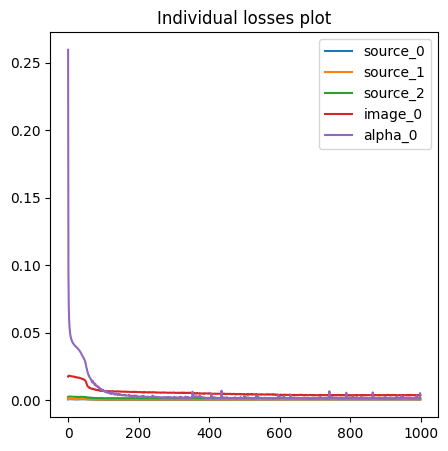

In [11]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

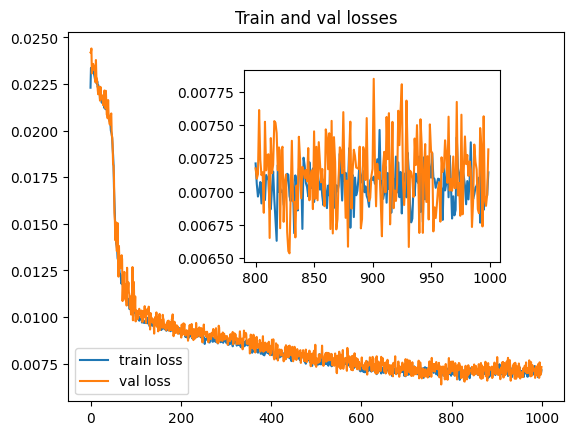

In [12]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [13]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.007443799714868267


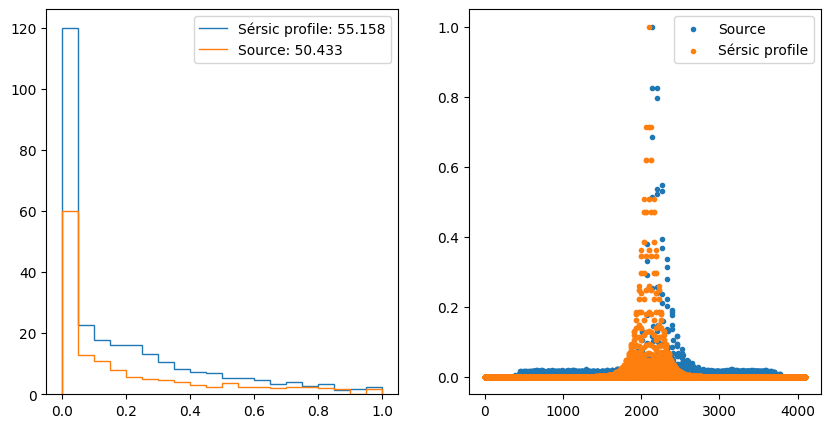

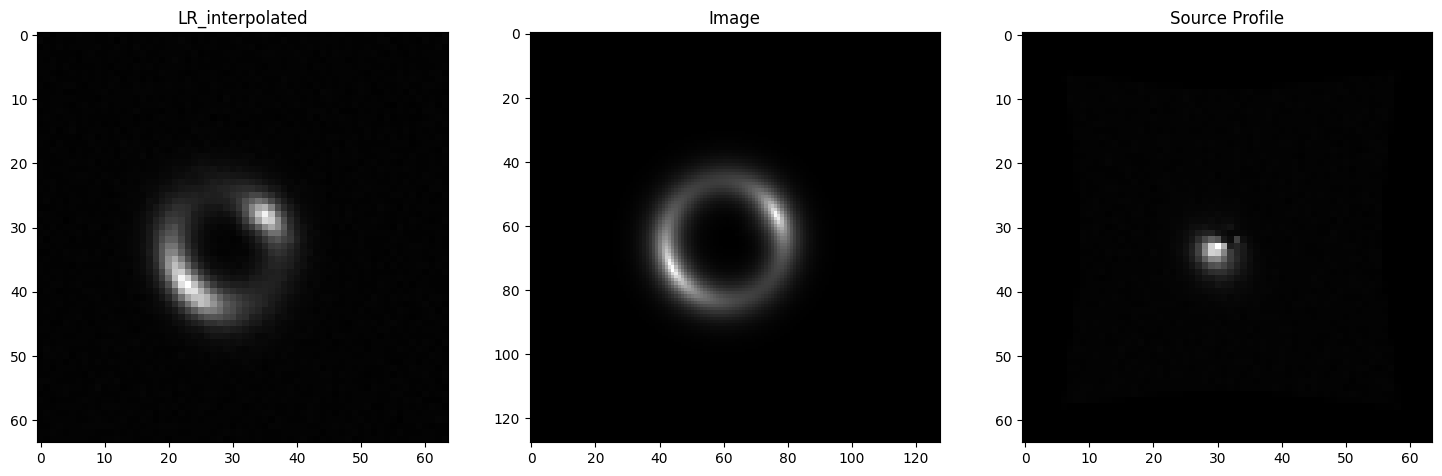

In [14]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [15]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [16]:
torch.save(best_weights, 'Weights_2.pt')